# Tequila Chemistry Basics

Here we show the basics of the tequila chemistry module.  
In order for this to work you need to have psi4 installed in the same python environment as tequila.  
If you are in a conda environment installing psi4 is easy:
`conda install psi4 -c psi4`  
But better check the psi4 website for up to date instructions.

In some cases problems with the environment where enountered which are suspected to originate from conflicts between psi4 and tequila dependcies. Usually the safest way is to install psi4 **first** and then install tequila

Basic functionality is currently also provided with PySCF which might be easier to install. 

At the moment we only support closed-shell molecules

**There might be issues with psi4 and jupyter, currently the workarround is to reload the kernel before a cell gets executed, or run as a regular python script**

In [1]:
import tequila as tq

## Initialize Molecules

Molecules can be initialized by passing their geometries as string or the name of a `xyz` file.

In [2]:
import tequila as tq
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g")
print(molecule)

# lets also print some information about the orbitals
# we need it later

print("The Orbitals are:")
for orbital in molecule.orbitals:
    print(orbital)

<class 'tequila.quantumchemistry.psi4_interface.QuantumChemistryPsi4'>
basis_set       : sto-3g          
geometry        : H 0.0 0.0 0.0
Li 0.0 0.0 1.6 
description     :                 
multiplicity    : 1               
charge          : 0               
closed_shell    : True            
name            : molecule        

Psi4 Data
Point Group (full) : c_inf_v         
Point Group (used) : c2v             
nirrep          : 4 
irreps          : ['A1', 'A2', 'B1', 'B2'] 
mos per irrep   : [4, 0, 1, 1]    

The Orbitals are:
0 : 0A1 energy = -2.348839 
1 : 1A1 energy = -0.285276 
2 : 2A1 energy = +0.078216 
3 : 0B1 energy = +0.163950 
4 : 0B2 energy = +0.163950 
5 : 3A1 energy = +0.547769 


You can initialize a tequila `QubitHamiltonian` from a molecule with `make_hamiltonian`.
The standard transformation is the `jordan-wigner` transformation.  
You can use other transformations by initializing the molecule with the `transformation` keyword.

In [3]:
import tequila as tq
H = molecule.make_hamiltonian()
# the LiH Hamiltonian is already quite large, better not print the full thing
print("Hamiltonian has {} terms".format(len(H)))

Hamiltonian has 631 terms


In [4]:
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", transformation="bravyi-kitaev")
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

Hamiltonian has 631 terms


## Setting active spaces

You can define active spaces on your molcule by passing down a dictionary of active orbitals.  
The orbitals are grouped into the irreducible representation of the underlying symmetry group (see the printout of `print(molecule)` above).

Lets take the LiH molecule from above but initialize it with an active space containing the second two A1 orbitals (meaning the first 0A1 orbital is frozen) and the B1 orbital

In [5]:
import tequila as tq
active_orbitals = {"A1":[1,2], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Hamiltonian has 62 terms


Lets make the active space even smaller, so that we can print out stuff in this tutorial

In [6]:
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))
print(H)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Hamiltonian has 15 terms
-7.4711+0.1352Z(0)+0.1352Z(1)-0.0310Z(2)-0.0310Z(3)+0.1218Z(0)Z(1)+0.0059Y(0)X(1)X(2)Y(3)-0.0059Y(0)Y(1)X(2)X(3)-0.0059X(0)X(1)Y(2)Y(3)+0.0059X(0)Y(1)Y(2)X(3)+0.0617Z(0)Z(2)+0.0675Z(0)Z(3)+0.0675Z(1)Z(2)+0.0617Z(1)Z(3)+0.0782Z(2)Z(3)


## Computing classical methods with Psi4

We can use psi4 to compute the energies (and sometimes other quantities) with the `compute_energy` function.
Here are some examples. Note that the energies are computed within the active space if one is set.

Note also that not all active spaces can be represented by psi4 which will mean you can/should not use the classical psi4 methods with those (a warning will be printed). You will still get the right active space hamiltonian however.

Active spaces which will not work for psi4 methds are the ones where the orbitals of individual irreps are not in one block ( e.g. {`"A1":[1,3]`} )

In [1]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0], "B2":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

mp2 = molecule.compute_energy(method="mp2")

# Note there are known issues for some methods when the active space as frozen virtuals as is the case here
# detci based methods are fine again 
fci = molecule.compute_energy(method="fci")

# for most coupled-cluster like models you can compute amplitudes
# Amplitudes are computed in c1 and in the full space, this is why the active space troubles from above usually don't hold
# Note that amplitudes are in closed-shell
amplitudes = molecule.compute_amplitudes("mp2")

# you can export a parameter dictionary which holds the indices of the amplitude as keys and values as values
# for this small active space that is only one amplitude for mp2
variables = amplitudes.make_parameter_dictionary()
print(variables)

# similar for ccsd since the singles are 0 due to symmetry (that changes if you change the active space)
amplitudes = molecule.compute_amplitudes("ccsd")
variables = amplitudes.make_parameter_dictionary()
print(variables)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for mp2.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
{(1, 0, 1, 0): -0.026069395810974536, (2, 0, 2, 0): -0.026069395810972836}
{(1, 0, 1, 0): -0.027418022914682542, (2, 0, 2, 0): -0.027418022914682535}


## Hello World H2 optimization with LiH in an active space

Lets do a small hand-constructed VQE like it would be done for the Hydrogen molecule in STO-3G, just that we use our active space LiH molecule from the cell above.
For consistency reasons we initialize everything again.  

Check the `BasicUsage` and `SciPyOptimizers` tutorial notebooks for more information about then

In [2]:
import tequila as tq
# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# define a hand designed circuit
U = tq.gates.Ry(angle="a", target=0) + tq.gates.X(target=[2,3])
U += tq.gates.X(target=1, control=0)
U += tq.gates.X(target=2, control=0)
U += tq.gates.X(target=3, control=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))


There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2 expectationvalues (min=2, max=2)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -7.197024007777559  angles= {a: 0.0}  samples= None
E= -7.197663726635509  angles= {a: -0.0234220027923584}  samples= None
E= -7.202037629758711  angles= {a: -0.11711001396179199}  samples= None
E= -7.247492279971124  angles= {a: -0.49186205863952637}  samples= None
E= -7.68640043833301  angles= {a: -1.9908702373504639}  samples= None
E= -7.59671569096237  angles= {a: -7.986902952194214}  samples= None
E= -7.862121739985101  angles= {a: -3.129600457337474}  samples= None
E= -7.598896929729115  angles= {a: -1.7104055550334691}  samples= None
E= -7.862681913900131  angles= {a: -

In [ ]:
# some more information from the optimization
result.history.plot("energies", baselines={"fci":fci})

## Unitary Coupled-Cluster Style Construction

Here we show how to initialize in the style of unitary coupled-cluster.  
In this example we are gonna compute the `mp2` amplitudes and build a UCC type circuit from them.  
Here we use the cc2 amplitudes only to define an order on the trotterized gates and remove small amplitudes as classical prescreening.

We use again an active space to make the computation fast.

First we start with the manual construction and then show how to use in build convenience functions of tequila to.

An important function is the `make_excitation_generator` function of the molecule.  
This initializes a `QubitHamiltonian` which can be used to define a unitary gate which acts as excitation operation of electrons.

$$\displaystyle
U(\theta) = e^{-i\frac{\theta}{2} G_{iajbkc\dots}}
$$

In fermionic language the generator is defined as

$$
G_{ia,jb,jc,\dots} =  i ( a^\dagger_a a_i a^\dagger_b a_j a^\dagger_c a_k \dots - h.c. )
$$

The `make_excitation_generator` function gives back this generator in the qubit representation (depends on the chosen `transformation` of the molecule) and takes the indices as list of tuples  
  
$$
\text{make_excitation_generator(indices=[(a,i),(b,j),...])} = G_{ia,jb,jc,\dots}
$$

### Manual Construction

In [1]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# compute classical amplitudes
amplitudes = molecule.compute_amplitudes(method="mp2")

# in this example there is only one closed-shell MP2 amplitude, therefore manual construction is reasonable in this tutorial
# first we make a dictionary out of the non-zero MP2 amplitudes
ampdict = amplitudes.make_parameter_dictionary(threshold=threshold)
print(ampdict)
# lets get the indices of the only amplitude which is there manually
indices = list(ampdict.keys())[0]

# the (1, 0, 1, 0) index in closed shell leads to the (2, 0, 3, 1) and (3, 1, 2, 0) excitations on the qubits
# but first we need to initialize the hartree fock state
U = molecule.prepare_reference()

# now add the two 2-electron excitations 
# for this we define the generators and build trotterized gates with them
# note that the two generators are actually the same
# we sum them up since we want to parametrize them with the same variable which we will call "a"
generator = molecule.make_excitation_generator(indices=[(3, 1),(2, 0)]) + molecule.make_excitation_generator(indices=[(3, 1),(2, 0)])
U += tq.gates.Trotterized(generators=[generator], angles=["a"], steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")
print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))



There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
{(1, 0, 1, 0): -0.026069395810974536}
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 16 expectationvalues (min=16, max=16)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -7.861864768775314  angles= {a: 0.0}  samples= None
E= -7.862598093888593  angles= {a: -0.0468440055847168}  samples= None
E= -7.862688897514223  angles= {a: -0.03516504106977361}  samples= None
Optimization terminated successfully.
         Current function value: -7.862689
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
VQE : -7.8626889f
FCI : -7.8626889f


### Automatic Construction

In [1]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# make the UCCSD ansatz (note that this will be without singles since it starts from mp2)
U = molecule.make_uccsd_ansatz(initial_amplitudes="mp2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))
    
    

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 32 expectationvalues (min=32, max=32)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -7.861864768775314  angles= {(1, 0, 1, 0): 0.0}  samples= None
E= -7.862598093888588  angles= {(1, 0, 1, 0): -0.0468440055847168}  samples= None
E= -7.862688897514223  angles= {(1, 0, 1, 0): -0.03516504106977361}  samples= None
Optimization terminated successfully.
         Current function value: -7.862689
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
VQE : -7.8626889f
FCI : -7.8626889f


### Pi System of Benzene
Lets repeat the last cell with the pi system of the benzene molecule

In [1]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
threshold = 1.e-6
active = {"B1u": [0], "B3g": [0, 1], "B2g": [0], "Au": [0], "b1u": [1]}
molecule = tq.quantumchemistry.Molecule(geometry="data/benzene.xyz", basis_set='sto-3g', active_orbitals=active)
H = molecule.make_hamiltonian()

# make the UCCSD ansatz
U = molecule.make_uccsd_ansatz(initial_amplitudes="cc2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# compute reference energies
fci = molecule.compute_energy("fci")
cisd = molecule.compute_energy("detci", options={"detci__ex_level": 2})

# optimize
result = tq.minimize(objective=E, method="BFGS", gradient="2-point", method_options={"eps":1.e-3, "gtol": 1.e-2}, initial_values={k:0.0 for k in E.extract_variables()})

print("VQE : {:+2.8}f".format(result.energy))
print("CISD: {:+2.8}f".format(cisd))
print("FCI : {:+2.8}f".format(fci))

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for detci.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2-point
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
22 active variables
E= -227.88792153297504  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0

E= -227.88772699368133  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.001, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E= -227.88781001304642  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 0.001, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E= -227.8877269810726  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2,

E= -226.9866615719647  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 0): -0.0002797510205709841, (5, 0, 5, 0): -0.08711814404907636, (3, 1, 3, 1): -0.11151888708127444, (3, 1, 4, 2): 0.3530088013974364, (4, 1, 5, 0): -0.04039760713681062, (3, 2, 4, 1): -0.2734920682314623, (5, 1, 4, 0): -0.16205490697984715, (5, 0, 4, 1): -0.04039760713681062, (5, 0, 3, 2): 0.03545315459518861, (4, 0, 4, 0): -0.11265558811146548, (5, 2, 3, 0): 0.1572695008746905, (4, 1, 4, 1): -0.19453929371593404, (4, 2, 4, 2): -0.11151992862323823, (3, 2, 3, 2): -0.19455190243888865, (4, 1, 3, 2): -0.2734920682314623, (3, 0, 3, 0): -0.11265259740866895, (5, 1, 5, 1): -0.11507963489520989, (4, 0, 5, 1): -0.16205490697984715}  samples= None
E= -226.98653821418802  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 0

E= -226.98622767253497  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 0): -0.0002797510205709841, (5, 0, 5, 0): -0.08811814404907636, (3, 1, 3, 1): -0.11151888708127444, (3, 1, 4, 2): 0.3530088013974364, (4, 1, 5, 0): -0.04039760713681062, (3, 2, 4, 1): -0.2734920682314623, (5, 1, 4, 0): -0.16205490697984715, (5, 0, 4, 1): -0.04039760713681062, (5, 0, 3, 2): 0.03545315459518861, (4, 0, 4, 0): -0.11265558811146548, (5, 2, 3, 0): 0.1572695008746905, (4, 1, 4, 1): -0.19353929371593404, (4, 2, 4, 2): -0.11151992862323823, (3, 2, 3, 2): -0.19455190243888865, (4, 1, 3, 2): -0.2734920682314623, (3, 0, 3, 0): -0.11265259740866895, (5, 1, 5, 1): -0.11507963489520989, (4, 0, 5, 1): -0.16205490697984715}  samples= None
E= -226.98653725410762  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 

E= -227.92456508553167  angles= {(3, 0, 5, 2): 0.016038611191311912, (3, 2, 5, 0): 0.004615573006178541, (5, 2, 5, 2): -0.011735864868194317, (4, 2, 3, 1): 0.03600043798215984, (4, 0): -2.85294848928511e-05, (5, 0, 5, 0): -0.00898643820602723, (3, 1, 3, 1): -0.011372885781646299, (3, 1, 4, 2): 0.03600043798215984, (4, 1, 5, 0): -0.0041198166861540755, (3, 2, 4, 1): -0.02789118628771642, (5, 1, 4, 0): -0.016526635045182293, (5, 0, 4, 1): -0.0041198166861540755, (5, 0, 3, 2): 0.0036155730061785407, (4, 0, 4, 0): -0.011488808486065155, (5, 2, 3, 0): 0.016038611191311912, (4, 1, 4, 1): -0.019839448055655535, (4, 2, 4, 2): -0.011372991999867275, (3, 2, 3, 2): -0.019840733914668018, (4, 1, 3, 2): -0.02789118628771642, (3, 0, 3, 0): -0.011488503489107224, (5, 1, 5, 1): -0.011736016900015704, (4, 0, 5, 1): -0.016526635045182293}  samples= None
E= -227.9243812058507  angles= {(3, 0, 5, 2): 0.016038611191311912, (3, 2, 5, 0): 0.0036155730061785407, (5, 2, 5, 2): -0.010735864868194316, (4, 2, 3, 

E= -227.9243487220543  angles= {(3, 0, 5, 2): 0.016038611191311912, (3, 2, 5, 0): 0.0036155730061785407, (5, 2, 5, 2): -0.011735864868194317, (4, 2, 3, 1): 0.03600043798215984, (4, 0): -2.85294848928511e-05, (5, 0, 5, 0): -0.00898643820602723, (3, 1, 3, 1): -0.011372885781646299, (3, 1, 4, 2): 0.03600043798215984, (4, 1, 5, 0): -0.0041198166861540755, (3, 2, 4, 1): -0.02789118628771642, (5, 1, 4, 0): -0.016526635045182293, (5, 0, 4, 1): -0.0031198166861540755, (5, 0, 3, 2): 0.0036155730061785407, (4, 0, 4, 0): -0.011488808486065155, (5, 2, 3, 0): 0.016038611191311912, (4, 1, 4, 1): -0.019839448055655535, (4, 2, 4, 2): -0.011372991999867275, (3, 2, 3, 2): -0.019840733914668018, (4, 1, 3, 2): -0.02789118628771642, (3, 0, 3, 0): -0.011488503489107224, (5, 1, 5, 1): -0.011736016900015704, (4, 0, 5, 1): -0.016526635045182293}  samples= None
E= -227.92456504452812  angles= {(3, 0, 5, 2): 0.016038611191311912, (3, 2, 5, 0): 0.0036155730061785407, (5, 2, 5, 2): -0.011735864868194317, (4, 2, 3,

E= -227.92438283189725  angles= {(3, 0, 5, 2): 0.016038611191311912, (3, 2, 5, 0): 0.0036155730061785407, (5, 2, 5, 2): -0.011735864868194317, (4, 2, 3, 1): 0.03600043798215984, (4, 0): -2.85294848928511e-05, (5, 0, 5, 0): -0.00898643820602723, (3, 1, 3, 1): -0.011372885781646299, (3, 1, 4, 2): 0.03600043798215984, (4, 1, 5, 0): -0.0041198166861540755, (3, 2, 4, 1): -0.02789118628771642, (5, 1, 4, 0): -0.016526635045182293, (5, 0, 4, 1): -0.0041198166861540755, (5, 0, 3, 2): 0.0036155730061785407, (4, 0, 4, 0): -0.011488808486065155, (5, 2, 3, 0): 0.016038611191311912, (4, 1, 4, 1): -0.019839448055655535, (4, 2, 4, 2): -0.011372991999867275, (3, 2, 3, 2): -0.019840733914668018, (4, 1, 3, 2): -0.02789118628771642, (3, 0, 3, 0): -0.011488503489107224, (5, 1, 5, 1): -0.011736016900015704, (4, 0, 5, 1): -0.015526635045182292}  samples= None
E= -227.97587218836637  angles= {(3, 0, 5, 2): 0.051883592851916, (3, 2, 5, 0): 0.03869655107770094, (5, 2, 5, 2): -0.045489125262661786, (4, 2, 3, 1):

E= -227.97589095089867  angles= {(3, 0, 5, 2): 0.051883592851916, (3, 2, 5, 0): 0.03869655107770094, (5, 2, 5, 2): -0.045489125262661786, (4, 2, 3, 1): 0.0501976249363625, (4, 0): -0.00013290431474000745, (5, 0, 5, 0): -0.04074346471081846, (3, 1, 3, 1): -0.03792524610565125, (3, 1, 4, 2): 0.05115904099697631, (4, 1, 5, 0): -0.040826415188762885, (3, 2, 4, 1): -0.0008343049498237241, (5, 1, 4, 0): -0.05405909979604288, (5, 0, 4, 1): -0.04083586758292433, (5, 0, 3, 2): 0.0386842501193568, (4, 0, 4, 0): -0.045472401163241694, (5, 2, 3, 0): 0.05187863233974186, (4, 1, 4, 1): -0.08910033507119311, (4, 2, 4, 2): -0.03792521606026719, (3, 2, 3, 2): -0.08887251470158511, (4, 1, 3, 2): -0.0009724027762687167, (3, 0, 3, 0): -0.04535518582108936, (5, 1, 5, 1): -0.04559387593747148, (4, 0, 5, 1): -0.05405837600361715}  samples= None
E= -227.9758203290744  angles= {(3, 0, 5, 2): 0.051883592851916, (3, 2, 5, 0): 0.03869655107770094, (5, 2, 5, 2): -0.045489125262661786, (4, 2, 3, 1): 0.0501976249363

E= -227.97577712385265  angles= {(3, 0, 5, 2): 0.051883592851916, (3, 2, 5, 0): 0.03869655107770094, (5, 2, 5, 2): -0.045489125262661786, (4, 2, 3, 1): 0.0501976249363625, (4, 0): -0.00013290431474000745, (5, 0, 5, 0): -0.04074346471081846, (3, 1, 3, 1): -0.03792524610565125, (3, 1, 4, 2): 0.05015904099697631, (4, 1, 5, 0): -0.040826415188762885, (3, 2, 4, 1): -0.0008343049498237241, (5, 1, 4, 0): -0.05405909979604288, (5, 0, 4, 1): -0.04083586758292433, (5, 0, 3, 2): 0.0386842501193568, (4, 0, 4, 0): -0.045472401163241694, (5, 2, 3, 0): 0.05187863233974186, (4, 1, 4, 1): -0.08910033507119311, (4, 2, 4, 2): -0.03792521606026719, (3, 2, 3, 2): -0.08787251470158511, (4, 1, 3, 2): -0.0009724027762687167, (3, 0, 3, 0): -0.04535518582108936, (5, 1, 5, 1): -0.04559387593747148, (4, 0, 5, 1): -0.05405837600361715}  samples= None
E= -227.97595052243994  angles= {(3, 0, 5, 2): 0.051883592851916, (3, 2, 5, 0): 0.03869655107770094, (5, 2, 5, 2): -0.045489125262661786, (4, 2, 3, 1): 0.050197624936

E= -227.96746760827546  angles= {(3, 0, 5, 2): 0.07784122613478739, (3, 2, 5, 0): 0.0915776460967775, (5, 2, 5, 2): -0.022574490836294557, (4, 2, 3, 1): 0.12418998073057529, (4, 0): -0.0003856378768199842, (5, 0, 5, 0): -0.04545862414591133, (3, 1, 3, 1): -0.02836860264853085, (3, 1, 4, 2): 0.12333978494856614, (4, 1, 5, 0): -0.09537719163619202, (3, 2, 4, 1): 0.05739897696233216, (5, 1, 4, 0): -0.07140036482209756, (5, 0, 4, 1): -0.09544318514219799, (5, 0, 3, 2): 0.09148094885569133, (4, 0, 4, 0): -0.039677638940738454, (5, 2, 3, 0): 0.07775806239772445, (4, 1, 4, 1): -0.21084880653775237, (4, 2, 4, 2): -0.0283850941097696, (3, 2, 3, 2): -0.206448131477647, (4, 1, 3, 2): 0.056687400087194154, (3, 0, 3, 0): -0.03675159217101123, (5, 1, 5, 1): -0.02506038445239863, (4, 0, 5, 1): -0.0713543454631812}  samples= None
E= -227.9675869829188  angles= {(3, 0, 5, 2): 0.07784122613478739, (3, 2, 5, 0): 0.0915776460967775, (5, 2, 5, 2): -0.022574490836294557, (4, 2, 3, 1): 0.12318998073057529, (

E= -227.96755508244047  angles= {(3, 0, 5, 2): 0.07784122613478739, (3, 2, 5, 0): 0.0915776460967775, (5, 2, 5, 2): -0.022574490836294557, (4, 2, 3, 1): 0.12318998073057529, (4, 0): -0.0003856378768199842, (5, 0, 5, 0): -0.04545862414591133, (3, 1, 3, 1): -0.02836860264853085, (3, 1, 4, 2): 0.12333978494856614, (4, 1, 5, 0): -0.09537719163619202, (3, 2, 4, 1): 0.05739897696233216, (5, 1, 4, 0): -0.07140036482209756, (5, 0, 4, 1): -0.09544318514219799, (5, 0, 3, 2): 0.09148094885569133, (4, 0, 4, 0): -0.03867763894073845, (5, 2, 3, 0): 0.07775806239772445, (4, 1, 4, 1): -0.21084880653775237, (4, 2, 4, 2): -0.0283850941097696, (3, 2, 3, 2): -0.206448131477647, (4, 1, 3, 2): 0.056687400087194154, (3, 0, 3, 0): -0.03675159217101123, (5, 1, 5, 1): -0.02506038445239863, (4, 0, 5, 1): -0.0713543454631812}  samples= None
E= -227.96781679631783  angles= {(3, 0, 5, 2): 0.07784122613478739, (3, 2, 5, 0): 0.0915776460967775, (5, 2, 5, 2): -0.022574490836294557, (4, 2, 3, 1): 0.12318998073057529, (

E= -227.98610323490803  angles= {(3, 0, 5, 2): 0.06291270575328152, (3, 2, 5, 0): 0.06116514676812889, (5, 2, 5, 2): -0.03575294910870215, (4, 2, 3, 1): 0.08121127414768083, (4, 0): -0.00024028802571891513, (5, 0, 5, 0): -0.04274688409774284, (3, 1, 3, 1): -0.03386473340412434, (3, 1, 4, 2): 0.08125273426448225, (4, 1, 5, 0): -0.06400444015503955, (3, 2, 4, 1): 0.023908376088436482, (5, 1, 4, 0): -0.06142721258739909, (5, 0, 4, 1): -0.0640379162457879, (5, 0, 3, 2): 0.06111698675743303, (4, 0, 4, 0): -0.043010270425354706, (5, 2, 3, 0): 0.0628745175509266, (4, 1, 4, 1): -0.1408299216147944, (4, 2, 4, 2): -0.03387172316520175, (3, 2, 3, 2): -0.1388291011800049, (4, 1, 3, 2): 0.023526613321290725, (3, 0, 3, 0): -0.0416996135009889, (5, 1, 5, 1): -0.03686942123159759, (4, 0, 5, 1): -0.061407243206929474}  samples= None
E= -227.9862170647656  angles= {(3, 0, 5, 2): 0.06391270575328152, (3, 2, 5, 0): 0.06116514676812889, (5, 2, 5, 2): -0.03575294910870215, (4, 2, 3, 1): 0.08121127414768083,

E= -227.9861947845722  angles= {(3, 0, 5, 2): 0.06291270575328152, (3, 2, 5, 0): 0.06116514676812889, (5, 2, 5, 2): -0.03575294910870215, (4, 2, 3, 1): 0.08121127414768083, (4, 0): -0.00024028802571891513, (5, 0, 5, 0): -0.04274688409774284, (3, 1, 3, 1): -0.03386473340412434, (3, 1, 4, 2): 0.08125273426448225, (4, 1, 5, 0): -0.06400444015503955, (3, 2, 4, 1): 0.024908376088436483, (5, 1, 4, 0): -0.06142721258739909, (5, 0, 4, 1): -0.0640379162457879, (5, 0, 3, 2): 0.06111698675743303, (4, 0, 4, 0): -0.043010270425354706, (5, 2, 3, 0): 0.0628745175509266, (4, 1, 4, 1): -0.1408299216147944, (4, 2, 4, 2): -0.03387172316520175, (3, 2, 3, 2): -0.1388291011800049, (4, 1, 3, 2): 0.023526613321290725, (3, 0, 3, 0): -0.0416996135009889, (5, 1, 5, 1): -0.03686942123159759, (4, 0, 5, 1): -0.061407243206929474}  samples= None
E= -227.98594930746427  angles= {(3, 0, 5, 2): 0.06291270575328152, (3, 2, 5, 0): 0.06116514676812889, (5, 2, 5, 2): -0.03575294910870215, (4, 2, 3, 1): 0.08121127414768083,

E= -227.98608668073433  angles= {(3, 0, 5, 2): 0.06291270575328152, (3, 2, 5, 0): 0.06116514676812889, (5, 2, 5, 2): -0.03575294910870215, (4, 2, 3, 1): 0.08121127414768083, (4, 0): -0.00024028802571891513, (5, 0, 5, 0): -0.04274688409774284, (3, 1, 3, 1): -0.03386473340412434, (3, 1, 4, 2): 0.08125273426448225, (4, 1, 5, 0): -0.06400444015503955, (3, 2, 4, 1): 0.023908376088436482, (5, 1, 4, 0): -0.06142721258739909, (5, 0, 4, 1): -0.0640379162457879, (5, 0, 3, 2): 0.06111698675743303, (4, 0, 4, 0): -0.043010270425354706, (5, 2, 3, 0): 0.0628745175509266, (4, 1, 4, 1): -0.1408299216147944, (4, 2, 4, 2): -0.03387172316520175, (3, 2, 3, 2): -0.1388291011800049, (4, 1, 3, 2): 0.023526613321290725, (3, 0, 3, 0): -0.0406996135009889, (5, 1, 5, 1): -0.03686942123159759, (4, 0, 5, 1): -0.061407243206929474}  samples= None
E= -227.9860816868411  angles= {(3, 0, 5, 2): 0.06291270575328152, (3, 2, 5, 0): 0.06116514676812889, (5, 2, 5, 2): -0.03575294910870215, (4, 2, 3, 1): 0.08121127414768083,

E= -227.99267381873617  angles= {(3, 0, 5, 2): 0.08928400411759504, (3, 2, 5, 0): 0.06832150372371562, (5, 2, 5, 2): -0.02560017641597427, (4, 2, 3, 1): 0.11015254110042047, (4, 0): -0.0003322060915311845, (5, 0, 5, 0): -0.044732538806223056, (3, 1, 3, 1): -0.027677375317230912, (3, 1, 4, 2): 0.11032756881740154, (4, 1, 5, 0): -0.06629472126932572, (3, 2, 4, 1): 0.059186109712491344, (5, 1, 4, 0): -0.0895503798027921, (5, 0, 4, 1): -0.06635308489738104, (5, 0, 3, 2): 0.06823504857374578, (4, 0, 4, 0): -0.040262874939567775, (5, 2, 3, 0): 0.08920962260797063, (4, 1, 4, 1): -0.19767494330167443, (4, 2, 4, 2): -0.02766968557599958, (3, 2, 3, 2): -0.19407635491196568, (4, 1, 3, 2): 0.05846780727592995, (3, 0, 3, 0): -0.037534399114132186, (5, 1, 5, 1): -0.027916027326478444, (4, 0, 5, 1): -0.08951025680180658}  samples= None
E= -227.99272041211216  angles= {(3, 0, 5, 2): 0.08928400411759504, (3, 2, 5, 0): 0.06832150372371562, (5, 2, 5, 2): -0.02560017641597427, (4, 2, 3, 1): 0.110152541100

E= -227.99274070536208  angles= {(3, 0, 5, 2): 0.08928400411759504, (3, 2, 5, 0): 0.06832150372371562, (5, 2, 5, 2): -0.02560017641597427, (4, 2, 3, 1): 0.11015254110042047, (4, 0): -0.0003322060915311845, (5, 0, 5, 0): -0.04573253880622306, (3, 1, 3, 1): -0.027677375317230912, (3, 1, 4, 2): 0.11032756881740154, (4, 1, 5, 0): -0.06629472126932572, (3, 2, 4, 1): 0.059186109712491344, (5, 1, 4, 0): -0.0895503798027921, (5, 0, 4, 1): -0.06635308489738104, (5, 0, 3, 2): 0.06823504857374578, (4, 0, 4, 0): -0.040262874939567775, (5, 2, 3, 0): 0.08920962260797063, (4, 1, 4, 1): -0.19667494330167443, (4, 2, 4, 2): -0.02766968557599958, (3, 2, 3, 2): -0.19407635491196568, (4, 1, 3, 2): 0.05846780727592995, (3, 0, 3, 0): -0.037534399114132186, (5, 1, 5, 1): -0.027916027326478444, (4, 0, 5, 1): -0.08951025680180658}  samples= None
E= -227.99272067850478  angles= {(3, 0, 5, 2): 0.08928400411759504, (3, 2, 5, 0): 0.06832150372371562, (5, 2, 5, 2): -0.02560017641597427, (4, 2, 3, 1): 0.1101525411004

E= -227.99029199319776  angles= {(3, 0, 5, 2): 0.081051914894024, (3, 2, 5, 0): 0.05321871502391433, (5, 2, 5, 2): -0.047472740329409284, (4, 2, 3, 1): 0.11262497447388568, (4, 0): -0.0015877916457874349, (5, 0, 5, 0): -0.0886410649918203, (3, 1, 3, 1): -0.03286769226672641, (3, 1, 4, 2): 0.11303017921825485, (4, 1, 5, 0): -0.06405957406400768, (3, 2, 4, 1): 0.06363183182679583, (5, 1, 4, 0): -0.07117204377737507, (5, 0, 4, 1): -0.06402003991622886, (5, 0, 3, 2): 0.052141025299800206, (4, 0, 4, 0): -0.04498748889171825, (5, 2, 3, 0): 0.08097708037296093, (4, 1, 4, 1): -0.19484865354978473, (4, 2, 4, 2): -0.03263138433846201, (3, 2, 3, 2): -0.1927531709062164, (4, 1, 3, 2): 0.06256339075433724, (3, 0, 3, 0): -0.046320214020895596, (5, 1, 5, 1): -0.04558337737646794, (4, 0, 5, 1): -0.07120491170914986}  samples= None
E= -227.99020755947745  angles= {(3, 0, 5, 2): 0.081051914894024, (3, 2, 5, 0): 0.05221871502391433, (5, 2, 5, 2): -0.04647274032940928, (4, 2, 3, 1): 0.11262497447388568, (

E= -227.99023421841042  angles= {(3, 0, 5, 2): 0.081051914894024, (3, 2, 5, 0): 0.05221871502391433, (5, 2, 5, 2): -0.047472740329409284, (4, 2, 3, 1): 0.11262497447388568, (4, 0): -0.0015877916457874349, (5, 0, 5, 0): -0.0886410649918203, (3, 1, 3, 1): -0.03286769226672641, (3, 1, 4, 2): 0.11303017921825485, (4, 1, 5, 0): -0.06405957406400768, (3, 2, 4, 1): 0.06363183182679583, (5, 1, 4, 0): -0.07117204377737507, (5, 0, 4, 1): -0.06302003991622886, (5, 0, 3, 2): 0.052141025299800206, (4, 0, 4, 0): -0.04498748889171825, (5, 2, 3, 0): 0.08097708037296093, (4, 1, 4, 1): -0.19484865354978473, (4, 2, 4, 2): -0.03263138433846201, (3, 2, 3, 2): -0.1927531709062164, (4, 1, 3, 2): 0.06256339075433724, (3, 0, 3, 0): -0.046320214020895596, (5, 1, 5, 1): -0.04558337737646794, (4, 0, 5, 1): -0.07120491170914986}  samples= None
E= -227.99029178024742  angles= {(3, 0, 5, 2): 0.081051914894024, (3, 2, 5, 0): 0.05221871502391433, (5, 2, 5, 2): -0.047472740329409284, (4, 2, 3, 1): 0.11262497447388568, 

E= -227.99006682263933  angles= {(3, 0, 5, 2): 0.081051914894024, (3, 2, 5, 0): 0.05221871502391433, (5, 2, 5, 2): -0.047472740329409284, (4, 2, 3, 1): 0.11262497447388568, (4, 0): -0.0015877916457874349, (5, 0, 5, 0): -0.0886410649918203, (3, 1, 3, 1): -0.03286769226672641, (3, 1, 4, 2): 0.11303017921825485, (4, 1, 5, 0): -0.06405957406400768, (3, 2, 4, 1): 0.06363183182679583, (5, 1, 4, 0): -0.07117204377737507, (5, 0, 4, 1): -0.06402003991622886, (5, 0, 3, 2): 0.052141025299800206, (4, 0, 4, 0): -0.04498748889171825, (5, 2, 3, 0): 0.08097708037296093, (4, 1, 4, 1): -0.19484865354978473, (4, 2, 4, 2): -0.03263138433846201, (3, 2, 3, 2): -0.1927531709062164, (4, 1, 3, 2): 0.06256339075433724, (3, 0, 3, 0): -0.046320214020895596, (5, 1, 5, 1): -0.04558337737646794, (4, 0, 5, 1): -0.07020491170914986}  samples= None
E= -227.99385649504214  angles= {(3, 0, 5, 2): 0.08636851544505106, (3, 2, 5, 0): 0.0626185166962895, (5, 2, 5, 2): -0.033346595410866, (4, 2, 3, 1): 0.11102818169397936, (4

E= -227.99385893607348  angles= {(3, 0, 5, 2): 0.08636851544505106, (3, 2, 5, 0): 0.0626185166962895, (5, 2, 5, 2): -0.033346595410866, (4, 2, 3, 1): 0.11102818169397936, (4, 0): -0.0007768860945567096, (5, 0, 5, 0): -0.06092908474397449, (3, 1, 3, 1): -0.029515585504486738, (3, 1, 4, 2): 0.1122847292412009, (4, 1, 5, 0): -0.0655031182896211, (3, 2, 4, 1): 0.06076061311175241, (5, 1, 4, 0): -0.08304148163039511, (5, 0, 4, 1): -0.06552681029923788, (5, 0, 3, 2): 0.06253516592226827, (4, 0, 4, 0): -0.04193615107707575, (5, 2, 3, 0): 0.08629397349623776, (4, 1, 4, 1): -0.19667398041932765, (4, 2, 4, 2): -0.029426928014178545, (3, 2, 3, 2): -0.19360773414320537, (4, 1, 3, 2): 0.05991830506749482, (3, 0, 3, 0): -0.04064599607865405, (5, 1, 5, 1): -0.034173121673455105, (4, 0, 5, 1): -0.08302720920413997}  samples= None
E= -227.99384886543868  angles= {(3, 0, 5, 2): 0.08636851544505106, (3, 2, 5, 0): 0.0626185166962895, (5, 2, 5, 2): -0.033346595410866, (4, 2, 3, 1): 0.11102818169397936, (4,

E= -227.99386790560575  angles= {(3, 0, 5, 2): 0.08636851544505106, (3, 2, 5, 0): 0.0626185166962895, (5, 2, 5, 2): -0.033346595410866, (4, 2, 3, 1): 0.11102818169397936, (4, 0): -0.0007768860945567096, (5, 0, 5, 0): -0.06092908474397449, (3, 1, 3, 1): -0.029515585504486738, (3, 1, 4, 2): 0.1112847292412009, (4, 1, 5, 0): -0.0655031182896211, (3, 2, 4, 1): 0.06076061311175241, (5, 1, 4, 0): -0.08304148163039511, (5, 0, 4, 1): -0.06552681029923788, (5, 0, 3, 2): 0.06253516592226827, (4, 0, 4, 0): -0.04193615107707575, (5, 2, 3, 0): 0.08629397349623776, (4, 1, 4, 1): -0.19667398041932765, (4, 2, 4, 2): -0.029426928014178545, (3, 2, 3, 2): -0.19260773414320537, (4, 1, 3, 2): 0.05991830506749482, (3, 0, 3, 0): -0.04064599607865405, (5, 1, 5, 1): -0.034173121673455105, (4, 0, 5, 1): -0.08302720920413997}  samples= None
E= -227.9938453551349  angles= {(3, 0, 5, 2): 0.08636851544505106, (3, 2, 5, 0): 0.0626185166962895, (5, 2, 5, 2): -0.033346595410866, (4, 2, 3, 1): 0.11102818169397936, (4, 

E= -227.9923206233035  angles= {(3, 0, 5, 2): 0.07283021096167522, (3, 2, 5, 0): 0.06644180682112616, (5, 2, 5, 2): -0.0423020681908917, (4, 2, 3, 1): 0.11107920515369667, (4, 0): -0.0010504433270739728, (5, 0, 5, 0): -0.07551531086876584, (3, 1, 3, 1): -0.03289749326488155, (3, 1, 4, 2): 0.11046565556984525, (4, 1, 5, 0): -0.058008058414022075, (3, 2, 4, 1): 0.059678083866784255, (5, 1, 4, 0): -0.08218329797724785, (5, 0, 4, 1): -0.0579902119705343, (5, 0, 3, 2): 0.06634686603571636, (4, 0, 4, 0): -0.04400541749025742, (5, 2, 3, 0): 0.07274095317669012, (4, 1, 4, 1): -0.1898492378402929, (4, 2, 4, 2): -0.032693631125110006, (3, 2, 3, 2): -0.18839058960105812, (4, 1, 3, 2): 0.05864628631096393, (3, 0, 3, 0): -0.04339640023781057, (5, 1, 5, 1): -0.0425035994627394, (4, 0, 5, 1): -0.08219975331210164}  samples= None
E= -227.9923271005208  angles= {(3, 0, 5, 2): 0.07283021096167522, (3, 2, 5, 0): 0.06644180682112616, (5, 2, 5, 2): -0.0423020681908917, (4, 2, 3, 1): 0.11007920515369667, (4

E= -227.99234103393283  angles= {(3, 0, 5, 2): 0.07283021096167522, (3, 2, 5, 0): 0.06644180682112616, (5, 2, 5, 2): -0.0423020681908917, (4, 2, 3, 1): 0.11007920515369667, (4, 0): -0.0010504433270739728, (5, 0, 5, 0): -0.07551531086876584, (3, 1, 3, 1): -0.03289749326488155, (3, 1, 4, 2): 0.11046565556984525, (4, 1, 5, 0): -0.058008058414022075, (3, 2, 4, 1): 0.059678083866784255, (5, 1, 4, 0): -0.08218329797724785, (5, 0, 4, 1): -0.0579902119705343, (5, 0, 3, 2): 0.06634686603571636, (4, 0, 4, 0): -0.04300541749025742, (5, 2, 3, 0): 0.07274095317669012, (4, 1, 4, 1): -0.1898492378402929, (4, 2, 4, 2): -0.032693631125110006, (3, 2, 3, 2): -0.18839058960105812, (4, 1, 3, 2): 0.05864628631096393, (3, 0, 3, 0): -0.04339640023781057, (5, 1, 5, 1): -0.0425035994627394, (4, 0, 5, 1): -0.08219975331210164}  samples= None
E= -227.99242852751132  angles= {(3, 0, 5, 2): 0.07283021096167522, (3, 2, 5, 0): 0.06644180682112616, (5, 2, 5, 2): -0.0423020681908917, (4, 2, 3, 1): 0.11007920515369667, 

E= -227.99418610257175  angles= {(3, 0, 5, 2): 0.08238001858221876, (3, 2, 5, 0): 0.06374488969870895, (5, 2, 5, 2): -0.035984952018384544, (4, 2, 3, 1): 0.11074860532912018, (4, 0): -0.0008574783256621607, (5, 0, 5, 0): -0.06522630801966094, (3, 1, 3, 1): -0.030511923599060263, (3, 1, 4, 2): 0.11104342333966485, (4, 1, 5, 0): -0.06329501144453759, (3, 2, 4, 1): 0.06044169101166362, (5, 1, 4, 0): -0.08278865360362744, (5, 0, 4, 1): -0.0633064658811187, (5, 0, 3, 2): 0.0636581244111406, (4, 0, 4, 0): -0.042545774136408906, (5, 2, 3, 0): 0.08230114122593421, (4, 1, 4, 1): -0.19466335461315354, (4, 2, 4, 2): -0.030389325862871762, (3, 2, 3, 2): -0.19207072006106174, (4, 1, 3, 2): 0.05954355778461925, (3, 0, 3, 0): -0.04145628797109798, (5, 1, 5, 1): -0.036627349569515064, (4, 0, 5, 1): -0.08278343383082203}  samples= None
E= -227.99417544847438  angles= {(3, 0, 5, 2): 0.08338001858221876, (3, 2, 5, 0): 0.06374488969870895, (5, 2, 5, 2): -0.035984952018384544, (4, 2, 3, 1): 0.1107486053291

E= -227.9941774080819  angles= {(3, 0, 5, 2): 0.08238001858221876, (3, 2, 5, 0): 0.06374488969870895, (5, 2, 5, 2): -0.035984952018384544, (4, 2, 3, 1): 0.11074860532912018, (4, 0): -0.0008574783256621607, (5, 0, 5, 0): -0.06522630801966094, (3, 1, 3, 1): -0.030511923599060263, (3, 1, 4, 2): 0.11104342333966485, (4, 1, 5, 0): -0.06329501144453759, (3, 2, 4, 1): 0.06144169101166362, (5, 1, 4, 0): -0.08278865360362744, (5, 0, 4, 1): -0.0633064658811187, (5, 0, 3, 2): 0.0636581244111406, (4, 0, 4, 0): -0.042545774136408906, (5, 2, 3, 0): 0.08230114122593421, (4, 1, 4, 1): -0.19466335461315354, (4, 2, 4, 2): -0.030389325862871762, (3, 2, 3, 2): -0.19207072006106174, (4, 1, 3, 2): 0.05954355778461925, (3, 0, 3, 0): -0.04145628797109798, (5, 1, 5, 1): -0.036627349569515064, (4, 0, 5, 1): -0.08278343383082203}  samples= None
E= -227.9942121752935  angles= {(3, 0, 5, 2): 0.08238001858221876, (3, 2, 5, 0): 0.06374488969870895, (5, 2, 5, 2): -0.035984952018384544, (4, 2, 3, 1): 0.110748605329120

E= -227.9941881936507  angles= {(3, 0, 5, 2): 0.08238001858221876, (3, 2, 5, 0): 0.06374488969870895, (5, 2, 5, 2): -0.035984952018384544, (4, 2, 3, 1): 0.11074860532912018, (4, 0): -0.0008574783256621607, (5, 0, 5, 0): -0.06522630801966094, (3, 1, 3, 1): -0.030511923599060263, (3, 1, 4, 2): 0.11104342333966485, (4, 1, 5, 0): -0.06329501144453759, (3, 2, 4, 1): 0.06044169101166362, (5, 1, 4, 0): -0.08278865360362744, (5, 0, 4, 1): -0.0633064658811187, (5, 0, 3, 2): 0.0636581244111406, (4, 0, 4, 0): -0.042545774136408906, (5, 2, 3, 0): 0.08230114122593421, (4, 1, 4, 1): -0.19466335461315354, (4, 2, 4, 2): -0.030389325862871762, (3, 2, 3, 2): -0.19207072006106174, (4, 1, 3, 2): 0.05954355778461925, (3, 0, 3, 0): -0.04045628797109798, (5, 1, 5, 1): -0.036627349569515064, (4, 0, 5, 1): -0.08278343383082203}  samples= None
E= -227.99418625965467  angles= {(3, 0, 5, 2): 0.08238001858221876, (3, 2, 5, 0): 0.06374488969870895, (5, 2, 5, 2): -0.035984952018384544, (4, 2, 3, 1): 0.11074860532912

E= -227.9945212509429  angles= {(3, 0, 5, 2): 0.081263283823924, (3, 2, 5, 0): 0.0645217947862847, (5, 2, 5, 2): -0.038858968689755295, (4, 2, 3, 1): 0.10609487339271019, (4, 0): -0.0010687997794181627, (5, 0, 5, 0): -0.059983442964892095, (3, 1, 3, 1): -0.033794818277728914, (3, 1, 4, 2): 0.10652263350396633, (4, 1, 5, 0): -0.06495700156335626, (3, 2, 4, 1): 0.056141346371607746, (5, 1, 4, 0): -0.08112744984598205, (5, 0, 4, 1): -0.0649389437814338, (5, 0, 3, 2): 0.0644135714357475, (4, 0, 4, 0): -0.04211524807711982, (5, 2, 3, 0): 0.08116293934118803, (4, 1, 4, 1): -0.18375252338692946, (4, 2, 4, 2): -0.033612097897724146, (3, 2, 3, 2): -0.1812412070360136, (4, 1, 3, 2): 0.05505668687620177, (3, 0, 3, 0): -0.041500063854620774, (5, 1, 5, 1): -0.03924284033594837, (4, 0, 5, 1): -0.08114452390408193}  samples= None
E= -227.9945209052863  angles= {(3, 0, 5, 2): 0.081263283823924, (3, 2, 5, 0): 0.0645217947862847, (5, 2, 5, 2): -0.038858968689755295, (4, 2, 3, 1): 0.10609487339271019, (4

E= -227.99452077473362  angles= {(3, 0, 5, 2): 0.081263283823924, (3, 2, 5, 0): 0.0645217947862847, (5, 2, 5, 2): -0.038858968689755295, (4, 2, 3, 1): 0.10609487339271019, (4, 0): -0.0010687997794181627, (5, 0, 5, 0): -0.060983442964892096, (3, 1, 3, 1): -0.033794818277728914, (3, 1, 4, 2): 0.10652263350396633, (4, 1, 5, 0): -0.06495700156335626, (3, 2, 4, 1): 0.056141346371607746, (5, 1, 4, 0): -0.08112744984598205, (5, 0, 4, 1): -0.0649389437814338, (5, 0, 3, 2): 0.0644135714357475, (4, 0, 4, 0): -0.04211524807711982, (5, 2, 3, 0): 0.08116293934118803, (4, 1, 4, 1): -0.18275252338692946, (4, 2, 4, 2): -0.033612097897724146, (3, 2, 3, 2): -0.1812412070360136, (4, 1, 3, 2): 0.05505668687620177, (3, 0, 3, 0): -0.041500063854620774, (5, 1, 5, 1): -0.03924284033594837, (4, 0, 5, 1): -0.08114452390408193}  samples= None
E= -227.99452080655294  angles= {(3, 0, 5, 2): 0.081263283823924, (3, 2, 5, 0): 0.0645217947862847, (5, 2, 5, 2): -0.038858968689755295, (4, 2, 3, 1): 0.10609487339271019, 

E= -227.9945172574771  angles= {(3, 0, 5, 2): 0.08073524589487673, (3, 2, 5, 0): 0.06543156682840065, (5, 2, 5, 2): -0.03723996306300814, (4, 2, 3, 1): 0.1043897530424029, (4, 0): -0.0006094660159231628, (5, 0, 5, 0): -0.06033501238745124, (3, 1, 3, 1): -0.033800036686044956, (3, 1, 4, 2): 0.10503956129518362, (4, 1, 5, 0): -0.06463585781187689, (3, 2, 4, 1): 0.05472637033002066, (5, 1, 4, 0): -0.08015177359914095, (5, 0, 4, 1): -0.06458420366491371, (5, 0, 3, 2): 0.06429782868184891, (4, 0, 4, 0): -0.04451228421620028, (5, 2, 3, 0): 0.08060889531248139, (4, 1, 4, 1): -0.18337321468326553, (4, 2, 4, 2): -0.033723532559764575, (3, 2, 3, 2): -0.18053679966433486, (4, 1, 3, 2): 0.0533091742480353, (3, 0, 3, 0): -0.04335282544481783, (5, 1, 5, 1): -0.03807160872382565, (4, 0, 5, 1): -0.080192429381592}  samples= None
E= -227.994515754274  angles= {(3, 0, 5, 2): 0.08073524589487673, (3, 2, 5, 0): 0.06443156682840065, (5, 2, 5, 2): -0.03623996306300814, (4, 2, 3, 1): 0.1043897530424029, (4, 

E= -227.99451791658657  angles= {(3, 0, 5, 2): 0.08073524589487673, (3, 2, 5, 0): 0.06443156682840065, (5, 2, 5, 2): -0.03723996306300814, (4, 2, 3, 1): 0.1043897530424029, (4, 0): -0.0006094660159231628, (5, 0, 5, 0): -0.06033501238745124, (3, 1, 3, 1): -0.033800036686044956, (3, 1, 4, 2): 0.10503956129518362, (4, 1, 5, 0): -0.06463585781187689, (3, 2, 4, 1): 0.05472637033002066, (5, 1, 4, 0): -0.08015177359914095, (5, 0, 4, 1): -0.06358420366491371, (5, 0, 3, 2): 0.06429782868184891, (4, 0, 4, 0): -0.04451228421620028, (5, 2, 3, 0): 0.08060889531248139, (4, 1, 4, 1): -0.18337321468326553, (4, 2, 4, 2): -0.033723532559764575, (3, 2, 3, 2): -0.18053679966433486, (4, 1, 3, 2): 0.0533091742480353, (3, 0, 3, 0): -0.04335282544481783, (5, 1, 5, 1): -0.03807160872382565, (4, 0, 5, 1): -0.080192429381592}  samples= None
E= -227.99451723424428  angles= {(3, 0, 5, 2): 0.08073524589487673, (3, 2, 5, 0): 0.06443156682840065, (5, 2, 5, 2): -0.03723996306300814, (4, 2, 3, 1): 0.1043897530424029, (

E= -227.99451615705985  angles= {(3, 0, 5, 2): 0.08073524589487673, (3, 2, 5, 0): 0.06443156682840065, (5, 2, 5, 2): -0.03723996306300814, (4, 2, 3, 1): 0.1043897530424029, (4, 0): -0.0006094660159231628, (5, 0, 5, 0): -0.06033501238745124, (3, 1, 3, 1): -0.033800036686044956, (3, 1, 4, 2): 0.10503956129518362, (4, 1, 5, 0): -0.06463585781187689, (3, 2, 4, 1): 0.05472637033002066, (5, 1, 4, 0): -0.08015177359914095, (5, 0, 4, 1): -0.06458420366491371, (5, 0, 3, 2): 0.06429782868184891, (4, 0, 4, 0): -0.04451228421620028, (5, 2, 3, 0): 0.08060889531248139, (4, 1, 4, 1): -0.18337321468326553, (4, 2, 4, 2): -0.033723532559764575, (3, 2, 3, 2): -0.18053679966433486, (4, 1, 3, 2): 0.0533091742480353, (3, 0, 3, 0): -0.04335282544481783, (5, 1, 5, 1): -0.03807160872382565, (4, 0, 5, 1): -0.079192429381592}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.0810627405690756, (3, 2, 5, 0): 0.06448752715633425, (5, 2, 5, 2): -0.03824408737130233, (4, 2, 3, 1): 0.1054472866074657, (4

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.0810627405690756, (3, 2, 5, 0): 0.06448752715633425, (5, 2, 5, 2): -0.03824408737130233, (4, 2, 3, 1): 0.1054472866074657, (4, 0): -0.000894349644445361, (5, 0, 5, 0): -0.06073717584772147, (3, 1, 3, 1): -0.033796800174352735, (3, 1, 4, 2): 0.10695937826875788, (4, 1, 5, 0): -0.06483503454232786, (3, 2, 4, 1): 0.055603953344890183, (5, 1, 4, 0): -0.08075689826349852, (5, 0, 4, 1): -0.0648042172141196, (5, 0, 3, 2): 0.06436961355447593, (4, 0, 4, 0): -0.04302561720569319, (5, 2, 3, 0): 0.08095251924305866, (4, 1, 4, 1): -0.18360846592847693, (4, 2, 4, 2): -0.03365441961099357, (3, 2, 3, 2): -0.1809736805208056, (4, 1, 3, 2): 0.05439299994944348, (3, 0, 3, 0): -0.042203723230807295, (5, 1, 5, 1): -0.03879801888136038, (4, 0, 5, 1): -0.08078292841262175}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.0810627405690756, (3, 2, 5, 0): 0.06448752715633425, (5, 2, 5, 2): -0.03824408737130233, (4, 2, 3, 1): 0.1054472866074657, (4

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.0810627405690756, (3, 2, 5, 0): 0.06448752715633425, (5, 2, 5, 2): -0.03824408737130233, (4, 2, 3, 1): 0.1054472866074657, (4, 0): -0.000894349644445361, (5, 0, 5, 0): -0.06073717584772147, (3, 1, 3, 1): -0.033796800174352735, (3, 1, 4, 2): 0.10595937826875788, (4, 1, 5, 0): -0.06483503454232786, (3, 2, 4, 1): 0.055603953344890183, (5, 1, 4, 0): -0.08075689826349852, (5, 0, 4, 1): -0.0648042172141196, (5, 0, 3, 2): 0.06436961355447593, (4, 0, 4, 0): -0.04302561720569319, (5, 2, 3, 0): 0.08095251924305866, (4, 1, 4, 1): -0.18360846592847693, (4, 2, 4, 2): -0.03365441961099357, (3, 2, 3, 2): -0.1799736805208056, (4, 1, 3, 2): 0.05439299994944348, (3, 0, 3, 0): -0.042203723230807295, (5, 1, 5, 1): -0.03879801888136038, (4, 0, 5, 1): -0.08078292841262175}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.0810627405690756, (3, 2, 5, 0): 0.06448752715633425, (5, 2, 5, 2): -0.03824408737130233, (4, 2, 3, 1): 0.1054472866074657, (4,

E= -227.99452054023993  angles= {(3, 0, 5, 2): 0.08075274314713078, (3, 2, 5, 0): 0.06437884394163924, (5, 2, 5, 2): -0.038264993538913564, (4, 2, 3, 1): 0.1055795268103552, (4, 0): -0.0006199264409404515, (5, 0, 5, 0): -0.06049683688548395, (3, 1, 3, 1): -0.033695733693218606, (3, 1, 4, 2): 0.10536561946672435, (4, 1, 5, 0): -0.06499818019199553, (3, 2, 4, 1): 0.05505045431979973, (5, 1, 4, 0): -0.08060259443463201, (5, 0, 4, 1): -0.06493016542877339, (5, 0, 3, 2): 0.06423020208691693, (4, 0, 4, 0): -0.04310455616322567, (5, 2, 3, 0): 0.08061119123828168, (4, 1, 4, 1): -0.1832753641134624, (4, 2, 4, 2): -0.03356679192731456, (3, 2, 3, 2): -0.18081448627249558, (4, 1, 3, 2): 0.053426486695644704, (3, 0, 3, 0): -0.04236559098205879, (5, 1, 5, 1): -0.038698704756839515, (4, 0, 5, 1): -0.0806544305876898}  samples= None
E= -227.9945205555469  angles= {(3, 0, 5, 2): 0.08075274314713078, (3, 2, 5, 0): 0.06437884394163924, (5, 2, 5, 2): -0.038264993538913564, (4, 2, 3, 1): 0.1045795268103552

E= -227.9945201961409  angles= {(3, 0, 5, 2): 0.08075274314713078, (3, 2, 5, 0): 0.06437884394163924, (5, 2, 5, 2): -0.038264993538913564, (4, 2, 3, 1): 0.1045795268103552, (4, 0): -0.0006199264409404515, (5, 0, 5, 0): -0.06049683688548395, (3, 1, 3, 1): -0.033695733693218606, (3, 1, 4, 2): 0.10536561946672435, (4, 1, 5, 0): -0.06499818019199553, (3, 2, 4, 1): 0.05505045431979973, (5, 1, 4, 0): -0.08060259443463201, (5, 0, 4, 1): -0.06493016542877339, (5, 0, 3, 2): 0.06423020208691693, (4, 0, 4, 0): -0.04210455616322567, (5, 2, 3, 0): 0.08061119123828168, (4, 1, 4, 1): -0.1832753641134624, (4, 2, 4, 2): -0.03356679192731456, (3, 2, 3, 2): -0.18081448627249558, (4, 1, 3, 2): 0.053426486695644704, (3, 0, 3, 0): -0.04236559098205879, (5, 1, 5, 1): -0.038698704756839515, (4, 0, 5, 1): -0.0806544305876898}  samples= None
E= -227.99452091662013  angles= {(3, 0, 5, 2): 0.08075274314713078, (3, 2, 5, 0): 0.06437884394163924, (5, 2, 5, 2): -0.038264993538913564, (4, 2, 3, 1): 0.1045795268103552

E= -227.99452523618592  angles= {(3, 0, 5, 2): 0.08103237354123156, (3, 2, 5, 0): 0.06447688066067594, (5, 2, 5, 2): -0.03824613531792711, (4, 2, 3, 1): 0.10536228175240765, (4, 0): -0.0008674674303624123, (5, 0, 5, 0): -0.06071363249077196, (3, 1, 3, 1): -0.033786899806061144, (3, 1, 4, 2): 0.10590121426868049, (4, 1, 5, 0): -0.06485101612196491, (3, 2, 4, 1): 0.05554973315105399, (5, 1, 4, 0): -0.08074178281951117, (5, 0, 4, 1): -0.06481655497137352, (5, 0, 3, 2): 0.06435595695084813, (4, 0, 4, 0): -0.04303334998458641, (5, 2, 3, 0): 0.08091908310362245, (4, 1, 4, 1): -0.18357583561810858, (4, 2, 4, 2): -0.03364583569344518, (3, 2, 3, 2): -0.18095808601637162, (4, 1, 3, 2): 0.0542983213075838, (3, 0, 3, 0): -0.04221957962883302, (5, 1, 5, 1): -0.03878829017211592, (4, 0, 5, 1): -0.08077034089817364}  samples= None
E= -227.99452411175773  angles= {(3, 0, 5, 2): 0.08203237354123157, (3, 2, 5, 0): 0.06447688066067594, (5, 2, 5, 2): -0.03824613531792711, (4, 2, 3, 1): 0.10536228175240765

E= -227.99452438207845  angles= {(3, 0, 5, 2): 0.08103237354123156, (3, 2, 5, 0): 0.06447688066067594, (5, 2, 5, 2): -0.03824613531792711, (4, 2, 3, 1): 0.10536228175240765, (4, 0): -0.0008674674303624123, (5, 0, 5, 0): -0.06071363249077196, (3, 1, 3, 1): -0.033786899806061144, (3, 1, 4, 2): 0.10590121426868049, (4, 1, 5, 0): -0.06485101612196491, (3, 2, 4, 1): 0.056549733151053994, (5, 1, 4, 0): -0.08074178281951117, (5, 0, 4, 1): -0.06481655497137352, (5, 0, 3, 2): 0.06435595695084813, (4, 0, 4, 0): -0.04303334998458641, (5, 2, 3, 0): 0.08091908310362245, (4, 1, 4, 1): -0.18357583561810858, (4, 2, 4, 2): -0.03364583569344518, (3, 2, 3, 2): -0.18095808601637162, (4, 1, 3, 2): 0.0542983213075838, (3, 0, 3, 0): -0.04221957962883302, (5, 1, 5, 1): -0.03878829017211592, (4, 0, 5, 1): -0.08077034089817364}  samples= None
E= -227.9945270236039  angles= {(3, 0, 5, 2): 0.08103237354123156, (3, 2, 5, 0): 0.06447688066067594, (5, 2, 5, 2): -0.03824613531792711, (4, 2, 3, 1): 0.10536228175240765

E= -227.9945250532077  angles= {(3, 0, 5, 2): 0.08103237354123156, (3, 2, 5, 0): 0.06447688066067594, (5, 2, 5, 2): -0.03824613531792711, (4, 2, 3, 1): 0.10536228175240765, (4, 0): -0.0008674674303624123, (5, 0, 5, 0): -0.06071363249077196, (3, 1, 3, 1): -0.033786899806061144, (3, 1, 4, 2): 0.10590121426868049, (4, 1, 5, 0): -0.06485101612196491, (3, 2, 4, 1): 0.05554973315105399, (5, 1, 4, 0): -0.08074178281951117, (5, 0, 4, 1): -0.06481655497137352, (5, 0, 3, 2): 0.06435595695084813, (4, 0, 4, 0): -0.04303334998458641, (5, 2, 3, 0): 0.08091908310362245, (4, 1, 4, 1): -0.18357583561810858, (4, 2, 4, 2): -0.03364583569344518, (3, 2, 3, 2): -0.18095808601637162, (4, 1, 3, 2): 0.0542983213075838, (3, 0, 3, 0): -0.04121957962883302, (5, 1, 5, 1): -0.03878829017211592, (4, 0, 5, 1): -0.08077034089817364}  samples= None
E= -227.99452556862516  angles= {(3, 0, 5, 2): 0.08103237354123156, (3, 2, 5, 0): 0.06447688066067594, (5, 2, 5, 2): -0.03824613531792711, (4, 2, 3, 1): 0.10536228175240765,

E= -227.9945257033037  angles= {(3, 0, 5, 2): 0.08105935898462178, (3, 2, 5, 0): 0.06448634159334829, (5, 2, 5, 2): -0.03824431542471948, (4, 2, 3, 1): 0.10543782071248778, (4, 0): -0.0008913561187801548, (5, 0, 5, 0): -0.059734554127536664, (3, 1, 3, 1): -0.03379569769795386, (3, 1, 4, 2): 0.10595290129381506, (4, 1, 5, 0): -0.06483681420484623, (3, 2, 4, 1): 0.05559791554081198, (5, 1, 4, 0): -0.0807552150513428, (5, 0, 4, 1): -0.06480559111110876, (5, 0, 3, 2): 0.0643680927945663, (4, 0, 4, 0): -0.04302647830560143, (5, 2, 3, 0): 0.08094879589120829, (4, 1, 4, 1): -0.18360483231142255, (4, 2, 4, 2): -0.033653463730744654, (3, 2, 3, 2): -0.1809719439618631, (4, 1, 3, 2): 0.05438245680952653, (3, 0, 3, 0): -0.042205488953463224, (5, 1, 5, 1): -0.03879693552041687, (4, 0, 5, 1): -0.08078152670339328}  samples= None
E= -227.99452552534504  angles= {(3, 0, 5, 2): 0.08105935898462178, (3, 2, 5, 0): 0.06448634159334829, (5, 2, 5, 2): -0.03824431542471948, (4, 2, 3, 1): 0.10543782071248778,

E= -227.9945256412884  angles= {(3, 0, 5, 2): 0.08105935898462178, (3, 2, 5, 0): 0.06448634159334829, (5, 2, 5, 2): -0.03824431542471948, (4, 2, 3, 1): 0.10543782071248778, (4, 0): -0.0008913561187801548, (5, 0, 5, 0): -0.060734554127536665, (3, 1, 3, 1): -0.03379569769795386, (3, 1, 4, 2): 0.10595290129381506, (4, 1, 5, 0): -0.06483681420484623, (3, 2, 4, 1): 0.05559791554081198, (5, 1, 4, 0): -0.0807552150513428, (5, 0, 4, 1): -0.06480559111110876, (5, 0, 3, 2): 0.0643680927945663, (4, 0, 4, 0): -0.04302647830560143, (5, 2, 3, 0): 0.08094879589120829, (4, 1, 4, 1): -0.18260483231142255, (4, 2, 4, 2): -0.033653463730744654, (3, 2, 3, 2): -0.1809719439618631, (4, 1, 3, 2): 0.05438245680952653, (3, 0, 3, 0): -0.042205488953463224, (5, 1, 5, 1): -0.03879693552041687, (4, 0, 5, 1): -0.08078152670339328}  samples= None
E= -227.9945255036512  angles= {(3, 0, 5, 2): 0.08105935898462178, (3, 2, 5, 0): 0.06448634159334829, (5, 2, 5, 2): -0.03824431542471948, (4, 2, 3, 1): 0.10543782071248778, 

E= -227.99452657311878  angles= {(3, 0, 5, 2): 0.08106235883964584, (3, 2, 5, 0): 0.06548739332431297, (5, 2, 5, 2): -0.03824411311506301, (4, 2, 3, 1): 0.10544621805195824, (4, 0): -0.0008940117209480313, (5, 0, 5, 0): -0.06073687989540538, (3, 1, 3, 1): -0.03379667572154287, (3, 1, 4, 2): 0.10595864711684219, (4, 1, 5, 0): -0.06483523543914638, (3, 2, 4, 1): 0.055603271768682565, (5, 1, 4, 0): -0.08075670825445834, (5, 0, 4, 1): -0.06480437230618409, (5, 0, 3, 2): 0.06436944188382242, (4, 0, 4, 0): -0.043025714410770105, (5, 2, 3, 0): 0.08095209893329025, (4, 1, 4, 1): -0.18360805574840156, (4, 2, 4, 2): -0.0336543117066584, (3, 2, 3, 2): -0.18097348448972492, (4, 1, 3, 2): 0.05439180978937404, (3, 0, 3, 0): -0.04220392255402745, (5, 1, 5, 1): -0.038797896586394556, (4, 0, 5, 1): -0.08078277018097862}  samples= None
E= -227.99452583366235  angles= {(3, 0, 5, 2): 0.08106235883964584, (3, 2, 5, 0): 0.06448739332431297, (5, 2, 5, 2): -0.03724411311506301, (4, 2, 3, 1): 0.105446218051958

E= -227.994523615946  angles= {(3, 0, 5, 2): 0.08106235883964584, (3, 2, 5, 0): 0.06448739332431297, (5, 2, 5, 2): -0.03824411311506301, (4, 2, 3, 1): 0.10544621805195824, (4, 0): -0.0008940117209480313, (5, 0, 5, 0): -0.06073687989540538, (3, 1, 3, 1): -0.03379667572154287, (3, 1, 4, 2): 0.10595864711684219, (4, 1, 5, 0): -0.06483523543914638, (3, 2, 4, 1): 0.055603271768682565, (5, 1, 4, 0): -0.08075670825445834, (5, 0, 4, 1): -0.06380437230618409, (5, 0, 3, 2): 0.06436944188382242, (4, 0, 4, 0): -0.043025714410770105, (5, 2, 3, 0): 0.08095209893329025, (4, 1, 4, 1): -0.18360805574840156, (4, 2, 4, 2): -0.0336543117066584, (3, 2, 3, 2): -0.18097348448972492, (4, 1, 3, 2): 0.05439180978937404, (3, 0, 3, 0): -0.04220392255402745, (5, 1, 5, 1): -0.038797896586394556, (4, 0, 5, 1): -0.08078277018097862}  samples= None
E= -227.9945265492862  angles= {(3, 0, 5, 2): 0.08106235883964584, (3, 2, 5, 0): 0.06448739332431297, (5, 2, 5, 2): -0.03824411311506301, (4, 2, 3, 1): 0.10544621805195824,

E= -227.99452747239027  angles= {(3, 0, 5, 2): 0.08106235883964584, (3, 2, 5, 0): 0.06448739332431297, (5, 2, 5, 2): -0.03824411311506301, (4, 2, 3, 1): 0.10544621805195824, (4, 0): -0.0008940117209480313, (5, 0, 5, 0): -0.06073687989540538, (3, 1, 3, 1): -0.03379667572154287, (3, 1, 4, 2): 0.10595864711684219, (4, 1, 5, 0): -0.06483523543914638, (3, 2, 4, 1): 0.055603271768682565, (5, 1, 4, 0): -0.08075670825445834, (5, 0, 4, 1): -0.06480437230618409, (5, 0, 3, 2): 0.06436944188382242, (4, 0, 4, 0): -0.043025714410770105, (5, 2, 3, 0): 0.08095209893329025, (4, 1, 4, 1): -0.18360805574840156, (4, 2, 4, 2): -0.0336543117066584, (3, 2, 3, 2): -0.18097348448972492, (4, 1, 3, 2): 0.05439180978937404, (3, 0, 3, 0): -0.04220392255402745, (5, 1, 5, 1): -0.038797896586394556, (4, 0, 5, 1): -0.07978277018097862}  samples= None
E= -227.99452551284458  angles= {(3, 0, 5, 2): 0.08106269753821195, (3, 2, 5, 0): 0.06448751206997462, (5, 2, 5, 2): -0.03824409027329565, (4, 2, 3, 1): 0.105447166153388

E= -227.99452554030233  angles= {(3, 0, 5, 2): 0.08106269753821195, (3, 2, 5, 0): 0.06448751206997462, (5, 2, 5, 2): -0.03824409027329565, (4, 2, 3, 1): 0.10544716615338814, (4, 0): -0.0008943115516529198, (5, 0, 5, 0): -0.06073714248617591, (3, 1, 3, 1): -0.03379678614527488, (3, 1, 4, 2): 0.10695929584886585, (4, 1, 5, 0): -0.06483505718863944, (3, 2, 4, 1): 0.05560387651347356, (5, 1, 4, 0): -0.08075687684452355, (5, 0, 4, 1): -0.06480423469704064, (5, 0, 3, 2): 0.06436959420271547, (4, 0, 4, 0): -0.04302562816324082, (5, 2, 3, 0): 0.08095247186318452, (4, 1, 4, 1): -0.18360841969048342, (4, 2, 4, 2): -0.03365440744736046, (3, 2, 3, 2): -0.1809736584229896, (4, 1, 3, 2): 0.054392865787359884, (3, 0, 3, 0): -0.04220374569973329, (5, 1, 5, 1): -0.038798005095527825, (4, 0, 5, 1): -0.0807829105757883}  samples= None
E= -227.99452358687714  angles= {(3, 0, 5, 2): 0.08106269753821195, (3, 2, 5, 0): 0.06448751206997462, (5, 2, 5, 2): -0.03824409027329565, (4, 2, 3, 1): 0.10544716615338814

E= -227.9945256445266  angles= {(3, 0, 5, 2): 0.08106269753821195, (3, 2, 5, 0): 0.06448751206997462, (5, 2, 5, 2): -0.03824409027329565, (4, 2, 3, 1): 0.10544716615338814, (4, 0): -0.0008943115516529198, (5, 0, 5, 0): -0.06073714248617591, (3, 1, 3, 1): -0.03379678614527488, (3, 1, 4, 2): 0.10595929584886585, (4, 1, 5, 0): -0.06483505718863944, (3, 2, 4, 1): 0.05560387651347356, (5, 1, 4, 0): -0.08075687684452355, (5, 0, 4, 1): -0.06480423469704064, (5, 0, 3, 2): 0.06436959420271547, (4, 0, 4, 0): -0.04302562816324082, (5, 2, 3, 0): 0.08095247186318452, (4, 1, 4, 1): -0.18360841969048342, (4, 2, 4, 2): -0.03365440744736046, (3, 2, 3, 2): -0.1799736584229896, (4, 1, 3, 2): 0.054392865787359884, (3, 0, 3, 0): -0.04220374569973329, (5, 1, 5, 1): -0.038798005095527825, (4, 0, 5, 1): -0.0807829105757883}  samples= None
E= -227.99452420945303  angles= {(3, 0, 5, 2): 0.08106269753821195, (3, 2, 5, 0): 0.06448751206997462, (5, 2, 5, 2): -0.03824409027329565, (4, 2, 3, 1): 0.10544716615338814,

E= -227.99452533277716  angles= {(3, 0, 5, 2): 0.08106273588462964, (3, 2, 5, 0): 0.06448752551399593, (5, 2, 5, 2): -0.038244087687220485, (4, 2, 3, 1): 0.1064472734945377, (4, 0): -0.0008943454975700124, (5, 0, 5, 0): -0.060737172215901324, (3, 1, 3, 1): -0.033796798647112714, (3, 1, 4, 2): 0.10595936929632513, (4, 1, 5, 0): -0.0648350370076612, (3, 2, 4, 1): 0.05560394498083265, (5, 1, 4, 0): -0.08075689593177607, (5, 0, 4, 1): -0.0648042191173535, (5, 0, 3, 2): 0.06436961144779556, (4, 0, 4, 0): -0.043025618398558854, (5, 2, 3, 0): 0.08095251408516868, (4, 1, 4, 1): -0.1836084608948949, (4, 2, 4, 2): -0.03365441828683047, (3, 2, 3, 2): -0.18097367811518283, (4, 1, 3, 2): 0.05439298534422812, (3, 0, 3, 0): -0.042203725676830006, (5, 1, 5, 1): -0.03879801738060064, (4, 0, 5, 1): -0.08078292647086006}  samples= None
E= -227.9945257337965  angles= {(3, 0, 5, 2): 0.08106273588462964, (3, 2, 5, 0): 0.06448752551399593, (5, 2, 5, 2): -0.038244087687220485, (4, 2, 3, 1): 0.1054472734945377

E= -227.994525332358  angles= {(3, 0, 5, 2): 0.08106273588462964, (3, 2, 5, 0): 0.06448752551399593, (5, 2, 5, 2): -0.038244087687220485, (4, 2, 3, 1): 0.1054472734945377, (4, 0): -0.0008943454975700124, (5, 0, 5, 0): -0.060737172215901324, (3, 1, 3, 1): -0.033796798647112714, (3, 1, 4, 2): 0.10595936929632513, (4, 1, 5, 0): -0.0648350370076612, (3, 2, 4, 1): 0.05560394498083265, (5, 1, 4, 0): -0.08075689593177607, (5, 0, 4, 1): -0.0648042191173535, (5, 0, 3, 2): 0.06436961144779556, (4, 0, 4, 0): -0.04202561839855885, (5, 2, 3, 0): 0.08095251408516868, (4, 1, 4, 1): -0.1836084608948949, (4, 2, 4, 2): -0.03365441828683047, (3, 2, 3, 2): -0.18097367811518283, (4, 1, 3, 2): 0.05439298534422812, (3, 0, 3, 0): -0.042203725676830006, (5, 1, 5, 1): -0.03879801738060064, (4, 0, 5, 1): -0.08078292647086006}  samples= None
E= -227.99452419888675  angles= {(3, 0, 5, 2): 0.08106273588462964, (3, 2, 5, 0): 0.06448752551399593, (5, 2, 5, 2): -0.038244087687220485, (4, 2, 3, 1): 0.1054472734945377, 

E= -227.99452551322997  angles= {(3, 0, 5, 2): 0.0810627400490609, (3, 2, 5, 0): 0.06448752697402026, (5, 2, 5, 2): -0.03824408740637202, (4, 2, 3, 1): 0.1054472851518154, (4, 0): -0.0008943491841057346, (5, 0, 5, 0): -0.0607371754445575, (3, 1, 3, 1): -0.033796800004815664, (3, 1, 4, 2): 0.10595937727273895, (4, 1, 5, 0): -0.06483503481600154, (3, 2, 4, 1): 0.055603952416406255, (5, 1, 4, 0): -0.08075689800465682, (5, 0, 4, 1): -0.0648042174253953, (5, 0, 3, 2): 0.06436961332061589, (4, 0, 4, 0): -0.04302561733811176, (5, 2, 3, 0): 0.08095251867048751, (4, 1, 4, 1): -0.18360846536970507, (4, 2, 4, 2): -0.03365441946399982, (3, 2, 3, 2): -0.18097368025376032, (4, 1, 3, 2): 0.054392998328136155, (3, 0, 3, 0): -0.04220372350233732, (5, 1, 5, 1): -0.03879801871476285, (4, 0, 5, 1): -0.08078292819706913}  samples= None
E= -227.99452422316008  angles= {(3, 0, 5, 2): 0.0820627400490609, (3, 2, 5, 0): 0.06448752697402026, (5, 2, 5, 2): -0.03824408740637202, (4, 2, 3, 1): 0.1054472851518154, (

E= -227.9945245229887  angles= {(3, 0, 5, 2): 0.0810627400490609, (3, 2, 5, 0): 0.06448752697402026, (5, 2, 5, 2): -0.03824408740637202, (4, 2, 3, 1): 0.1054472851518154, (4, 0): -0.0008943491841057346, (5, 0, 5, 0): -0.0607371754445575, (3, 1, 3, 1): -0.033796800004815664, (3, 1, 4, 2): 0.10595937727273895, (4, 1, 5, 0): -0.06483503481600154, (3, 2, 4, 1): 0.056603952416406256, (5, 1, 4, 0): -0.08075689800465682, (5, 0, 4, 1): -0.0648042174253953, (5, 0, 3, 2): 0.06436961332061589, (4, 0, 4, 0): -0.04302561733811176, (5, 2, 3, 0): 0.08095251867048751, (4, 1, 4, 1): -0.18360846536970507, (4, 2, 4, 2): -0.03365441946399982, (3, 2, 3, 2): -0.18097368025376032, (4, 1, 3, 2): 0.054392998328136155, (3, 0, 3, 0): -0.04220372350233732, (5, 1, 5, 1): -0.03879801871476285, (4, 0, 5, 1): -0.08078292819706913}  samples= None
E= -227.99452749838903  angles= {(3, 0, 5, 2): 0.0810627400490609, (3, 2, 5, 0): 0.06448752697402026, (5, 2, 5, 2): -0.03824408740637202, (4, 2, 3, 1): 0.1054472851518154, (4

E= -227.99452530765674  angles= {(3, 0, 5, 2): 0.0810627400490609, (3, 2, 5, 0): 0.06448752697402026, (5, 2, 5, 2): -0.03824408740637202, (4, 2, 3, 1): 0.1054472851518154, (4, 0): -0.0008943491841057346, (5, 0, 5, 0): -0.0607371754445575, (3, 1, 3, 1): -0.033796800004815664, (3, 1, 4, 2): 0.10595937727273895, (4, 1, 5, 0): -0.06483503481600154, (3, 2, 4, 1): 0.055603952416406255, (5, 1, 4, 0): -0.08075689800465682, (5, 0, 4, 1): -0.0648042174253953, (5, 0, 3, 2): 0.06436961332061589, (4, 0, 4, 0): -0.04302561733811176, (5, 2, 3, 0): 0.08095251867048751, (4, 1, 4, 1): -0.18360846536970507, (4, 2, 4, 2): -0.03365441946399982, (3, 2, 3, 2): -0.18097368025376032, (4, 1, 3, 2): 0.054392998328136155, (3, 0, 3, 0): -0.04120372350233732, (5, 1, 5, 1): -0.03879801871476285, (4, 0, 5, 1): -0.08078292819706913}  samples= None
E= -227.99452589720084  angles= {(3, 0, 5, 2): 0.0810627400490609, (3, 2, 5, 0): 0.06448752697402026, (5, 2, 5, 2): -0.03824408740637202, (4, 2, 3, 1): 0.1054472851518154, (

E= -227.99452573489742  angles= {(3, 0, 5, 2): 0.08106274051608274, (3, 2, 5, 0): 0.06448752713775528, (5, 2, 5, 2): -0.03824408737487616, (4, 2, 3, 1): 0.10544728645912553, (4, 0): -0.0008943495975337795, (5, 0, 5, 0): -0.059737175806636456, (3, 1, 3, 1): -0.03379680015707581, (3, 1, 4, 2): 0.10595937816725712, (4, 1, 5, 0): -0.06483503457021698, (3, 2, 4, 1): 0.055603953250271676, (5, 1, 4, 0): -0.08075689823712089, (5, 0, 4, 1): -0.06480421723564996, (5, 0, 3, 2): 0.06436961353064408, (4, 0, 4, 0): -0.0430256172191875, (5, 2, 3, 0): 0.08095251918470996, (4, 1, 4, 1): -0.18360846587153448, (4, 2, 4, 2): -0.03365441959601396, (3, 2, 3, 2): -0.18097368049359194, (4, 1, 3, 2): 0.05439299978422179, (3, 0, 3, 0): -0.04220372325847796, (5, 1, 5, 1): -0.03879801886438301, (4, 0, 5, 1): -0.08078292839065554}  samples= None
E= -227.99452555536942  angles= {(3, 0, 5, 2): 0.08106274051608274, (3, 2, 5, 0): 0.06448752713775528, (5, 2, 5, 2): -0.03824408737487616, (4, 2, 3, 1): 0.1054472864591255

E= -227.9945256720599  angles= {(3, 0, 5, 2): 0.08106274051608274, (3, 2, 5, 0): 0.06448752713775528, (5, 2, 5, 2): -0.03824408737487616, (4, 2, 3, 1): 0.10544728645912553, (4, 0): -0.0008943495975337795, (5, 0, 5, 0): -0.060737175806636456, (3, 1, 3, 1): -0.03379680015707581, (3, 1, 4, 2): 0.10595937816725712, (4, 1, 5, 0): -0.06483503457021698, (3, 2, 4, 1): 0.055603953250271676, (5, 1, 4, 0): -0.08075689823712089, (5, 0, 4, 1): -0.06480421723564996, (5, 0, 3, 2): 0.06436961353064408, (4, 0, 4, 0): -0.0430256172191875, (5, 2, 3, 0): 0.08095251918470996, (4, 1, 4, 1): -0.18260846587153448, (4, 2, 4, 2): -0.03365441959601396, (3, 2, 3, 2): -0.18097368049359194, (4, 1, 3, 2): 0.05439299978422179, (3, 0, 3, 0): -0.04220372325847796, (5, 1, 5, 1): -0.03879801886438301, (4, 0, 5, 1): -0.08078292839065554}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274051608274, (3, 2, 5, 0): 0.06448752713775528, (5, 2, 5, 2): -0.03824408737487616, (4, 2, 3, 1): 0.10544728645912553

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.0810627405642609, (3, 2, 5, 0): 0.06548752715464624, (5, 2, 5, 2): -0.03824408737162704, (4, 2, 3, 1): 0.10544728659398814, (4, 0): -0.0008943496401831716, (5, 0, 5, 0): -0.060737175843988654, (3, 1, 3, 1): -0.033796800172783026, (3, 1, 4, 2): 0.10595937825953596, (4, 1, 5, 0): -0.06483503454486175, (3, 2, 4, 1): 0.05560395333629354, (5, 1, 4, 0): -0.08075689826110197, (5, 0, 4, 1): -0.06480421721607575, (5, 0, 3, 2): 0.06436961355231066, (4, 0, 4, 0): -0.04302561720691922, (5, 2, 3, 0): 0.08095251923775734, (4, 1, 4, 1): -0.18360846592330338, (4, 2, 4, 2): -0.033654419609632585, (3, 2, 3, 2): -0.18097368051833307, (4, 1, 3, 2): 0.05439299993443213, (3, 0, 3, 0): -0.04220372323332133, (5, 1, 5, 1): -0.03879801887981788, (4, 0, 5, 1): -0.080782928410626}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.0810627405642609, (3, 2, 5, 0): 0.06448752715464624, (5, 2, 5, 2): -0.03724408737162704, (4, 2, 3, 1): 0.10544728659398814, (

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.0810627405642609, (3, 2, 5, 0): 0.06448752715464624, (5, 2, 5, 2): -0.03824408737162704, (4, 2, 3, 1): 0.10544728659398814, (4, 0): -0.0008943496401831716, (5, 0, 5, 0): -0.060737175843988654, (3, 1, 3, 1): -0.033796800172783026, (3, 1, 4, 2): 0.10595937825953596, (4, 1, 5, 0): -0.06483503454486175, (3, 2, 4, 1): 0.05560395333629354, (5, 1, 4, 0): -0.08075689826110197, (5, 0, 4, 1): -0.06380421721607575, (5, 0, 3, 2): 0.06436961355231066, (4, 0, 4, 0): -0.04302561720691922, (5, 2, 3, 0): 0.08095251923775734, (4, 1, 4, 1): -0.18360846592330338, (4, 2, 4, 2): -0.033654419609632585, (3, 2, 3, 2): -0.18097368051833307, (4, 1, 3, 2): 0.05439299993443213, (3, 0, 3, 0): -0.04220372323332133, (5, 1, 5, 1): -0.03879801887981788, (4, 0, 5, 1): -0.080782928410626}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.0810627405642609, (3, 2, 5, 0): 0.06448752715464624, (5, 2, 5, 2): -0.03824408737162704, (4, 2, 3, 1): 0.10544728659398814, 

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.0810627405642609, (3, 2, 5, 0): 0.06448752715464624, (5, 2, 5, 2): -0.03824408737162704, (4, 2, 3, 1): 0.10544728659398814, (4, 0): -0.0008943496401831716, (5, 0, 5, 0): -0.060737175843988654, (3, 1, 3, 1): -0.033796800172783026, (3, 1, 4, 2): 0.10595937825953596, (4, 1, 5, 0): -0.06483503454486175, (3, 2, 4, 1): 0.05560395333629354, (5, 1, 4, 0): -0.08075689826110197, (5, 0, 4, 1): -0.06480421721607575, (5, 0, 3, 2): 0.06436961355231066, (4, 0, 4, 0): -0.04302561720691922, (5, 2, 3, 0): 0.08095251923775734, (4, 1, 4, 1): -0.18360846592330338, (4, 2, 4, 2): -0.033654419609632585, (3, 2, 3, 2): -0.18097368051833307, (4, 1, 3, 2): 0.05439299993443213, (3, 0, 3, 0): -0.04220372323332133, (5, 1, 5, 1): -0.03879801887981788, (4, 0, 5, 1): -0.079782928410626}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274056011564, (3, 2, 5, 0): 0.06448752715319295, (5, 2, 5, 2): -0.03824408737190659, (4, 2, 3, 1): 0.10544728658238454

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274056011564, (3, 2, 5, 0): 0.06448752715319295, (5, 2, 5, 2): -0.03824408737190659, (4, 2, 3, 1): 0.10544728658238454, (4, 0): -0.0008943496365136149, (5, 0, 5, 0): -0.06073717584077487, (3, 1, 3, 1): -0.03379680017143158, (3, 1, 4, 2): 0.10695937825159628, (4, 1, 5, 0): -0.06483503454704331, (3, 2, 4, 1): 0.05560395332889222, (5, 1, 4, 0): -0.08075689825903863, (5, 0, 4, 1): -0.06480421721775992, (5, 0, 3, 2): 0.06436961355044647, (4, 0, 4, 0): -0.043025617207974785, (5, 2, 3, 0): 0.08095251923319315, (4, 1, 4, 1): -0.1836084659188492, (4, 2, 4, 2): -0.03365441960846084, (3, 2, 3, 2): -0.18097368051620435, (4, 1, 3, 2): 0.05439299992150802, (3, 0, 3, 0): -0.04220372323548582, (5, 1, 5, 1): -0.03879801887848987, (4, 0, 5, 1): -0.08078292840890773}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274056011564, (3, 2, 5, 0): 0.06448752715319295, (5, 2, 5, 2): -0.03824408737190659, (4, 2, 3, 1): 0.10544728658238454

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274056011564, (3, 2, 5, 0): 0.06448752715319295, (5, 2, 5, 2): -0.03824408737190659, (4, 2, 3, 1): 0.10544728658238454, (4, 0): -0.0008943496365136149, (5, 0, 5, 0): -0.06073717584077487, (3, 1, 3, 1): -0.03379680017143158, (3, 1, 4, 2): 0.10595937825159628, (4, 1, 5, 0): -0.06483503454704331, (3, 2, 4, 1): 0.05560395332889222, (5, 1, 4, 0): -0.08075689825903863, (5, 0, 4, 1): -0.06480421721775992, (5, 0, 3, 2): 0.06436961355044647, (4, 0, 4, 0): -0.043025617207974785, (5, 2, 3, 0): 0.08095251923319315, (4, 1, 4, 1): -0.1836084659188492, (4, 2, 4, 2): -0.03365441960846084, (3, 2, 3, 2): -0.17997368051620435, (4, 1, 3, 2): 0.05439299992150802, (3, 0, 3, 0): -0.04220372323548582, (5, 1, 5, 1): -0.03879801887848987, (4, 0, 5, 1): -0.08078292840890773}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274056011564, (3, 2, 5, 0): 0.06448752715319295, (5, 2, 5, 2): -0.03824408737190659, (4, 2, 3, 1): 0.10544728658238454,

E= -227.99452533282113  angles= {(3, 0, 5, 2): 0.0810627405380992, (3, 2, 5, 0): 0.06448752714547411, (5, 2, 5, 2): -0.038244087373391376, (4, 2, 3, 1): 0.10644728652075504, (4, 0): -0.0008943496170236972, (5, 0, 5, 0): -0.060737175823705664, (3, 1, 3, 1): -0.033796800164253696, (3, 1, 4, 2): 0.10595937820942669, (4, 1, 5, 0): -0.06483503455863014, (3, 2, 4, 1): 0.055603953289581946, (5, 1, 4, 0): -0.08075689824807976, (5, 0, 4, 1): -0.06480421722670493, (5, 0, 3, 2): 0.06436961354054528, (4, 0, 4, 0): -0.04302561721358114, (5, 2, 3, 0): 0.08095251920895155, (4, 1, 4, 1): -0.18360846589519184, (4, 2, 4, 2): -0.033654419602237404, (3, 2, 3, 2): -0.18097368050489815, (4, 1, 3, 2): 0.05439299985286491, (3, 0, 3, 0): -0.042203723246981885, (5, 1, 5, 1): -0.03879801887143644, (4, 0, 5, 1): -0.08078292839978164}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.0810627405380992, (3, 2, 5, 0): 0.06448752714547411, (5, 2, 5, 2): -0.038244087373391376, (4, 2, 3, 1): 0.105447286520

E= -227.99452533240145  angles= {(3, 0, 5, 2): 0.0810627405380992, (3, 2, 5, 0): 0.06448752714547411, (5, 2, 5, 2): -0.038244087373391376, (4, 2, 3, 1): 0.10544728652075504, (4, 0): -0.0008943496170236972, (5, 0, 5, 0): -0.060737175823705664, (3, 1, 3, 1): -0.033796800164253696, (3, 1, 4, 2): 0.10595937820942669, (4, 1, 5, 0): -0.06483503455863014, (3, 2, 4, 1): 0.055603953289581946, (5, 1, 4, 0): -0.08075689824807976, (5, 0, 4, 1): -0.06480421722670493, (5, 0, 3, 2): 0.06436961354054528, (4, 0, 4, 0): -0.04202561721358114, (5, 2, 3, 0): 0.08095251920895155, (4, 1, 4, 1): -0.18360846589519184, (4, 2, 4, 2): -0.033654419602237404, (3, 2, 3, 2): -0.18097368050489815, (4, 1, 3, 2): 0.05439299985286491, (3, 0, 3, 0): -0.042203723246981885, (5, 1, 5, 1): -0.03879801887143644, (4, 0, 5, 1): -0.08078292839978164}  samples= None
E= -227.99452419886597  angles= {(3, 0, 5, 2): 0.0810627405380992, (3, 2, 5, 0): 0.06448752714547411, (5, 2, 5, 2): -0.038244087373391376, (4, 2, 3, 1): 0.105447286520

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274055899489, (3, 2, 5, 0): 0.06448752715280001, (5, 2, 5, 2): -0.03824408737198218, (4, 2, 3, 1): 0.10544728657924726, (4, 0): -0.0008943496355214705, (5, 0, 5, 0): -0.060737175839905955, (3, 1, 3, 1): -0.033796800171066184, (3, 1, 4, 2): 0.1059593782494496, (4, 1, 5, 0): -0.06483503454763315, (3, 2, 4, 1): 0.0556039533268911, (5, 1, 4, 0): -0.08075689825848076, (5, 0, 4, 1): -0.06480421721821526, (5, 0, 3, 2): 0.06436961354994244, (4, 0, 4, 0): -0.04302561720826018, (5, 2, 3, 0): 0.0809525192319591, (4, 1, 4, 1): -0.18360846591764488, (4, 2, 4, 2): -0.03365441960814403, (3, 2, 3, 2): -0.1809736805156288, (4, 1, 3, 2): 0.05439299991801371, (3, 0, 3, 0): -0.04220372323607103, (5, 1, 5, 1): -0.03879801887813081, (4, 0, 5, 1): -0.08078292840844316}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274055899489, (3, 2, 5, 0): 0.06448752715280001, (5, 2, 5, 2): -0.03824408737198218, (4, 2, 3, 1): 0.10544728657924726, 

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274055899489, (3, 2, 5, 0): 0.06448752715280001, (5, 2, 5, 2): -0.03824408737198218, (4, 2, 3, 1): 0.10544728657924726, (4, 0): -0.0008943496355214705, (5, 0, 5, 0): -0.060737175839905955, (3, 1, 3, 1): -0.033796800171066184, (3, 1, 4, 2): 0.1059593782494496, (4, 1, 5, 0): -0.06483503454763315, (3, 2, 4, 1): 0.0566039533268911, (5, 1, 4, 0): -0.08075689825848076, (5, 0, 4, 1): -0.06480421721821526, (5, 0, 3, 2): 0.06436961354994244, (4, 0, 4, 0): -0.04302561720826018, (5, 2, 3, 0): 0.0809525192319591, (4, 1, 4, 1): -0.18360846591764488, (4, 2, 4, 2): -0.03365441960814403, (3, 2, 3, 2): -0.1809736805156288, (4, 1, 3, 2): 0.05439299991801371, (3, 0, 3, 0): -0.04220372323607103, (5, 1, 5, 1): -0.03879801887813081, (4, 0, 5, 1): -0.08078292840844316}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274055899489, (3, 2, 5, 0): 0.06448752715280001, (5, 2, 5, 2): -0.03824408737198218, (4, 2, 3, 1): 0.10544728657924726, 

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274055899489, (3, 2, 5, 0): 0.06448752715280001, (5, 2, 5, 2): -0.03824408737198218, (4, 2, 3, 1): 0.10544728657924726, (4, 0): -0.0008943496355214705, (5, 0, 5, 0): -0.060737175839905955, (3, 1, 3, 1): -0.033796800171066184, (3, 1, 4, 2): 0.1059593782494496, (4, 1, 5, 0): -0.06483503454763315, (3, 2, 4, 1): 0.0556039533268911, (5, 1, 4, 0): -0.08075689825848076, (5, 0, 4, 1): -0.06480421721821526, (5, 0, 3, 2): 0.06436961354994244, (4, 0, 4, 0): -0.04302561720826018, (5, 2, 3, 0): 0.0809525192319591, (4, 1, 4, 1): -0.18360846591764488, (4, 2, 4, 2): -0.03365441960814403, (3, 2, 3, 2): -0.1809736805156288, (4, 1, 3, 2): 0.05439299991801371, (3, 0, 3, 0): -0.04120372323607103, (5, 1, 5, 1): -0.03879801887813081, (4, 0, 5, 1): -0.08078292840844316}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274055899489, (3, 2, 5, 0): 0.06448752715280001, (5, 2, 5, 2): -0.03824408737198218, (4, 2, 3, 1): 0.10544728657924726, (

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054520372, (3, 2, 5, 0): 0.06448752714796492, (5, 2, 5, 2): -0.038244087372912246, (4, 2, 3, 1): 0.1054472865406424, (4, 0): -0.0008943496233129401, (5, 0, 5, 0): -0.05973717582921376, (3, 1, 3, 1): -0.03379680016656994, (3, 1, 4, 2): 0.10595937822303449, (4, 1, 5, 0): -0.06483503455489117, (3, 2, 4, 1): 0.055603953302267056, (5, 1, 4, 0): -0.0807568982516161, (5, 0, 4, 1): -0.06480421722381845, (5, 0, 3, 2): 0.06436961354374031, (4, 0, 4, 0): -0.04302561721177201, (5, 2, 3, 0): 0.08095251921677411, (4, 1, 4, 1): -0.18360846590282587, (4, 2, 4, 2): -0.03365441960424566, (3, 2, 3, 2): -0.18097368050854656, (4, 1, 3, 2): 0.0543929998750155, (3, 0, 3, 0): -0.04220372324327219, (5, 1, 5, 1): -0.03879801887371252, (4, 0, 5, 1): -0.08078292840272655}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054520372, (3, 2, 5, 0): 0.06448752714796492, (5, 2, 5, 2): -0.038244087372912246, (4, 2, 3, 1): 0.1054472865406424,

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054520372, (3, 2, 5, 0): 0.06448752714796492, (5, 2, 5, 2): -0.038244087372912246, (4, 2, 3, 1): 0.1054472865406424, (4, 0): -0.0008943496233129401, (5, 0, 5, 0): -0.06073717582921376, (3, 1, 3, 1): -0.03379680016656994, (3, 1, 4, 2): 0.10595937822303449, (4, 1, 5, 0): -0.06483503455489117, (3, 2, 4, 1): 0.055603953302267056, (5, 1, 4, 0): -0.0807568982516161, (5, 0, 4, 1): -0.06480421722381845, (5, 0, 3, 2): 0.06436961354374031, (4, 0, 4, 0): -0.04302561721177201, (5, 2, 3, 0): 0.08095251921677411, (4, 1, 4, 1): -0.18260846590282587, (4, 2, 4, 2): -0.03365441960424566, (3, 2, 3, 2): -0.18097368050854656, (4, 1, 3, 2): 0.0543929998750155, (3, 0, 3, 0): -0.04220372324327219, (5, 1, 5, 1): -0.03879801887371252, (4, 0, 5, 1): -0.08078292840272655}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054520372, (3, 2, 5, 0): 0.06448752714796492, (5, 2, 5, 2): -0.038244087372912246, (4, 2, 3, 1): 0.1054472865406424, 

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054506311, (3, 2, 5, 0): 0.06548752714791563, (5, 2, 5, 2): -0.03824408737292173, (4, 2, 3, 1): 0.1054472865402488, (4, 0): -0.0008943496231884684, (5, 0, 5, 0): -0.06073717582910475, (3, 1, 3, 1): -0.0337968001665241, (3, 1, 4, 2): 0.10595937822276517, (4, 1, 5, 0): -0.06483503455496517, (3, 2, 4, 1): 0.05560395330201601, (5, 1, 4, 0): -0.08075689825154611, (5, 0, 4, 1): -0.06480421722387558, (5, 0, 3, 2): 0.06436961354367708, (4, 0, 4, 0): -0.043025617211807816, (5, 2, 3, 0): 0.0809525192166193, (4, 1, 4, 1): -0.18360846590267477, (4, 2, 4, 2): -0.03365441960420591, (3, 2, 3, 2): -0.18097368050847437, (4, 1, 3, 2): 0.05439299987457711, (3, 0, 3, 0): -0.04220372324334561, (5, 1, 5, 1): -0.03879801887366748, (4, 0, 5, 1): -0.08078292840266828}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054506311, (3, 2, 5, 0): 0.06448752714791563, (5, 2, 5, 2): -0.03724408737292173, (4, 2, 3, 1): 0.1054472865402488, (4,

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054506311, (3, 2, 5, 0): 0.06448752714791563, (5, 2, 5, 2): -0.03824408737292173, (4, 2, 3, 1): 0.1054472865402488, (4, 0): -0.0008943496231884684, (5, 0, 5, 0): -0.06073717582910475, (3, 1, 3, 1): -0.0337968001665241, (3, 1, 4, 2): 0.10595937822276517, (4, 1, 5, 0): -0.06483503455496517, (3, 2, 4, 1): 0.05560395330201601, (5, 1, 4, 0): -0.08075689825154611, (5, 0, 4, 1): -0.06380421722387558, (5, 0, 3, 2): 0.06436961354367708, (4, 0, 4, 0): -0.043025617211807816, (5, 2, 3, 0): 0.0809525192166193, (4, 1, 4, 1): -0.18360846590267477, (4, 2, 4, 2): -0.03365441960420591, (3, 2, 3, 2): -0.18097368050847437, (4, 1, 3, 2): 0.05439299987457711, (3, 0, 3, 0): -0.04220372324334561, (5, 1, 5, 1): -0.03879801887366748, (4, 0, 5, 1): -0.08078292840266828}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054506311, (3, 2, 5, 0): 0.06448752714791563, (5, 2, 5, 2): -0.03824408737292173, (4, 2, 3, 1): 0.1054472865402488, (4

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054506311, (3, 2, 5, 0): 0.06448752714791563, (5, 2, 5, 2): -0.03824408737292173, (4, 2, 3, 1): 0.1054472865402488, (4, 0): -0.0008943496231884684, (5, 0, 5, 0): -0.06073717582910475, (3, 1, 3, 1): -0.0337968001665241, (3, 1, 4, 2): 0.10595937822276517, (4, 1, 5, 0): -0.06483503455496517, (3, 2, 4, 1): 0.05560395330201601, (5, 1, 4, 0): -0.08075689825154611, (5, 0, 4, 1): -0.06480421722387558, (5, 0, 3, 2): 0.06436961354367708, (4, 0, 4, 0): -0.043025617211807816, (5, 2, 3, 0): 0.0809525192166193, (4, 1, 4, 1): -0.18360846590267477, (4, 2, 4, 2): -0.03365441960420591, (3, 2, 3, 2): -0.18097368050847437, (4, 1, 3, 2): 0.05439299987457711, (3, 0, 3, 0): -0.04220372324334561, (5, 1, 5, 1): -0.03879801887366748, (4, 0, 5, 1): -0.07978292840266828}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054492776, (3, 2, 5, 0): 0.06448752714786816, (5, 2, 5, 2): -0.038244087372930856, (4, 2, 3, 1): 0.1054472865398699, 

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054492776, (3, 2, 5, 0): 0.06448752714786816, (5, 2, 5, 2): -0.038244087372930856, (4, 2, 3, 1): 0.1054472865398699, (4, 0): -0.0008943496230686419, (5, 0, 5, 0): -0.060737175828999804, (3, 1, 3, 1): -0.03379680016647997, (3, 1, 4, 2): 0.10695937822250591, (4, 1, 5, 0): -0.0648350345550364, (3, 2, 4, 1): 0.05560395330177432, (5, 1, 4, 0): -0.08075689825147873, (5, 0, 4, 1): -0.06480421722393057, (5, 0, 3, 2): 0.06436961354361621, (4, 0, 4, 0): -0.04302561721184229, (5, 2, 3, 0): 0.08095251921647026, (4, 1, 4, 1): -0.18360846590252933, (4, 2, 4, 2): -0.033654419604167644, (3, 2, 3, 2): -0.18097368050840484, (4, 1, 3, 2): 0.054392999874155086, (3, 0, 3, 0): -0.04220372324341629, (5, 1, 5, 1): -0.038798018873624114, (4, 0, 5, 1): -0.08078292840261217}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054492776, (3, 2, 5, 0): 0.06448752714786816, (5, 2, 5, 2): -0.038244087372930856, (4, 2, 3, 1): 0.1054472865398

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054492776, (3, 2, 5, 0): 0.06448752714786816, (5, 2, 5, 2): -0.038244087372930856, (4, 2, 3, 1): 0.1054472865398699, (4, 0): -0.0008943496230686419, (5, 0, 5, 0): -0.060737175828999804, (3, 1, 3, 1): -0.03379680016647997, (3, 1, 4, 2): 0.10595937822250591, (4, 1, 5, 0): -0.0648350345550364, (3, 2, 4, 1): 0.05560395330177432, (5, 1, 4, 0): -0.08075689825147873, (5, 0, 4, 1): -0.06480421722393057, (5, 0, 3, 2): 0.06436961354361621, (4, 0, 4, 0): -0.04302561721184229, (5, 2, 3, 0): 0.08095251921647026, (4, 1, 4, 1): -0.18360846590252933, (4, 2, 4, 2): -0.033654419604167644, (3, 2, 3, 2): -0.17997368050840484, (4, 1, 3, 2): 0.054392999874155086, (3, 0, 3, 0): -0.04220372324341629, (5, 1, 5, 1): -0.038798018873624114, (4, 0, 5, 1): -0.08078292840261217}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054492776, (3, 2, 5, 0): 0.06448752714786816, (5, 2, 5, 2): -0.038244087372930856, (4, 2, 3, 1): 0.10544728653986

E= -227.99452533282113  angles= {(3, 0, 5, 2): 0.08106274054151348, (3, 2, 5, 0): 0.06448752714667114, (5, 2, 5, 2): -0.038244087373161116, (4, 2, 3, 1): 0.10644728653031248, (4, 0): -0.0008943496200461696, (5, 0, 5, 0): -0.060737175826352734, (3, 1, 3, 1): -0.03379680016536683, (3, 1, 4, 2): 0.10595937821596631, (4, 1, 5, 0): -0.06483503455683327, (3, 2, 4, 1): 0.05560395329567813, (5, 1, 4, 0): -0.08075689824977925, (5, 0, 4, 1): -0.06480421722531775, (5, 0, 3, 2): 0.06436961354208075, (4, 0, 4, 0): -0.04302561721271171, (5, 2, 3, 0): 0.0809525192127109, (4, 1, 4, 1): -0.18360846589886057, (4, 2, 4, 2): -0.03365441960320253, (3, 2, 3, 2): -0.1809736805066515, (4, 1, 3, 2): 0.05439299986351, (3, 0, 3, 0): -0.04220372324519909, (5, 1, 5, 1): -0.038798018872530274, (4, 0, 5, 1): -0.0807829284011969}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054151348, (3, 2, 5, 0): 0.06448752714667114, (5, 2, 5, 2): -0.038244087373161116, (4, 2, 3, 1): 0.10544728653031248, 

E= -227.99452533240145  angles= {(3, 0, 5, 2): 0.08106274054151348, (3, 2, 5, 0): 0.06448752714667114, (5, 2, 5, 2): -0.038244087373161116, (4, 2, 3, 1): 0.10544728653031248, (4, 0): -0.0008943496200461696, (5, 0, 5, 0): -0.060737175826352734, (3, 1, 3, 1): -0.03379680016536683, (3, 1, 4, 2): 0.10595937821596631, (4, 1, 5, 0): -0.06483503455683327, (3, 2, 4, 1): 0.05560395329567813, (5, 1, 4, 0): -0.08075689824977925, (5, 0, 4, 1): -0.06480421722531775, (5, 0, 3, 2): 0.06436961354208075, (4, 0, 4, 0): -0.04202561721271171, (5, 2, 3, 0): 0.0809525192127109, (4, 1, 4, 1): -0.18360846589886057, (4, 2, 4, 2): -0.03365441960320253, (3, 2, 3, 2): -0.1809736805066515, (4, 1, 3, 2): 0.05439299986351, (3, 0, 3, 0): -0.04220372324519909, (5, 1, 5, 1): -0.038798018872530274, (4, 0, 5, 1): -0.0807829284011969}  samples= None
E= -227.99452419886597  angles= {(3, 0, 5, 2): 0.08106274054151348, (3, 2, 5, 0): 0.06448752714667114, (5, 2, 5, 2): -0.038244087373161116, (4, 2, 3, 1): 0.10544728653031248, 

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054489354, (3, 2, 5, 0): 0.06448752714785617, (5, 2, 5, 2): -0.038244087372933167, (4, 2, 3, 1): 0.1054472865397741, (4, 0): -0.0008943496230383465, (5, 0, 5, 0): -0.06073717582897327, (3, 1, 3, 1): -0.03379680016646881, (3, 1, 4, 2): 0.10595937822244036, (4, 1, 5, 0): -0.06483503455505442, (3, 2, 4, 1): 0.055603953301713215, (5, 1, 4, 0): -0.08075689825146169, (5, 0, 4, 1): -0.06480421722394447, (5, 0, 3, 2): 0.06436961354360082, (4, 0, 4, 0): -0.043025617211851004, (5, 2, 3, 0): 0.08095251921643258, (4, 1, 4, 1): -0.18360846590249255, (4, 2, 4, 2): -0.03365441960415797, (3, 2, 3, 2): -0.18097368050838727, (4, 1, 3, 2): 0.05439299987404839, (3, 0, 3, 0): -0.04220372324343416, (5, 1, 5, 1): -0.03879801887361315, (4, 0, 5, 1): -0.08078292840259797}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054489354, (3, 2, 5, 0): 0.06448752714785617, (5, 2, 5, 2): -0.038244087372933167, (4, 2, 3, 1): 0.10544728653977

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054489354, (3, 2, 5, 0): 0.06448752714785617, (5, 2, 5, 2): -0.038244087372933167, (4, 2, 3, 1): 0.1054472865397741, (4, 0): -0.0008943496230383465, (5, 0, 5, 0): -0.06073717582897327, (3, 1, 3, 1): -0.03379680016646881, (3, 1, 4, 2): 0.10595937822244036, (4, 1, 5, 0): -0.06483503455505442, (3, 2, 4, 1): 0.056603953301713215, (5, 1, 4, 0): -0.08075689825146169, (5, 0, 4, 1): -0.06480421722394447, (5, 0, 3, 2): 0.06436961354360082, (4, 0, 4, 0): -0.043025617211851004, (5, 2, 3, 0): 0.08095251921643258, (4, 1, 4, 1): -0.18360846590249255, (4, 2, 4, 2): -0.03365441960415797, (3, 2, 3, 2): -0.18097368050838727, (4, 1, 3, 2): 0.05439299987404839, (3, 0, 3, 0): -0.04220372324343416, (5, 1, 5, 1): -0.03879801887361315, (4, 0, 5, 1): -0.08078292840259797}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054489354, (3, 2, 5, 0): 0.06448752714785617, (5, 2, 5, 2): -0.038244087372933167, (4, 2, 3, 1): 0.10544728653977

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054489354, (3, 2, 5, 0): 0.06448752714785617, (5, 2, 5, 2): -0.038244087372933167, (4, 2, 3, 1): 0.1054472865397741, (4, 0): -0.0008943496230383465, (5, 0, 5, 0): -0.06073717582897327, (3, 1, 3, 1): -0.03379680016646881, (3, 1, 4, 2): 0.10595937822244036, (4, 1, 5, 0): -0.06483503455505442, (3, 2, 4, 1): 0.055603953301713215, (5, 1, 4, 0): -0.08075689825146169, (5, 0, 4, 1): -0.06480421722394447, (5, 0, 3, 2): 0.06436961354360082, (4, 0, 4, 0): -0.043025617211851004, (5, 2, 3, 0): 0.08095251921643258, (4, 1, 4, 1): -0.18360846590249255, (4, 2, 4, 2): -0.03365441960415797, (3, 2, 3, 2): -0.18097368050838727, (4, 1, 3, 2): 0.05439299987404839, (3, 0, 3, 0): -0.04120372324343416, (5, 1, 5, 1): -0.03879801887361315, (4, 0, 5, 1): -0.08078292840259797}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054489354, (3, 2, 5, 0): 0.06448752714785617, (5, 2, 5, 2): -0.038244087372933167, (4, 2, 3, 1): 0.105447286539774

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054485998, (3, 2, 5, 0): 0.0644875271478444, (5, 2, 5, 2): -0.03824408737293543, (4, 2, 3, 1): 0.10544728653968016, (4, 0): -0.0008943496230086405, (5, 0, 5, 0): -0.059737175828947255, (3, 1, 3, 1): -0.03379680016645787, (3, 1, 4, 2): 0.10595937822237608, (4, 1, 5, 0): -0.06483503455507207, (3, 2, 4, 1): 0.0556039533016533, (5, 1, 4, 0): -0.080756898251445, (5, 0, 4, 1): -0.06480421722395811, (5, 0, 3, 2): 0.06436961354358572, (4, 0, 4, 0): -0.043025617211859546, (5, 2, 3, 0): 0.08095251921639562, (4, 1, 4, 1): -0.1836084659024565, (4, 2, 4, 2): -0.033654419604148486, (3, 2, 3, 2): -0.18097368050837004, (4, 1, 3, 2): 0.05439299987394376, (3, 0, 3, 0): -0.04220372324345169, (5, 1, 5, 1): -0.0387980188736024, (4, 0, 5, 1): -0.08078292840258407}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054485998, (3, 2, 5, 0): 0.0644875271478444, (5, 2, 5, 2): -0.03824408737293543, (4, 2, 3, 1): 0.10544728653968016, (4

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054485998, (3, 2, 5, 0): 0.0644875271478444, (5, 2, 5, 2): -0.03824408737293543, (4, 2, 3, 1): 0.10544728653968016, (4, 0): -0.0008943496230086405, (5, 0, 5, 0): -0.060737175828947255, (3, 1, 3, 1): -0.03379680016645787, (3, 1, 4, 2): 0.10595937822237608, (4, 1, 5, 0): -0.06483503455507207, (3, 2, 4, 1): 0.0556039533016533, (5, 1, 4, 0): -0.080756898251445, (5, 0, 4, 1): -0.06480421722395811, (5, 0, 3, 2): 0.06436961354358572, (4, 0, 4, 0): -0.043025617211859546, (5, 2, 3, 0): 0.08095251921639562, (4, 1, 4, 1): -0.1826084659024565, (4, 2, 4, 2): -0.033654419604148486, (3, 2, 3, 2): -0.18097368050837004, (4, 1, 3, 2): 0.05439299987394376, (3, 0, 3, 0): -0.04220372324345169, (5, 1, 5, 1): -0.0387980188736024, (4, 0, 5, 1): -0.08078292840258407}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054485998, (3, 2, 5, 0): 0.0644875271478444, (5, 2, 5, 2): -0.03824408737293543, (4, 2, 3, 1): 0.10544728653968016, (4,

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054318673, (3, 2, 5, 0): 0.06548752714725778, (5, 2, 5, 2): -0.038244087373048276, (4, 2, 3, 1): 0.10544728653499631, (4, 0): -0.0008943496215274051, (5, 0, 5, 0): -0.060737175827649995, (3, 1, 3, 1): -0.03379680016591235, (3, 1, 4, 2): 0.10595937821917119, (4, 1, 5, 0): -0.06483503455595267, (3, 2, 4, 1): 0.055603953298665715, (5, 1, 4, 0): -0.08075689825061212, (5, 0, 4, 1): -0.06480421722463793, (5, 0, 3, 2): 0.06436961354283323, (4, 0, 4, 0): -0.04302561721228563, (5, 2, 3, 0): 0.08095251921455326, (4, 1, 4, 1): -0.18360846590065855, (4, 2, 4, 2): -0.0336544196036755, (3, 2, 3, 2): -0.18097368050751078, (4, 1, 3, 2): 0.05439299986872688, (3, 0, 3, 0): -0.042203723244325385, (5, 1, 5, 1): -0.03879801887306634, (4, 0, 5, 1): -0.08078292840189048}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054318673, (3, 2, 5, 0): 0.06448752714725778, (5, 2, 5, 2): -0.037244087373048275, (4, 2, 3, 1): 0.105447286534996

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054318673, (3, 2, 5, 0): 0.06448752714725778, (5, 2, 5, 2): -0.038244087373048276, (4, 2, 3, 1): 0.10544728653499631, (4, 0): -0.0008943496215274051, (5, 0, 5, 0): -0.060737175827649995, (3, 1, 3, 1): -0.03379680016591235, (3, 1, 4, 2): 0.10595937821917119, (4, 1, 5, 0): -0.06483503455595267, (3, 2, 4, 1): 0.055603953298665715, (5, 1, 4, 0): -0.08075689825061212, (5, 0, 4, 1): -0.06380421722463793, (5, 0, 3, 2): 0.06436961354283323, (4, 0, 4, 0): -0.04302561721228563, (5, 2, 3, 0): 0.08095251921455326, (4, 1, 4, 1): -0.18360846590065855, (4, 2, 4, 2): -0.0336544196036755, (3, 2, 3, 2): -0.18097368050751078, (4, 1, 3, 2): 0.05439299986872688, (3, 0, 3, 0): -0.042203723244325385, (5, 1, 5, 1): -0.03879801887306634, (4, 0, 5, 1): -0.08078292840189048}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054318673, (3, 2, 5, 0): 0.06448752714725778, (5, 2, 5, 2): -0.038244087373048276, (4, 2, 3, 1): 0.10544728653499

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054318673, (3, 2, 5, 0): 0.06448752714725778, (5, 2, 5, 2): -0.038244087373048276, (4, 2, 3, 1): 0.10544728653499631, (4, 0): -0.0008943496215274051, (5, 0, 5, 0): -0.060737175827649995, (3, 1, 3, 1): -0.03379680016591235, (3, 1, 4, 2): 0.10595937821917119, (4, 1, 5, 0): -0.06483503455595267, (3, 2, 4, 1): 0.055603953298665715, (5, 1, 4, 0): -0.08075689825061212, (5, 0, 4, 1): -0.06480421722463793, (5, 0, 3, 2): 0.06436961354283323, (4, 0, 4, 0): -0.04302561721228563, (5, 2, 3, 0): 0.08095251921455326, (4, 1, 4, 1): -0.18360846590065855, (4, 2, 4, 2): -0.0336544196036755, (3, 2, 3, 2): -0.18097368050751078, (4, 1, 3, 2): 0.05439299986872688, (3, 0, 3, 0): -0.042203723244325385, (5, 1, 5, 1): -0.03879801887306634, (4, 0, 5, 1): -0.07978292840189048}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054317829, (3, 2, 5, 0): 0.06448752714725482, (5, 2, 5, 2): -0.038244087373048845, (4, 2, 3, 1): 0.1054472865349

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054317829, (3, 2, 5, 0): 0.06448752714725482, (5, 2, 5, 2): -0.038244087373048845, (4, 2, 3, 1): 0.1054472865349727, (4, 0): -0.0008943496215199386, (5, 0, 5, 0): -0.06073717582764346, (3, 1, 3, 1): -0.0337968001659096, (3, 1, 4, 2): 0.10695937821915504, (4, 1, 5, 0): -0.06483503455595711, (3, 2, 4, 1): 0.05560395329865066, (5, 1, 4, 0): -0.08075689825060792, (5, 0, 4, 1): -0.06480421722464136, (5, 0, 3, 2): 0.06436961354282944, (4, 0, 4, 0): -0.04302561721228778, (5, 2, 3, 0): 0.08095251921454398, (4, 1, 4, 1): -0.18360846590064947, (4, 2, 4, 2): -0.03365441960367312, (3, 2, 3, 2): -0.18097368050750645, (4, 1, 3, 2): 0.05439299986870058, (3, 0, 3, 0): -0.04220372324432979, (5, 1, 5, 1): -0.03879801887306364, (4, 0, 5, 1): -0.08078292840188699}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054317829, (3, 2, 5, 0): 0.06448752714725482, (5, 2, 5, 2): -0.038244087373048845, (4, 2, 3, 1): 0.1054472865349727,

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054317829, (3, 2, 5, 0): 0.06448752714725482, (5, 2, 5, 2): -0.038244087373048845, (4, 2, 3, 1): 0.1054472865349727, (4, 0): -0.0008943496215199386, (5, 0, 5, 0): -0.06073717582764346, (3, 1, 3, 1): -0.0337968001659096, (3, 1, 4, 2): 0.10595937821915503, (4, 1, 5, 0): -0.06483503455595711, (3, 2, 4, 1): 0.05560395329865066, (5, 1, 4, 0): -0.08075689825060792, (5, 0, 4, 1): -0.06480421722464136, (5, 0, 3, 2): 0.06436961354282944, (4, 0, 4, 0): -0.04302561721228778, (5, 2, 3, 0): 0.08095251921454398, (4, 1, 4, 1): -0.18360846590064947, (4, 2, 4, 2): -0.03365441960367312, (3, 2, 3, 2): -0.17997368050750645, (4, 1, 3, 2): 0.05439299986870058, (3, 0, 3, 0): -0.04220372324432979, (5, 1, 5, 1): -0.03879801887306364, (4, 0, 5, 1): -0.08078292840188699}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054317829, (3, 2, 5, 0): 0.06448752714725482, (5, 2, 5, 2): -0.038244087373048845, (4, 2, 3, 1): 0.1054472865349727, 

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054316995, (3, 2, 5, 0): 0.0644875271472519, (5, 2, 5, 2): -0.03824408737304941, (4, 2, 3, 1): 0.10644728653494934, (4, 0): -0.0008943496215125464, (5, 0, 5, 0): -0.060737175827636984, (3, 1, 3, 1): -0.03379680016590688, (3, 1, 4, 2): 0.10595937821913905, (4, 1, 5, 0): -0.06483503455596151, (3, 2, 4, 1): 0.055603953298635746, (5, 1, 4, 0): -0.08075689825060377, (5, 0, 4, 1): -0.06480421722464474, (5, 0, 3, 2): 0.06436961354282568, (4, 0, 4, 0): -0.0430256172122899, (5, 2, 3, 0): 0.0809525192145348, (4, 1, 4, 1): -0.1836084659006405, (4, 2, 4, 2): -0.033654419603670764, (3, 2, 3, 2): -0.18097368050750215, (4, 1, 3, 2): 0.054392999868674546, (3, 0, 3, 0): -0.04220372324433415, (5, 1, 5, 1): -0.03879801887306096, (4, 0, 5, 1): -0.08078292840188353}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054316995, (3, 2, 5, 0): 0.0644875271472519, (5, 2, 5, 2): -0.03824408737304941, (4, 2, 3, 1): 0.10544728653494934, 

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054316995, (3, 2, 5, 0): 0.0644875271472519, (5, 2, 5, 2): -0.03824408737304941, (4, 2, 3, 1): 0.10544728653494934, (4, 0): -0.0008943496215125464, (5, 0, 5, 0): -0.060737175827636984, (3, 1, 3, 1): -0.03379680016590688, (3, 1, 4, 2): 0.10595937821913905, (4, 1, 5, 0): -0.06483503455596151, (3, 2, 4, 1): 0.055603953298635746, (5, 1, 4, 0): -0.08075689825060377, (5, 0, 4, 1): -0.06480421722464474, (5, 0, 3, 2): 0.06436961354282568, (4, 0, 4, 0): -0.0420256172122899, (5, 2, 3, 0): 0.0809525192145348, (4, 1, 4, 1): -0.1836084659006405, (4, 2, 4, 2): -0.033654419603670764, (3, 2, 3, 2): -0.18097368050750215, (4, 1, 3, 2): 0.054392999868674546, (3, 0, 3, 0): -0.04220372324433415, (5, 1, 5, 1): -0.03879801887306096, (4, 0, 5, 1): -0.08078292840188353}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054316995, (3, 2, 5, 0): 0.0644875271472519, (5, 2, 5, 2): -0.03824408737304941, (4, 2, 3, 1): 0.10544728653494934, 

E= -227.9945255132347  angles= {(3, 0, 5, 2): 0.08106274054234171, (3, 2, 5, 0): 0.06448752714696152, (5, 2, 5, 2): -0.03824408737310526, (4, 2, 3, 1): 0.1054472865326309, (4, 0): -0.0008943496207793579, (5, 0, 5, 0): -0.06073717582699486, (3, 1, 3, 1): -0.03379680016563685, (3, 1, 4, 2): 0.10595937821755268, (4, 1, 5, 0): -0.06483503455639739, (3, 2, 4, 1): 0.05560395329715694, (5, 1, 4, 0): -0.0807568982501915, (5, 0, 4, 1): -0.06480421722498125, (5, 0, 3, 2): 0.06436961354245321, (4, 0, 4, 0): -0.04302561721250081, (5, 2, 3, 0): 0.08095251921362284, (4, 1, 4, 1): -0.18360846589975055, (4, 2, 4, 2): -0.033654419603436646, (3, 2, 3, 2): -0.18097368050707682, (4, 1, 3, 2): 0.05439299986609227, (3, 0, 3, 0): -0.04220372324476662, (5, 1, 5, 1): -0.03879801887279562, (4, 0, 5, 1): -0.08078292840154021}  samples= None
E= -227.99452422316452  angles= {(3, 0, 5, 2): 0.08206274054234171, (3, 2, 5, 0): 0.06448752714696152, (5, 2, 5, 2): -0.03824408737310526, (4, 2, 3, 1): 0.1054472865326309, (

E= -227.99452452297825  angles= {(3, 0, 5, 2): 0.08106274054234171, (3, 2, 5, 0): 0.06448752714696152, (5, 2, 5, 2): -0.03824408737310526, (4, 2, 3, 1): 0.1054472865326309, (4, 0): -0.0008943496207793579, (5, 0, 5, 0): -0.06073717582699486, (3, 1, 3, 1): -0.03379680016563685, (3, 1, 4, 2): 0.10595937821755268, (4, 1, 5, 0): -0.06483503455639739, (3, 2, 4, 1): 0.05660395329715694, (5, 1, 4, 0): -0.0807568982501915, (5, 0, 4, 1): -0.06480421722498125, (5, 0, 3, 2): 0.06436961354245321, (4, 0, 4, 0): -0.04302561721250081, (5, 2, 3, 0): 0.08095251921362284, (4, 1, 4, 1): -0.18360846589975055, (4, 2, 4, 2): -0.033654419603436646, (3, 2, 3, 2): -0.18097368050707682, (4, 1, 3, 2): 0.05439299986609227, (3, 0, 3, 0): -0.04220372324476662, (5, 1, 5, 1): -0.03879801887279562, (4, 0, 5, 1): -0.08078292840154021}  samples= None
E= -227.994527498395  angles= {(3, 0, 5, 2): 0.08106274054234171, (3, 2, 5, 0): 0.06448752714696152, (5, 2, 5, 2): -0.03824408737310526, (4, 2, 3, 1): 0.1054472865326309, (4

E= -227.99452530766158  angles= {(3, 0, 5, 2): 0.08106274054234171, (3, 2, 5, 0): 0.06448752714696152, (5, 2, 5, 2): -0.03824408737310526, (4, 2, 3, 1): 0.1054472865326309, (4, 0): -0.0008943496207793579, (5, 0, 5, 0): -0.06073717582699486, (3, 1, 3, 1): -0.03379680016563685, (3, 1, 4, 2): 0.10595937821755268, (4, 1, 5, 0): -0.06483503455639739, (3, 2, 4, 1): 0.05560395329715694, (5, 1, 4, 0): -0.0807568982501915, (5, 0, 4, 1): -0.06480421722498125, (5, 0, 3, 2): 0.06436961354245321, (4, 0, 4, 0): -0.04302561721250081, (5, 2, 3, 0): 0.08095251921362284, (4, 1, 4, 1): -0.18360846589975055, (4, 2, 4, 2): -0.033654419603436646, (3, 2, 3, 2): -0.18097368050707682, (4, 1, 3, 2): 0.05439299986609227, (3, 0, 3, 0): -0.04120372324476662, (5, 1, 5, 1): -0.03879801887279562, (4, 0, 5, 1): -0.08078292840154021}  samples= None
E= -227.9945258972062  angles= {(3, 0, 5, 2): 0.08106274054234171, (3, 2, 5, 0): 0.06448752714696152, (5, 2, 5, 2): -0.03824408737310526, (4, 2, 3, 1): 0.1054472865326309, (

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054316785, (3, 2, 5, 0): 0.06448752714725116, (5, 2, 5, 2): -0.038244087373049546, (4, 2, 3, 1): 0.10544728653494348, (4, 0): -0.0008943496215106935, (5, 0, 5, 0): -0.05973717582763536, (3, 1, 3, 1): -0.0337968001659062, (3, 1, 4, 2): 0.10595937821913504, (4, 1, 5, 0): -0.06483503455596261, (3, 2, 4, 1): 0.05560395329863201, (5, 1, 4, 0): -0.08075689825060273, (5, 0, 4, 1): -0.0648042172246456, (5, 0, 3, 2): 0.06436961354282475, (4, 0, 4, 0): -0.04302561721229044, (5, 2, 3, 0): 0.08095251921453248, (4, 1, 4, 1): -0.18360846590063826, (4, 2, 4, 2): -0.03365441960367017, (3, 2, 3, 2): -0.18097368050750107, (4, 1, 3, 2): 0.054392999868668024, (3, 0, 3, 0): -0.042203723244335245, (5, 1, 5, 1): -0.03879801887306029, (4, 0, 5, 1): -0.08078292840188266}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054316785, (3, 2, 5, 0): 0.06448752714725116, (5, 2, 5, 2): -0.038244087373049546, (4, 2, 3, 1): 0.105447286534943

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054316785, (3, 2, 5, 0): 0.06448752714725116, (5, 2, 5, 2): -0.038244087373049546, (4, 2, 3, 1): 0.10544728653494348, (4, 0): -0.0008943496215106935, (5, 0, 5, 0): -0.06073717582763536, (3, 1, 3, 1): -0.0337968001659062, (3, 1, 4, 2): 0.10595937821913504, (4, 1, 5, 0): -0.06483503455596261, (3, 2, 4, 1): 0.05560395329863201, (5, 1, 4, 0): -0.08075689825060273, (5, 0, 4, 1): -0.0648042172246456, (5, 0, 3, 2): 0.06436961354282475, (4, 0, 4, 0): -0.04302561721229044, (5, 2, 3, 0): 0.08095251921453248, (4, 1, 4, 1): -0.18260846590063826, (4, 2, 4, 2): -0.03365441960367017, (3, 2, 3, 2): -0.18097368050750107, (4, 1, 3, 2): 0.054392999868668024, (3, 0, 3, 0): -0.042203723244335245, (5, 1, 5, 1): -0.03879801887306029, (4, 0, 5, 1): -0.08078292840188266}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054316785, (3, 2, 5, 0): 0.06448752714725116, (5, 2, 5, 2): -0.038244087373049546, (4, 2, 3, 1): 0.1054472865349434

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054316577, (3, 2, 5, 0): 0.06548752714725042, (5, 2, 5, 2): -0.038244087373049684, (4, 2, 3, 1): 0.10544728653493765, (4, 0): -0.0008943496215088499, (5, 0, 5, 0): -0.060737175827633744, (3, 1, 3, 1): -0.03379680016590552, (3, 1, 4, 2): 0.10595937821913105, (4, 1, 5, 0): -0.0648350345559637, (3, 2, 4, 1): 0.05560395329862829, (5, 1, 4, 0): -0.08075689825060169, (5, 0, 4, 1): -0.06480421722464645, (5, 0, 3, 2): 0.0643696135428238, (4, 0, 4, 0): -0.043025617212290965, (5, 2, 3, 0): 0.08095251921453019, (4, 1, 4, 1): -0.183608465900636, (4, 2, 4, 2): -0.033654419603669584, (3, 2, 3, 2): -0.1809736805075, (4, 1, 3, 2): 0.05439299986866153, (3, 0, 3, 0): -0.042203723244336334, (5, 1, 5, 1): -0.03879801887305962, (4, 0, 5, 1): -0.0807829284018818}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054316577, (3, 2, 5, 0): 0.06448752714725042, (5, 2, 5, 2): -0.037244087373049684, (4, 2, 3, 1): 0.10544728653493765, (4,

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054316577, (3, 2, 5, 0): 0.06448752714725042, (5, 2, 5, 2): -0.038244087373049684, (4, 2, 3, 1): 0.10544728653493765, (4, 0): -0.0008943496215088499, (5, 0, 5, 0): -0.060737175827633744, (3, 1, 3, 1): -0.03379680016590552, (3, 1, 4, 2): 0.10595937821913105, (4, 1, 5, 0): -0.0648350345559637, (3, 2, 4, 1): 0.05560395329862829, (5, 1, 4, 0): -0.08075689825060169, (5, 0, 4, 1): -0.06380421722464645, (5, 0, 3, 2): 0.0643696135428238, (4, 0, 4, 0): -0.043025617212290965, (5, 2, 3, 0): 0.08095251921453019, (4, 1, 4, 1): -0.183608465900636, (4, 2, 4, 2): -0.033654419603669584, (3, 2, 3, 2): -0.1809736805075, (4, 1, 3, 2): 0.05439299986866153, (3, 0, 3, 0): -0.042203723244336334, (5, 1, 5, 1): -0.03879801887305962, (4, 0, 5, 1): -0.0807829284018818}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054316577, (3, 2, 5, 0): 0.06448752714725042, (5, 2, 5, 2): -0.038244087373049684, (4, 2, 3, 1): 0.10544728653493765, (4

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054316577, (3, 2, 5, 0): 0.06448752714725042, (5, 2, 5, 2): -0.038244087373049684, (4, 2, 3, 1): 0.10544728653493765, (4, 0): -0.0008943496215088499, (5, 0, 5, 0): -0.060737175827633744, (3, 1, 3, 1): -0.03379680016590552, (3, 1, 4, 2): 0.10595937821913105, (4, 1, 5, 0): -0.0648350345559637, (3, 2, 4, 1): 0.05560395329862829, (5, 1, 4, 0): -0.08075689825060169, (5, 0, 4, 1): -0.06480421722464645, (5, 0, 3, 2): 0.0643696135428238, (4, 0, 4, 0): -0.043025617212290965, (5, 2, 3, 0): 0.08095251921453019, (4, 1, 4, 1): -0.183608465900636, (4, 2, 4, 2): -0.033654419603669584, (3, 2, 3, 2): -0.1809736805075, (4, 1, 3, 2): 0.05439299986866153, (3, 0, 3, 0): -0.042203723244336334, (5, 1, 5, 1): -0.03879801887305962, (4, 0, 5, 1): -0.0797829284018818}  samples= None
E= -227.9945255132347  angles= {(3, 0, 5, 2): 0.08106274054275374, (3, 2, 5, 0): 0.06448752714710597, (5, 2, 5, 2): -0.038244087373077475, (4, 2, 3, 1): 0.10544728653378427, (4

E= -227.9945255406757  angles= {(3, 0, 5, 2): 0.08106274054275374, (3, 2, 5, 0): 0.06448752714710597, (5, 2, 5, 2): -0.038244087373077475, (4, 2, 3, 1): 0.10544728653378427, (4, 0): -0.0008943496211441039, (5, 0, 5, 0): -0.0607371758273143, (3, 1, 3, 1): -0.03379680016577119, (3, 1, 4, 2): 0.10695937821834187, (4, 1, 5, 0): -0.06483503455618055, (3, 2, 4, 1): 0.05560395329789262, (5, 1, 4, 0): -0.0807568982503966, (5, 0, 4, 1): -0.06480421722481385, (5, 0, 3, 2): 0.06436961354263851, (4, 0, 4, 0): -0.04302561721239589, (5, 2, 3, 0): 0.08095251921407652, (4, 1, 4, 1): -0.18360846590019328, (4, 2, 4, 2): -0.033654419603553115, (3, 2, 3, 2): -0.1809736805072884, (4, 1, 3, 2): 0.0543929998673769, (3, 0, 3, 0): -0.042203723244551475, (5, 1, 5, 1): -0.03879801887292762, (4, 0, 5, 1): -0.080782928401711}  samples= None
E= -227.99452358698278  angles= {(3, 0, 5, 2): 0.08106274054275374, (3, 2, 5, 0): 0.06448752714710597, (5, 2, 5, 2): -0.038244087373077475, (4, 2, 3, 1): 0.10544728653378427, (

E= -227.99452564488934  angles= {(3, 0, 5, 2): 0.08106274054275374, (3, 2, 5, 0): 0.06448752714710597, (5, 2, 5, 2): -0.038244087373077475, (4, 2, 3, 1): 0.10544728653378427, (4, 0): -0.0008943496211441039, (5, 0, 5, 0): -0.0607371758273143, (3, 1, 3, 1): -0.03379680016577119, (3, 1, 4, 2): 0.10595937821834187, (4, 1, 5, 0): -0.06483503455618055, (3, 2, 4, 1): 0.05560395329789262, (5, 1, 4, 0): -0.0807568982503966, (5, 0, 4, 1): -0.06480421722481385, (5, 0, 3, 2): 0.06436961354263851, (4, 0, 4, 0): -0.04302561721239589, (5, 2, 3, 0): 0.08095251921407652, (4, 1, 4, 1): -0.18360846590019328, (4, 2, 4, 2): -0.033654419603553115, (3, 2, 3, 2): -0.1799736805072884, (4, 1, 3, 2): 0.0543929998673769, (3, 0, 3, 0): -0.042203723244551475, (5, 1, 5, 1): -0.03879801887292762, (4, 0, 5, 1): -0.080782928401711}  samples= None
E= -227.99452420964175  angles= {(3, 0, 5, 2): 0.08106274054275374, (3, 2, 5, 0): 0.06448752714710597, (5, 2, 5, 2): -0.038244087373077475, (4, 2, 3, 1): 0.10544728653378427, 

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054316524, (3, 2, 5, 0): 0.06448752714725024, (5, 2, 5, 2): -0.03824408737304972, (4, 2, 3, 1): 0.10644728653493618, (4, 0): -0.0008943496215083885, (5, 0, 5, 0): -0.06073717582763334, (3, 1, 3, 1): -0.03379680016590535, (3, 1, 4, 2): 0.10595937821913005, (4, 1, 5, 0): -0.06483503455596398, (3, 2, 4, 1): 0.055603953298627364, (5, 1, 4, 0): -0.08075689825060142, (5, 0, 4, 1): -0.06480421722464666, (5, 0, 3, 2): 0.06436961354282357, (4, 0, 4, 0): -0.043025617212291103, (5, 2, 3, 0): 0.08095251921452962, (4, 1, 4, 1): -0.18360846590063545, (4, 2, 4, 2): -0.03365441960366943, (3, 2, 3, 2): -0.18097368050749973, (4, 1, 3, 2): 0.054392999868659905, (3, 0, 3, 0): -0.042203723244336605, (5, 1, 5, 1): -0.038798018873059455, (4, 0, 5, 1): -0.08078292840188157}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054316524, (3, 2, 5, 0): 0.06448752714725024, (5, 2, 5, 2): -0.03824408737304972, (4, 2, 3, 1): 0.1054472865349

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054316524, (3, 2, 5, 0): 0.06448752714725024, (5, 2, 5, 2): -0.03824408737304972, (4, 2, 3, 1): 0.10544728653493618, (4, 0): -0.0008943496215083885, (5, 0, 5, 0): -0.06073717582763334, (3, 1, 3, 1): -0.03379680016590535, (3, 1, 4, 2): 0.10595937821913005, (4, 1, 5, 0): -0.06483503455596398, (3, 2, 4, 1): 0.055603953298627364, (5, 1, 4, 0): -0.08075689825060142, (5, 0, 4, 1): -0.06480421722464666, (5, 0, 3, 2): 0.06436961354282357, (4, 0, 4, 0): -0.0420256172122911, (5, 2, 3, 0): 0.08095251921452962, (4, 1, 4, 1): -0.18360846590063545, (4, 2, 4, 2): -0.03365441960366943, (3, 2, 3, 2): -0.18097368050749973, (4, 1, 3, 2): 0.054392999868659905, (3, 0, 3, 0): -0.042203723244336605, (5, 1, 5, 1): -0.038798018873059455, (4, 0, 5, 1): -0.08078292840188157}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054316524, (3, 2, 5, 0): 0.06448752714725024, (5, 2, 5, 2): -0.03824408737304972, (4, 2, 3, 1): 0.105447286534936

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054316473, (3, 2, 5, 0): 0.06448752714725006, (5, 2, 5, 2): -0.038244087373049754, (4, 2, 3, 1): 0.10544728653493474, (4, 0): -0.0008943496215079281, (5, 0, 5, 0): -0.06073717582763294, (3, 1, 3, 1): -0.03379680016590518, (3, 1, 4, 2): 0.10595937821912906, (4, 1, 5, 0): -0.06483503455596426, (3, 2, 4, 1): 0.055603953298626434, (5, 1, 4, 0): -0.08075689825060117, (5, 0, 4, 1): -0.06480421722464687, (5, 0, 3, 2): 0.06436961354282333, (4, 0, 4, 0): -0.043025617212291235, (5, 2, 3, 0): 0.08095251921452905, (4, 1, 4, 1): -0.1836084659006349, (4, 2, 4, 2): -0.033654419603669286, (3, 2, 3, 2): -0.18097368050749948, (4, 1, 3, 2): 0.05439299986865828, (3, 0, 3, 0): -0.042203723244336876, (5, 1, 5, 1): -0.03879801887305929, (4, 0, 5, 1): -0.08078292840188137}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054316473, (3, 2, 5, 0): 0.06448752714725006, (5, 2, 5, 2): -0.038244087373049754, (4, 2, 3, 1): 0.105447286534

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054316473, (3, 2, 5, 0): 0.06448752714725006, (5, 2, 5, 2): -0.038244087373049754, (4, 2, 3, 1): 0.10544728653493474, (4, 0): -0.0008943496215079281, (5, 0, 5, 0): -0.06073717582763294, (3, 1, 3, 1): -0.03379680016590518, (3, 1, 4, 2): 0.10595937821912906, (4, 1, 5, 0): -0.06483503455596426, (3, 2, 4, 1): 0.056603953298626435, (5, 1, 4, 0): -0.08075689825060117, (5, 0, 4, 1): -0.06480421722464687, (5, 0, 3, 2): 0.06436961354282333, (4, 0, 4, 0): -0.043025617212291235, (5, 2, 3, 0): 0.08095251921452905, (4, 1, 4, 1): -0.1836084659006349, (4, 2, 4, 2): -0.033654419603669286, (3, 2, 3, 2): -0.18097368050749948, (4, 1, 3, 2): 0.05439299986865828, (3, 0, 3, 0): -0.042203723244336876, (5, 1, 5, 1): -0.03879801887305929, (4, 0, 5, 1): -0.08078292840188137}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054316473, (3, 2, 5, 0): 0.06448752714725006, (5, 2, 5, 2): -0.038244087373049754, (4, 2, 3, 1): 0.105447286534

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054316473, (3, 2, 5, 0): 0.06448752714725006, (5, 2, 5, 2): -0.038244087373049754, (4, 2, 3, 1): 0.10544728653493474, (4, 0): -0.0008943496215079281, (5, 0, 5, 0): -0.06073717582763294, (3, 1, 3, 1): -0.03379680016590518, (3, 1, 4, 2): 0.10595937821912906, (4, 1, 5, 0): -0.06483503455596426, (3, 2, 4, 1): 0.055603953298626434, (5, 1, 4, 0): -0.08075689825060117, (5, 0, 4, 1): -0.06480421722464687, (5, 0, 3, 2): 0.06436961354282333, (4, 0, 4, 0): -0.043025617212291235, (5, 2, 3, 0): 0.08095251921452905, (4, 1, 4, 1): -0.1836084659006349, (4, 2, 4, 2): -0.033654419603669286, (3, 2, 3, 2): -0.18097368050749948, (4, 1, 3, 2): 0.05439299986865828, (3, 0, 3, 0): -0.041203723244336875, (5, 1, 5, 1): -0.03879801887305929, (4, 0, 5, 1): -0.08078292840188137}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054316473, (3, 2, 5, 0): 0.06448752714725006, (5, 2, 5, 2): -0.038244087373049754, (4, 2, 3, 1): 0.1054472865349

E= -227.99452573489742  angles= {(3, 0, 5, 2): 0.08106274054295923, (3, 2, 5, 0): 0.06448752714717801, (5, 2, 5, 2): -0.03824408737306362, (4, 2, 3, 1): 0.1054472865343595, (4, 0): -0.000894349621326016, (5, 0, 5, 0): -0.05973717582747362, (3, 1, 3, 1): -0.033796800165838185, (3, 1, 4, 2): 0.10595937821873545, (4, 1, 5, 0): -0.0648350345560724, (3, 2, 4, 1): 0.055603953298259526, (5, 1, 4, 0): -0.08075689825049888, (5, 0, 4, 1): -0.06480421722473036, (5, 0, 3, 2): 0.06436961354273092, (4, 0, 4, 0): -0.04302561721234356, (5, 2, 3, 0): 0.08095251921430278, (4, 1, 4, 1): -0.18360846590041408, (4, 2, 4, 2): -0.0336544196036112, (3, 2, 3, 2): -0.18097368050739396, (4, 1, 3, 2): 0.05439299986801759, (3, 0, 3, 0): -0.04220372324444418, (5, 1, 5, 1): -0.03879801887299345, (4, 0, 5, 1): -0.08078292840179618}  samples= None
E= -227.99452555536942  angles= {(3, 0, 5, 2): 0.08106274054295923, (3, 2, 5, 0): 0.06448752714717801, (5, 2, 5, 2): -0.03824408737306362, (4, 2, 3, 1): 0.1054472865343595, (

E= -227.9945256720599  angles= {(3, 0, 5, 2): 0.08106274054295923, (3, 2, 5, 0): 0.06448752714717801, (5, 2, 5, 2): -0.03824408737306362, (4, 2, 3, 1): 0.1054472865343595, (4, 0): -0.000894349621326016, (5, 0, 5, 0): -0.06073717582747362, (3, 1, 3, 1): -0.033796800165838185, (3, 1, 4, 2): 0.10595937821873545, (4, 1, 5, 0): -0.0648350345560724, (3, 2, 4, 1): 0.055603953298259526, (5, 1, 4, 0): -0.08075689825049888, (5, 0, 4, 1): -0.06480421722473036, (5, 0, 3, 2): 0.06436961354273092, (4, 0, 4, 0): -0.04302561721234356, (5, 2, 3, 0): 0.08095251921430278, (4, 1, 4, 1): -0.18260846590041407, (4, 2, 4, 2): -0.0336544196036112, (3, 2, 3, 2): -0.18097368050739396, (4, 1, 3, 2): 0.05439299986801759, (3, 0, 3, 0): -0.04220372324444418, (5, 1, 5, 1): -0.03879801887299345, (4, 0, 5, 1): -0.08078292840179618}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054295923, (3, 2, 5, 0): 0.06448752714717801, (5, 2, 5, 2): -0.03824408737306362, (4, 2, 3, 1): 0.1054472865343595, (4

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054316459, (3, 2, 5, 0): 0.06548752714725001, (5, 2, 5, 2): -0.03824408737304977, (4, 2, 3, 1): 0.10544728653493436, (4, 0): -0.000894349621507813, (5, 0, 5, 0): -0.060737175827632835, (3, 1, 3, 1): -0.03379680016590514, (3, 1, 4, 2): 0.1059593782191288, (4, 1, 5, 0): -0.06483503455596433, (3, 2, 4, 1): 0.0556039532986262, (5, 1, 4, 0): -0.0807568982506011, (5, 0, 4, 1): -0.06480421722464692, (5, 0, 3, 2): 0.06436961354282328, (4, 0, 4, 0): -0.04302561721229126, (5, 2, 3, 0): 0.0809525192145289, (4, 1, 4, 1): -0.18360846590063476, (4, 2, 4, 2): -0.03365441960366925, (3, 2, 3, 2): -0.1809736805074994, (4, 1, 3, 2): 0.05439299986865788, (3, 0, 3, 0): -0.042203723244336945, (5, 1, 5, 1): -0.038798018873059247, (4, 0, 5, 1): -0.08078292840188131}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054316459, (3, 2, 5, 0): 0.06448752714725, (5, 2, 5, 2): -0.03724408737304977, (4, 2, 3, 1): 0.10544728653493436, (4, 0)

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054316459, (3, 2, 5, 0): 0.06448752714725, (5, 2, 5, 2): -0.03824408737304977, (4, 2, 3, 1): 0.10544728653493436, (4, 0): -0.000894349621507813, (5, 0, 5, 0): -0.060737175827632835, (3, 1, 3, 1): -0.03379680016590514, (3, 1, 4, 2): 0.1059593782191288, (4, 1, 5, 0): -0.06483503455596433, (3, 2, 4, 1): 0.0556039532986262, (5, 1, 4, 0): -0.0807568982506011, (5, 0, 4, 1): -0.06380421722464692, (5, 0, 3, 2): 0.06436961354282328, (4, 0, 4, 0): -0.04302561721229126, (5, 2, 3, 0): 0.0809525192145289, (4, 1, 4, 1): -0.18360846590063476, (4, 2, 4, 2): -0.03365441960366925, (3, 2, 3, 2): -0.1809736805074994, (4, 1, 3, 2): 0.05439299986865788, (3, 0, 3, 0): -0.042203723244336945, (5, 1, 5, 1): -0.038798018873059247, (4, 0, 5, 1): -0.08078292840188131}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054316459, (3, 2, 5, 0): 0.06448752714725, (5, 2, 5, 2): -0.03824408737304977, (4, 2, 3, 1): 0.10544728653493436, (4, 0): 

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054316459, (3, 2, 5, 0): 0.06448752714725, (5, 2, 5, 2): -0.03824408737304977, (4, 2, 3, 1): 0.10544728653493436, (4, 0): -0.000894349621507813, (5, 0, 5, 0): -0.060737175827632835, (3, 1, 3, 1): -0.03379680016590514, (3, 1, 4, 2): 0.1059593782191288, (4, 1, 5, 0): -0.06483503455596433, (3, 2, 4, 1): 0.0556039532986262, (5, 1, 4, 0): -0.0807568982506011, (5, 0, 4, 1): -0.06480421722464692, (5, 0, 3, 2): 0.06436961354282328, (4, 0, 4, 0): -0.04302561721229126, (5, 2, 3, 0): 0.0809525192145289, (4, 1, 4, 1): -0.18360846590063476, (4, 2, 4, 2): -0.03365441960366925, (3, 2, 3, 2): -0.1809736805074994, (4, 1, 3, 2): 0.05439299986865788, (3, 0, 3, 0): -0.042203723244336945, (5, 1, 5, 1): -0.038798018873059247, (4, 0, 5, 1): -0.07978292840188131}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054316447, (3, 2, 5, 0): 0.06448752714724997, (5, 2, 5, 2): -0.038244087373049775, (4, 2, 3, 1): 0.105447286534934, (4, 0

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054316447, (3, 2, 5, 0): 0.06448752714724997, (5, 2, 5, 2): -0.038244087373049775, (4, 2, 3, 1): 0.105447286534934, (4, 0): -0.000894349621507698, (5, 0, 5, 0): -0.06073717582763274, (3, 1, 3, 1): -0.0337968001659051, (3, 1, 4, 2): 0.10695937821912856, (4, 1, 5, 0): -0.06483503455596439, (3, 2, 4, 1): 0.05560395329862597, (5, 1, 4, 0): -0.08075689825060103, (5, 0, 4, 1): -0.06480421722464698, (5, 0, 3, 2): 0.06436961354282322, (4, 0, 4, 0): -0.0430256172122913, (5, 2, 3, 0): 0.08095251921452876, (4, 1, 4, 1): -0.18360846590063462, (4, 2, 4, 2): -0.03365441960366922, (3, 2, 3, 2): -0.18097368050749935, (4, 1, 3, 2): 0.05439299986865747, (3, 0, 3, 0): -0.042203723244337014, (5, 1, 5, 1): -0.038798018873059205, (4, 0, 5, 1): -0.08078292840188125}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054316447, (3, 2, 5, 0): 0.06448752714724997, (5, 2, 5, 2): -0.038244087373049775, (4, 2, 3, 1): 0.105447286534934, (

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054316447, (3, 2, 5, 0): 0.06448752714724997, (5, 2, 5, 2): -0.038244087373049775, (4, 2, 3, 1): 0.105447286534934, (4, 0): -0.000894349621507698, (5, 0, 5, 0): -0.06073717582763274, (3, 1, 3, 1): -0.0337968001659051, (3, 1, 4, 2): 0.10595937821912856, (4, 1, 5, 0): -0.06483503455596439, (3, 2, 4, 1): 0.05560395329862597, (5, 1, 4, 0): -0.08075689825060103, (5, 0, 4, 1): -0.06480421722464698, (5, 0, 3, 2): 0.06436961354282322, (4, 0, 4, 0): -0.0430256172122913, (5, 2, 3, 0): 0.08095251921452876, (4, 1, 4, 1): -0.18360846590063462, (4, 2, 4, 2): -0.03365441960366922, (3, 2, 3, 2): -0.17997368050749935, (4, 1, 3, 2): 0.05439299986865747, (3, 0, 3, 0): -0.042203723244337014, (5, 1, 5, 1): -0.038798018873059205, (4, 0, 5, 1): -0.08078292840188125}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054316447, (3, 2, 5, 0): 0.06448752714724997, (5, 2, 5, 2): -0.038244087373049775, (4, 2, 3, 1): 0.105447286534934, (4

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054306185, (3, 2, 5, 0): 0.064487527147214, (5, 2, 5, 2): -0.03824408737305669, (4, 2, 3, 1): 0.10644728653464676, (4, 0): -0.000894349621416857, (5, 0, 5, 0): -0.060737175827553176, (3, 1, 3, 1): -0.03379680016587164, (3, 1, 4, 2): 0.105959378218932, (4, 1, 5, 0): -0.0648350345560184, (3, 2, 4, 1): 0.05560395329844275, (5, 1, 4, 0): -0.08075689825054996, (5, 0, 4, 1): -0.06480421722468867, (5, 0, 3, 2): 0.06436961354277708, (4, 0, 4, 0): -0.04302561721231743, (5, 2, 3, 0): 0.08095251921441576, (4, 1, 4, 1): -0.18360846590052435, (4, 2, 4, 2): -0.033654419603640205, (3, 2, 3, 2): -0.18097368050744664, (4, 1, 3, 2): 0.05439299986833753, (3, 0, 3, 0): -0.0422037232443906, (5, 1, 5, 1): -0.03879801887302633, (4, 0, 5, 1): -0.08078292840183872}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054306185, (3, 2, 5, 0): 0.064487527147214, (5, 2, 5, 2): -0.03824408737305669, (4, 2, 3, 1): 0.10544728653464676, (4, 0)

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054306185, (3, 2, 5, 0): 0.064487527147214, (5, 2, 5, 2): -0.03824408737305669, (4, 2, 3, 1): 0.10544728653464676, (4, 0): -0.000894349621416857, (5, 0, 5, 0): -0.060737175827553176, (3, 1, 3, 1): -0.03379680016587164, (3, 1, 4, 2): 0.105959378218932, (4, 1, 5, 0): -0.0648350345560184, (3, 2, 4, 1): 0.05560395329844275, (5, 1, 4, 0): -0.08075689825054996, (5, 0, 4, 1): -0.06480421722468867, (5, 0, 3, 2): 0.06436961354277708, (4, 0, 4, 0): -0.04202561721231743, (5, 2, 3, 0): 0.08095251921441576, (4, 1, 4, 1): -0.18360846590052435, (4, 2, 4, 2): -0.033654419603640205, (3, 2, 3, 2): -0.18097368050744664, (4, 1, 3, 2): 0.05439299986833753, (3, 0, 3, 0): -0.0422037232443906, (5, 1, 5, 1): -0.03879801887302633, (4, 0, 5, 1): -0.08078292840183872}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054306185, (3, 2, 5, 0): 0.064487527147214, (5, 2, 5, 2): -0.03824408737305669, (4, 2, 3, 1): 0.10544728653464676, (4, 0)

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054306181, (3, 2, 5, 0): 0.06448752714721398, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464666, (4, 0): -0.0008943496214168283, (5, 0, 5, 0): -0.06073717582755315, (3, 1, 3, 1): -0.03379680016587163, (3, 1, 4, 2): 0.10595937821893195, (4, 1, 5, 0): -0.06483503455601841, (3, 2, 4, 1): 0.055603953298442685, (5, 1, 4, 0): -0.08075689825054994, (5, 0, 4, 1): -0.06480421722468868, (5, 0, 3, 2): 0.06436961354277707, (4, 0, 4, 0): -0.04302561721231744, (5, 2, 3, 0): 0.08095251921441574, (4, 1, 4, 1): -0.18360846590052432, (4, 2, 4, 2): -0.0336544196036402, (3, 2, 3, 2): -0.18097368050744664, (4, 1, 3, 2): 0.05439299986833743, (3, 0, 3, 0): -0.04220372324439061, (5, 1, 5, 1): -0.03879801887302632, (4, 0, 5, 1): -0.0807829284018387}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054306181, (3, 2, 5, 0): 0.06448752714721398, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464666, (

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054306181, (3, 2, 5, 0): 0.06448752714721398, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464666, (4, 0): -0.0008943496214168283, (5, 0, 5, 0): -0.06073717582755315, (3, 1, 3, 1): -0.03379680016587163, (3, 1, 4, 2): 0.10595937821893195, (4, 1, 5, 0): -0.06483503455601841, (3, 2, 4, 1): 0.056603953298442686, (5, 1, 4, 0): -0.08075689825054994, (5, 0, 4, 1): -0.06480421722468868, (5, 0, 3, 2): 0.06436961354277707, (4, 0, 4, 0): -0.04302561721231744, (5, 2, 3, 0): 0.08095251921441574, (4, 1, 4, 1): -0.18360846590052432, (4, 2, 4, 2): -0.0336544196036402, (3, 2, 3, 2): -0.18097368050744664, (4, 1, 3, 2): 0.05439299986833743, (3, 0, 3, 0): -0.04220372324439061, (5, 1, 5, 1): -0.03879801887302632, (4, 0, 5, 1): -0.0807829284018387}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054306181, (3, 2, 5, 0): 0.06448752714721398, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464666, (

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054306181, (3, 2, 5, 0): 0.06448752714721398, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464666, (4, 0): -0.0008943496214168283, (5, 0, 5, 0): -0.06073717582755315, (3, 1, 3, 1): -0.03379680016587163, (3, 1, 4, 2): 0.10595937821893195, (4, 1, 5, 0): -0.06483503455601841, (3, 2, 4, 1): 0.055603953298442685, (5, 1, 4, 0): -0.08075689825054994, (5, 0, 4, 1): -0.06480421722468868, (5, 0, 3, 2): 0.06436961354277707, (4, 0, 4, 0): -0.04302561721231744, (5, 2, 3, 0): 0.08095251921441574, (4, 1, 4, 1): -0.18360846590052432, (4, 2, 4, 2): -0.0336544196036402, (3, 2, 3, 2): -0.18097368050744664, (4, 1, 3, 2): 0.05439299986833743, (3, 0, 3, 0): -0.04120372324439061, (5, 1, 5, 1): -0.03879801887302632, (4, 0, 5, 1): -0.0807829284018387}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054306181, (3, 2, 5, 0): 0.06448752714721398, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464666, (4

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054306178, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464656, (4, 0): -0.0008943496214167995, (5, 0, 5, 0): -0.05973717582755313, (3, 1, 3, 1): -0.03379680016587162, (3, 1, 4, 2): 0.10595937821893188, (4, 1, 5, 0): -0.06483503455601843, (3, 2, 4, 1): 0.05560395329844263, (5, 1, 4, 0): -0.08075689825054992, (5, 0, 4, 1): -0.0648042172246887, (5, 0, 3, 2): 0.06436961354277704, (4, 0, 4, 0): -0.043025617212317444, (5, 2, 3, 0): 0.0809525192144157, (4, 1, 4, 1): -0.1836084659005243, (4, 2, 4, 2): -0.03365441960364019, (3, 2, 3, 2): -0.1809736805074466, (4, 1, 3, 2): 0.05439299986833733, (3, 0, 3, 0): -0.042203723244390624, (5, 1, 5, 1): -0.03879801887302631, (4, 0, 5, 1): -0.08078292840183869}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054306178, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464656, (4

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054306178, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464656, (4, 0): -0.0008943496214167995, (5, 0, 5, 0): -0.06073717582755313, (3, 1, 3, 1): -0.03379680016587162, (3, 1, 4, 2): 0.10595937821893188, (4, 1, 5, 0): -0.06483503455601843, (3, 2, 4, 1): 0.05560395329844263, (5, 1, 4, 0): -0.08075689825054992, (5, 0, 4, 1): -0.0648042172246887, (5, 0, 3, 2): 0.06436961354277704, (4, 0, 4, 0): -0.043025617212317444, (5, 2, 3, 0): 0.0809525192144157, (4, 1, 4, 1): -0.1826084659005243, (4, 2, 4, 2): -0.03365441960364019, (3, 2, 3, 2): -0.1809736805074466, (4, 1, 3, 2): 0.05439299986833733, (3, 0, 3, 0): -0.042203723244390624, (5, 1, 5, 1): -0.03879801887302631, (4, 0, 5, 1): -0.08078292840183869}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054306178, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464656, (4,

E= -227.99452657758943  angles= {(3, 0, 5, 2): 0.0810627405430105, (3, 2, 5, 0): 0.065487527147196, (5, 2, 5, 2): -0.038244087373060155, (4, 2, 3, 1): 0.10544728653450304, (4, 0): -0.0008943496213714078, (5, 0, 5, 0): -0.060737175827513375, (3, 1, 3, 1): -0.0337968001658549, (3, 1, 4, 2): 0.10595937821883367, (4, 1, 5, 0): -0.06483503455604542, (3, 2, 4, 1): 0.05560395329835108, (5, 1, 4, 0): -0.0807568982505244, (5, 0, 4, 1): -0.06480421722470953, (5, 0, 3, 2): 0.06436961354275399, (4, 0, 4, 0): -0.0430256172123305, (5, 2, 3, 0): 0.08095251921435924, (4, 1, 4, 1): -0.1836084659004692, (4, 2, 4, 2): -0.033654419603625696, (3, 2, 3, 2): -0.18097368050742027, (4, 1, 3, 2): 0.05439299986817746, (3, 0, 3, 0): -0.0422037232444174, (5, 1, 5, 1): -0.03879801887300988, (4, 0, 5, 1): -0.08078292840181744}  samples= None
E= -227.99452583695967  angles= {(3, 0, 5, 2): 0.0810627405430105, (3, 2, 5, 0): 0.064487527147196, (5, 2, 5, 2): -0.037244087373060154, (4, 2, 3, 1): 0.10544728653450304, (4, 0

E= -227.99452361621246  angles= {(3, 0, 5, 2): 0.0810627405430105, (3, 2, 5, 0): 0.064487527147196, (5, 2, 5, 2): -0.038244087373060155, (4, 2, 3, 1): 0.10544728653450304, (4, 0): -0.0008943496213714078, (5, 0, 5, 0): -0.060737175827513375, (3, 1, 3, 1): -0.0337968001658549, (3, 1, 4, 2): 0.10595937821883367, (4, 1, 5, 0): -0.06483503455604542, (3, 2, 4, 1): 0.05560395329835108, (5, 1, 4, 0): -0.0807568982505244, (5, 0, 4, 1): -0.06380421722470953, (5, 0, 3, 2): 0.06436961354275399, (4, 0, 4, 0): -0.0430256172123305, (5, 2, 3, 0): 0.08095251921435924, (4, 1, 4, 1): -0.1836084659004692, (4, 2, 4, 2): -0.033654419603625696, (3, 2, 3, 2): -0.18097368050742027, (4, 1, 3, 2): 0.05439299986817746, (3, 0, 3, 0): -0.0422037232444174, (5, 1, 5, 1): -0.03879801887300988, (4, 0, 5, 1): -0.08078292840181744}  samples= None
E= -227.99452655375367  angles= {(3, 0, 5, 2): 0.0810627405430105, (3, 2, 5, 0): 0.064487527147196, (5, 2, 5, 2): -0.038244087373060155, (4, 2, 3, 1): 0.10544728653450304, (4, 0

E= -227.99452747807325  angles= {(3, 0, 5, 2): 0.0810627405430105, (3, 2, 5, 0): 0.064487527147196, (5, 2, 5, 2): -0.038244087373060155, (4, 2, 3, 1): 0.10544728653450304, (4, 0): -0.0008943496213714078, (5, 0, 5, 0): -0.060737175827513375, (3, 1, 3, 1): -0.0337968001658549, (3, 1, 4, 2): 0.10595937821883367, (4, 1, 5, 0): -0.06483503455604542, (3, 2, 4, 1): 0.05560395329835108, (5, 1, 4, 0): -0.0807568982505244, (5, 0, 4, 1): -0.06480421722470953, (5, 0, 3, 2): 0.06436961354275399, (4, 0, 4, 0): -0.0430256172123305, (5, 2, 3, 0): 0.08095251921435924, (4, 1, 4, 1): -0.1836084659004692, (4, 2, 4, 2): -0.033654419603625696, (3, 2, 3, 2): -0.18097368050742027, (4, 1, 3, 2): 0.05439299986817746, (3, 0, 3, 0): -0.0422037232444174, (5, 1, 5, 1): -0.03879801887300988, (4, 0, 5, 1): -0.07978292840181744}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054306177, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464655, (4, 

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054306177, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464655, (4, 0): -0.0008943496214167924, (5, 0, 5, 0): -0.06073717582755312, (3, 1, 3, 1): -0.03379680016587162, (3, 1, 4, 2): 0.10695937821893187, (4, 1, 5, 0): -0.06483503455601844, (3, 2, 4, 1): 0.055603953298442615, (5, 1, 4, 0): -0.08075689825054992, (5, 0, 4, 1): -0.0648042172246887, (5, 0, 3, 2): 0.06436961354277704, (4, 0, 4, 0): -0.04302561721231745, (5, 2, 3, 0): 0.0809525192144157, (4, 1, 4, 1): -0.18360846590052426, (4, 2, 4, 2): -0.033654419603640184, (3, 2, 3, 2): -0.1809736805074466, (4, 1, 3, 2): 0.0543929998683373, (3, 0, 3, 0): -0.04220372324439063, (5, 1, 5, 1): -0.03879801887302631, (4, 0, 5, 1): -0.08078292840183869}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054306177, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464655, (4

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054306177, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464655, (4, 0): -0.0008943496214167924, (5, 0, 5, 0): -0.06073717582755312, (3, 1, 3, 1): -0.03379680016587162, (3, 1, 4, 2): 0.10595937821893187, (4, 1, 5, 0): -0.06483503455601844, (3, 2, 4, 1): 0.055603953298442615, (5, 1, 4, 0): -0.08075689825054992, (5, 0, 4, 1): -0.0648042172246887, (5, 0, 3, 2): 0.06436961354277704, (4, 0, 4, 0): -0.04302561721231745, (5, 2, 3, 0): 0.0809525192144157, (4, 1, 4, 1): -0.18360846590052426, (4, 2, 4, 2): -0.033654419603640184, (3, 2, 3, 2): -0.1799736805074466, (4, 1, 3, 2): 0.0543929998683373, (3, 0, 3, 0): -0.04220372324439063, (5, 1, 5, 1): -0.03879801887302631, (4, 0, 5, 1): -0.08078292840183869}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054306177, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464655, (4,

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054306177, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10644728653464652, (4, 0): -0.0008943496214167851, (5, 0, 5, 0): -0.060737175827553114, (3, 1, 3, 1): -0.03379680016587161, (3, 1, 4, 2): 0.10595937821893185, (4, 1, 5, 0): -0.06483503455601844, (3, 2, 4, 1): 0.0556039532984426, (5, 1, 4, 0): -0.08075689825054992, (5, 0, 4, 1): -0.0648042172246887, (5, 0, 3, 2): 0.06436961354277704, (4, 0, 4, 0): -0.04302561721231745, (5, 2, 3, 0): 0.08095251921441568, (4, 1, 4, 1): -0.18360846590052426, (4, 2, 4, 2): -0.033654419603640184, (3, 2, 3, 2): -0.1809736805074466, (4, 1, 3, 2): 0.054392999868337275, (3, 0, 3, 0): -0.04220372324439064, (5, 1, 5, 1): -0.03879801887302631, (4, 0, 5, 1): -0.08078292840183869}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054306177, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464652, (

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054306177, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464652, (4, 0): -0.0008943496214167851, (5, 0, 5, 0): -0.060737175827553114, (3, 1, 3, 1): -0.03379680016587161, (3, 1, 4, 2): 0.10595937821893185, (4, 1, 5, 0): -0.06483503455601844, (3, 2, 4, 1): 0.0556039532984426, (5, 1, 4, 0): -0.08075689825054992, (5, 0, 4, 1): -0.0648042172246887, (5, 0, 3, 2): 0.06436961354277704, (4, 0, 4, 0): -0.04202561721231745, (5, 2, 3, 0): 0.08095251921441568, (4, 1, 4, 1): -0.18360846590052426, (4, 2, 4, 2): -0.033654419603640184, (3, 2, 3, 2): -0.1809736805074466, (4, 1, 3, 2): 0.054392999868337275, (3, 0, 3, 0): -0.04220372324439064, (5, 1, 5, 1): -0.03879801887302631, (4, 0, 5, 1): -0.08078292840183869}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054306177, (3, 2, 5, 0): 0.06448752714721397, (5, 2, 5, 2): -0.0382440873730567, (4, 2, 3, 1): 0.10544728653464652, (

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477, (4, 0): -0.0008943496213940965, (5, 0, 5, 0): -0.06073717582753324, (3, 1, 3, 1): -0.033796800165863256, (3, 1, 4, 2): 0.10595937821888277, (4, 1, 5, 0): -0.06483503455603193, (3, 2, 4, 1): 0.05560395329839684, (5, 1, 4, 0): -0.08075689825053715, (5, 0, 4, 1): -0.06480421722469912, (5, 0, 3, 2): 0.0643696135427655, (4, 0, 4, 0): -0.04302561721232398, (5, 2, 3, 0): 0.08095251921438745, (4, 1, 4, 1): -0.18360846590049673, (4, 2, 4, 2): -0.03365441960363294, (3, 2, 3, 2): -0.18097368050743343, (4, 1, 3, 2): 0.054392999868257366, (3, 0, 3, 0): -0.042203723244404016, (5, 1, 5, 1): -0.03879801887301809, (4, 0, 5, 1): -0.08078292840182806}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.105447286534574

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477, (4, 0): -0.0008943496213940965, (5, 0, 5, 0): -0.06073717582753324, (3, 1, 3, 1): -0.033796800165863256, (3, 1, 4, 2): 0.10595937821888277, (4, 1, 5, 0): -0.06483503455603193, (3, 2, 4, 1): 0.05660395329839684, (5, 1, 4, 0): -0.08075689825053715, (5, 0, 4, 1): -0.06480421722469912, (5, 0, 3, 2): 0.0643696135427655, (4, 0, 4, 0): -0.04302561721232398, (5, 2, 3, 0): 0.08095251921438745, (4, 1, 4, 1): -0.18360846590049673, (4, 2, 4, 2): -0.03365441960363294, (3, 2, 3, 2): -0.18097368050743343, (4, 1, 3, 2): 0.054392999868257366, (3, 0, 3, 0): -0.042203723244404016, (5, 1, 5, 1): -0.03879801887301809, (4, 0, 5, 1): -0.08078292840182806}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.105447286534574

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477, (4, 0): -0.0008943496213940965, (5, 0, 5, 0): -0.06073717582753324, (3, 1, 3, 1): -0.033796800165863256, (3, 1, 4, 2): 0.10595937821888277, (4, 1, 5, 0): -0.06483503455603193, (3, 2, 4, 1): 0.05560395329839684, (5, 1, 4, 0): -0.08075689825053715, (5, 0, 4, 1): -0.06480421722469912, (5, 0, 3, 2): 0.0643696135427655, (4, 0, 4, 0): -0.04302561721232398, (5, 2, 3, 0): 0.08095251921438745, (4, 1, 4, 1): -0.18360846590049673, (4, 2, 4, 2): -0.03365441960363294, (3, 2, 3, 2): -0.18097368050743343, (4, 1, 3, 2): 0.054392999868257366, (3, 0, 3, 0): -0.041203723244404016, (5, 1, 5, 1): -0.03879801887301809, (4, 0, 5, 1): -0.08078292840182806}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.1054472865345747

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477, (4, 0): -0.0008943496213940947, (5, 0, 5, 0): -0.05973717582753324, (3, 1, 3, 1): -0.033796800165863256, (3, 1, 4, 2): 0.10595937821888275, (4, 1, 5, 0): -0.06483503455603193, (3, 2, 4, 1): 0.05560395329839683, (5, 1, 4, 0): -0.08075689825053715, (5, 0, 4, 1): -0.06480421722469912, (5, 0, 3, 2): 0.0643696135427655, (4, 0, 4, 0): -0.04302561721232398, (5, 2, 3, 0): 0.08095251921438745, (4, 1, 4, 1): -0.18360846590049673, (4, 2, 4, 2): -0.03365441960363294, (3, 2, 3, 2): -0.18097368050743343, (4, 1, 3, 2): 0.05439299986825736, (3, 0, 3, 0): -0.042203723244404016, (5, 1, 5, 1): -0.03879801887301809, (4, 0, 5, 1): -0.08078292840182806}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.1054472865345747

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477, (4, 0): -0.0008943496213940947, (5, 0, 5, 0): -0.06073717582753324, (3, 1, 3, 1): -0.033796800165863256, (3, 1, 4, 2): 0.10595937821888275, (4, 1, 5, 0): -0.06483503455603193, (3, 2, 4, 1): 0.05560395329839683, (5, 1, 4, 0): -0.08075689825053715, (5, 0, 4, 1): -0.06480421722469912, (5, 0, 3, 2): 0.0643696135427655, (4, 0, 4, 0): -0.04302561721232398, (5, 2, 3, 0): 0.08095251921438745, (4, 1, 4, 1): -0.18260846590049673, (4, 2, 4, 2): -0.03365441960363294, (3, 2, 3, 2): -0.18097368050743343, (4, 1, 3, 2): 0.05439299986825736, (3, 0, 3, 0): -0.042203723244404016, (5, 1, 5, 1): -0.03879801887301809, (4, 0, 5, 1): -0.08078292840182806}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06548752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477, (4, 0): -0.0008943496213940929, (5, 0, 5, 0): -0.06073717582753324, (3, 1, 3, 1): -0.033796800165863256, (3, 1, 4, 2): 0.10595937821888275, (4, 1, 5, 0): -0.06483503455603193, (3, 2, 4, 1): 0.05560395329839683, (5, 1, 4, 0): -0.08075689825053715, (5, 0, 4, 1): -0.06480421722469912, (5, 0, 3, 2): 0.0643696135427655, (4, 0, 4, 0): -0.04302561721232398, (5, 2, 3, 0): 0.08095251921438745, (4, 1, 4, 1): -0.18360846590049673, (4, 2, 4, 2): -0.03365441960363294, (3, 2, 3, 2): -0.18097368050743343, (4, 1, 3, 2): 0.05439299986825736, (3, 0, 3, 0): -0.04220372324440402, (5, 1, 5, 1): -0.03879801887301809, (4, 0, 5, 1): -0.08078292840182806}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03724408737305843, (4, 2, 3, 1): 0.10544728653457477, 

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477, (4, 0): -0.0008943496213940929, (5, 0, 5, 0): -0.06073717582753324, (3, 1, 3, 1): -0.033796800165863256, (3, 1, 4, 2): 0.10595937821888275, (4, 1, 5, 0): -0.06483503455603193, (3, 2, 4, 1): 0.05560395329839683, (5, 1, 4, 0): -0.08075689825053715, (5, 0, 4, 1): -0.06380421722469912, (5, 0, 3, 2): 0.0643696135427655, (4, 0, 4, 0): -0.04302561721232398, (5, 2, 3, 0): 0.08095251921438745, (4, 1, 4, 1): -0.18360846590049673, (4, 2, 4, 2): -0.03365441960363294, (3, 2, 3, 2): -0.18097368050743343, (4, 1, 3, 2): 0.05439299986825736, (3, 0, 3, 0): -0.04220372324440402, (5, 1, 5, 1): -0.03879801887301809, (4, 0, 5, 1): -0.08078292840182806}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477,

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054303614, (3, 2, 5, 0): 0.06448752714720497, (5, 2, 5, 2): -0.03824408737305843, (4, 2, 3, 1): 0.10544728653457477, (4, 0): -0.0008943496213940929, (5, 0, 5, 0): -0.06073717582753324, (3, 1, 3, 1): -0.033796800165863256, (3, 1, 4, 2): 0.10595937821888275, (4, 1, 5, 0): -0.06483503455603193, (3, 2, 4, 1): 0.05560395329839683, (5, 1, 4, 0): -0.08075689825053715, (5, 0, 4, 1): -0.06480421722469912, (5, 0, 3, 2): 0.0643696135427655, (4, 0, 4, 0): -0.04302561721232398, (5, 2, 3, 0): 0.08095251921438745, (4, 1, 4, 1): -0.18360846590049673, (4, 2, 4, 2): -0.03365441960363294, (3, 2, 3, 2): -0.18097368050743343, (4, 1, 3, 2): 0.05439299986825736, (3, 0, 3, 0): -0.04220372324440402, (5, 1, 5, 1): -0.03879801887301809, (4, 0, 5, 1): -0.07978292840182806}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345389

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345389, (4, 0): -0.0008943496213827504, (5, 0, 5, 0): -0.060737175827523304, (3, 1, 3, 1): -0.03379680016585908, (3, 1, 4, 2): 0.10695937821885822, (4, 1, 5, 0): -0.06483503455603867, (3, 2, 4, 1): 0.055603953298373955, (5, 1, 4, 0): -0.08075689825053078, (5, 0, 4, 1): -0.06480421722470432, (5, 0, 3, 2): 0.06436961354275975, (4, 0, 4, 0): -0.04302561721232724, (5, 2, 3, 0): 0.08095251921437335, (4, 1, 4, 1): -0.18360846590048296, (4, 2, 4, 2): -0.03365441960362932, (3, 2, 3, 2): -0.18097368050742685, (4, 1, 3, 2): 0.054392999868217405, (3, 0, 3, 0): -0.04220372324441071, (5, 1, 5, 1): -0.038798018873013984, (4, 0, 5, 1): -0.08078292840182275}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.105447286534

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345389, (4, 0): -0.0008943496213827504, (5, 0, 5, 0): -0.060737175827523304, (3, 1, 3, 1): -0.03379680016585908, (3, 1, 4, 2): 0.10595937821885822, (4, 1, 5, 0): -0.06483503455603867, (3, 2, 4, 1): 0.055603953298373955, (5, 1, 4, 0): -0.08075689825053078, (5, 0, 4, 1): -0.06480421722470432, (5, 0, 3, 2): 0.06436961354275975, (4, 0, 4, 0): -0.04302561721232724, (5, 2, 3, 0): 0.08095251921437335, (4, 1, 4, 1): -0.18360846590048296, (4, 2, 4, 2): -0.03365441960362932, (3, 2, 3, 2): -0.17997368050742685, (4, 1, 3, 2): 0.054392999868217405, (3, 0, 3, 0): -0.04220372324441071, (5, 1, 5, 1): -0.038798018873013984, (4, 0, 5, 1): -0.08078292840182275}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1064472865345389, (4, 0): -0.0008943496213827498, (5, 0, 5, 0): -0.060737175827523304, (3, 1, 3, 1): -0.03379680016585908, (3, 1, 4, 2): 0.10595937821885822, (4, 1, 5, 0): -0.06483503455603867, (3, 2, 4, 1): 0.055603953298373955, (5, 1, 4, 0): -0.08075689825053078, (5, 0, 4, 1): -0.06480421722470432, (5, 0, 3, 2): 0.06436961354275975, (4, 0, 4, 0): -0.04302561721232724, (5, 2, 3, 0): 0.08095251921437334, (4, 1, 4, 1): -0.18360846590048296, (4, 2, 4, 2): -0.03365441960362932, (3, 2, 3, 2): -0.18097368050742685, (4, 1, 3, 2): 0.054392999868217405, (3, 0, 3, 0): -0.04220372324441071, (5, 1, 5, 1): -0.038798018873013984, (4, 0, 5, 1): -0.08078292840182275}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345389, (4, 0): -0.0008943496213827498, (5, 0, 5, 0): -0.060737175827523304, (3, 1, 3, 1): -0.03379680016585908, (3, 1, 4, 2): 0.10595937821885822, (4, 1, 5, 0): -0.06483503455603867, (3, 2, 4, 1): 0.055603953298373955, (5, 1, 4, 0): -0.08075689825053078, (5, 0, 4, 1): -0.06480421722470432, (5, 0, 3, 2): 0.06436961354275975, (4, 0, 4, 0): -0.04202561721232724, (5, 2, 3, 0): 0.08095251921437334, (4, 1, 4, 1): -0.18360846590048296, (4, 2, 4, 2): -0.03365441960362932, (3, 2, 3, 2): -0.18097368050742685, (4, 1, 3, 2): 0.054392999868217405, (3, 0, 3, 0): -0.04220372324441071, (5, 1, 5, 1): -0.038798018873013984, (4, 0, 5, 1): -0.08078292840182275}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345389, (4, 0): -0.0008943496213827494, (5, 0, 5, 0): -0.060737175827523304, (3, 1, 3, 1): -0.03379680016585908, (3, 1, 4, 2): 0.1059593782188582, (4, 1, 5, 0): -0.06483503455603867, (3, 2, 4, 1): 0.055603953298373955, (5, 1, 4, 0): -0.08075689825053078, (5, 0, 4, 1): -0.06480421722470432, (5, 0, 3, 2): 0.06436961354275975, (4, 0, 4, 0): -0.04302561721232724, (5, 2, 3, 0): 0.08095251921437334, (4, 1, 4, 1): -0.18360846590048296, (4, 2, 4, 2): -0.03365441960362932, (3, 2, 3, 2): -0.18097368050742685, (4, 1, 3, 2): 0.054392999868217405, (3, 0, 3, 0): -0.04220372324441071, (5, 1, 5, 1): -0.038798018873013984, (4, 0, 5, 1): -0.08078292840182275}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054302332, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345389, (4, 0): -0.0008943496213827494, (5, 0, 5, 0): -0.060737175827523304, (3, 1, 3, 1): -0.03379680016585908, (3, 1, 4, 2): 0.1059593782188582, (4, 1, 5, 0): -0.06483503455603867, (3, 2, 4, 1): 0.056603953298373956, (5, 1, 4, 0): -0.08075689825053078, (5, 0, 4, 1): -0.06480421722470432, (5, 0, 3, 2): 0.06436961354275975, (4, 0, 4, 0): -0.04302561721232724, (5, 2, 3, 0): 0.08095251921437334, (4, 1, 4, 1): -0.18360846590048296, (4, 2, 4, 2): -0.03365441960362932, (3, 2, 3, 2): -0.18097368050742685, (4, 1, 3, 2): 0.054392999868217405, (3, 0, 3, 0): -0.04220372324441071, (5, 1, 5, 1): -0.038798018873013984, (4, 0, 5, 1): -0.08078292840182275}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.1054472865345389, (4, 0): -0.0008943496213827494, (5, 0, 5, 0): -0.060737175827523304, (3, 1, 3, 1): -0.03379680016585908, (3, 1, 4, 2): 0.1059593782188582, (4, 1, 5, 0): -0.06483503455603867, (3, 2, 4, 1): 0.055603953298373955, (5, 1, 4, 0): -0.08075689825053078, (5, 0, 4, 1): -0.06480421722470432, (5, 0, 3, 2): 0.06436961354275975, (4, 0, 4, 0): -0.04302561721232724, (5, 2, 3, 0): 0.08095251921437334, (4, 1, 4, 1): -0.18360846590048296, (4, 2, 4, 2): -0.03365441960362932, (3, 2, 3, 2): -0.18097368050742685, (4, 1, 3, 2): 0.054392999868217405, (3, 0, 3, 0): -0.04120372324441071, (5, 1, 5, 1): -0.038798018873013984, (4, 0, 5, 1): -0.08078292840182275}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054302331, (3, 2, 5, 0): 0.06448752714720048, (5, 2, 5, 2): -0.038244087373059295, (4, 2, 3, 1): 0.10544728653453

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770786, (5, 0, 5, 0): -0.059737175827518335, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.054392999868197435, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770786, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18260846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.054392999868197435, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.105447286534520

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06548752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770785, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.054392999868197435, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.037244087373059724, (4, 2, 3, 1): 0.1054472865345209

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770785, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06380421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.054392999868197435, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.105447286534520

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770785, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.054392999868197435, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0797829284018201}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10695937821884594, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.105447286534520

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.17997368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.1054472865345209

E= -227.99452533282113  angles= {(3, 0, 5, 2): 0.08106274054301371, (3, 2, 5, 0): 0.06448752714719712, (5, 2, 5, 2): -0.03824408737305994, (4, 2, 3, 1): 0.106447286534512, (4, 0): -0.0008943496213742431, (5, 0, 5, 0): -0.06073717582751586, (3, 1, 3, 1): -0.03379680016585594, (3, 1, 4, 2): 0.1059593782188398, (4, 1, 5, 0): -0.06483503455604372, (3, 2, 4, 1): 0.055603953298356795, (5, 1, 4, 0): -0.080756898250526, (5, 0, 4, 1): -0.06480421722470822, (5, 0, 3, 2): 0.06436961354275543, (4, 0, 4, 0): -0.04302561721232969, (5, 2, 3, 0): 0.08095251921436276, (4, 1, 4, 1): -0.18360846590047264, (4, 2, 4, 2): -0.0336544196036266, (3, 2, 3, 2): -0.18097368050742194, (4, 1, 3, 2): 0.05439299986818744, (3, 0, 3, 0): -0.04220372324441573, (5, 1, 5, 1): -0.03879801887301091, (4, 0, 5, 1): -0.08078292840181876}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054301371, (3, 2, 5, 0): 0.06448752714719712, (5, 2, 5, 2): -0.03824408737305994, (4, 2, 3, 1): 0.105447286534512, (4, 0

E= -227.99452533240145  angles= {(3, 0, 5, 2): 0.08106274054301371, (3, 2, 5, 0): 0.06448752714719712, (5, 2, 5, 2): -0.03824408737305994, (4, 2, 3, 1): 0.105447286534512, (4, 0): -0.0008943496213742431, (5, 0, 5, 0): -0.06073717582751586, (3, 1, 3, 1): -0.03379680016585594, (3, 1, 4, 2): 0.1059593782188398, (4, 1, 5, 0): -0.06483503455604372, (3, 2, 4, 1): 0.055603953298356795, (5, 1, 4, 0): -0.080756898250526, (5, 0, 4, 1): -0.06480421722470822, (5, 0, 3, 2): 0.06436961354275543, (4, 0, 4, 0): -0.04202561721232969, (5, 2, 3, 0): 0.08095251921436276, (4, 1, 4, 1): -0.18360846590047264, (4, 2, 4, 2): -0.0336544196036266, (3, 2, 3, 2): -0.18097368050742194, (4, 1, 3, 2): 0.05439299986818744, (3, 0, 3, 0): -0.04220372324441573, (5, 1, 5, 1): -0.03879801887301091, (4, 0, 5, 1): -0.08078292840181876}  samples= None
E= -227.99452419886597  angles= {(3, 0, 5, 2): 0.08106274054301371, (3, 2, 5, 0): 0.06448752714719712, (5, 2, 5, 2): -0.03824408737305994, (4, 2, 3, 1): 0.105447286534512, (4, 0

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.105447286534520

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.056603953298362514, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.041203723244414056, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.105447286534520

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.059737175827518335, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.105447286534520

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18260846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.1054472865345209

E= -227.99452657758943  angles= {(3, 0, 5, 2): 0.08106274054301531, (3, 2, 5, 0): 0.06548752714719767, (5, 2, 5, 2): -0.038244087373059836, (4, 2, 3, 1): 0.10544728653451649, (4, 0): -0.0008943496213756607, (5, 0, 5, 0): -0.060737175827517094, (3, 1, 3, 1): -0.03379680016585647, (3, 1, 4, 2): 0.10595937821884287, (4, 1, 5, 0): -0.06483503455604289, (3, 2, 4, 1): 0.055603953298359654, (5, 1, 4, 0): -0.0807568982505268, (5, 0, 4, 1): -0.06480421722470757, (5, 0, 3, 2): 0.06436961354275615, (4, 0, 4, 0): -0.04302561721232928, (5, 2, 3, 0): 0.08095251921436453, (4, 1, 4, 1): -0.18360846590047436, (4, 2, 4, 2): -0.03365441960362705, (3, 2, 3, 2): -0.18097368050742274, (4, 1, 3, 2): 0.05439299986819244, (3, 0, 3, 0): -0.04220372324441489, (5, 1, 5, 1): -0.038798018873011424, (4, 0, 5, 1): -0.08078292840181943}  samples= None
E= -227.99452583695967  angles= {(3, 0, 5, 2): 0.08106274054301531, (3, 2, 5, 0): 0.06448752714719767, (5, 2, 5, 2): -0.037244087373059835, (4, 2, 3, 1): 0.1054472865345

E= -227.99452361621246  angles= {(3, 0, 5, 2): 0.08106274054301531, (3, 2, 5, 0): 0.06448752714719767, (5, 2, 5, 2): -0.038244087373059836, (4, 2, 3, 1): 0.10544728653451649, (4, 0): -0.0008943496213756607, (5, 0, 5, 0): -0.060737175827517094, (3, 1, 3, 1): -0.03379680016585647, (3, 1, 4, 2): 0.10595937821884287, (4, 1, 5, 0): -0.06483503455604289, (3, 2, 4, 1): 0.055603953298359654, (5, 1, 4, 0): -0.0807568982505268, (5, 0, 4, 1): -0.06380421722470757, (5, 0, 3, 2): 0.06436961354275615, (4, 0, 4, 0): -0.04302561721232928, (5, 2, 3, 0): 0.08095251921436453, (4, 1, 4, 1): -0.18360846590047436, (4, 2, 4, 2): -0.03365441960362705, (3, 2, 3, 2): -0.18097368050742274, (4, 1, 3, 2): 0.05439299986819244, (3, 0, 3, 0): -0.04220372324441489, (5, 1, 5, 1): -0.038798018873011424, (4, 0, 5, 1): -0.08078292840181943}  samples= None
E= -227.99452655375367  angles= {(3, 0, 5, 2): 0.08106274054301531, (3, 2, 5, 0): 0.06448752714719767, (5, 2, 5, 2): -0.038244087373059836, (4, 2, 3, 1): 0.1054472865345

E= -227.99452747807325  angles= {(3, 0, 5, 2): 0.08106274054301531, (3, 2, 5, 0): 0.06448752714719767, (5, 2, 5, 2): -0.038244087373059836, (4, 2, 3, 1): 0.10544728653451649, (4, 0): -0.0008943496213756607, (5, 0, 5, 0): -0.060737175827517094, (3, 1, 3, 1): -0.03379680016585647, (3, 1, 4, 2): 0.10595937821884287, (4, 1, 5, 0): -0.06483503455604289, (3, 2, 4, 1): 0.055603953298359654, (5, 1, 4, 0): -0.0807568982505268, (5, 0, 4, 1): -0.06480421722470757, (5, 0, 3, 2): 0.06436961354275615, (4, 0, 4, 0): -0.04302561721232928, (5, 2, 3, 0): 0.08095251921436453, (4, 1, 4, 1): -0.18360846590047436, (4, 2, 4, 2): -0.03365441960362705, (3, 2, 3, 2): -0.18097368050742274, (4, 1, 3, 2): 0.05439299986819244, (3, 0, 3, 0): -0.04220372324441489, (5, 1, 5, 1): -0.038798018873011424, (4, 0, 5, 1): -0.07978292840181943}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.1054472865345

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10695937821884594, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.105447286534520

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.17997368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.1054472865345209

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10644728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04302561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.1054472865345209

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.10544728653452097, (4, 0): -0.0008943496213770784, (5, 0, 5, 0): -0.060737175827518336, (3, 1, 3, 1): -0.03379680016585699, (3, 1, 4, 2): 0.10595937821884593, (4, 1, 5, 0): -0.06483503455604205, (3, 2, 4, 1): 0.05560395329836251, (5, 1, 4, 0): -0.08075689825052759, (5, 0, 4, 1): -0.06480421722470693, (5, 0, 3, 2): 0.06436961354275686, (4, 0, 4, 0): -0.04202561721232887, (5, 2, 3, 0): 0.08095251921436629, (4, 1, 4, 1): -0.18360846590047608, (4, 2, 4, 2): -0.03365441960362751, (3, 2, 3, 2): -0.18097368050742357, (4, 1, 3, 2): 0.05439299986819743, (3, 0, 3, 0): -0.04220372324441406, (5, 1, 5, 1): -0.03879801887301194, (4, 0, 5, 1): -0.0807829284018201}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054301692, (3, 2, 5, 0): 0.06448752714719824, (5, 2, 5, 2): -0.038244087373059725, (4, 2, 3, 1): 0.1054472865345209

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.056603953298361084, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.1054472865345187

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04120372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872,

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.05973717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18260846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872,

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06548752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03724408737305978, (4, 2, 3, 1): 0.10544728653451872, 

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06380421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872,

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.07978292840181976}  samples= None
E= -227.9945255132347  angles= {(3, 0, 5, 2): 0.08106274054301571, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451761,

E= -227.9945255406757  angles= {(3, 0, 5, 2): 0.08106274054301571, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451761, (4, 0): -0.0008943496213760151, (5, 0, 5, 0): -0.060737175827517406, (3, 1, 3, 1): -0.033796800165856594, (3, 1, 4, 2): 0.10695937821884365, (4, 1, 5, 0): -0.06483503455604268, (3, 2, 4, 1): 0.05560395329836037, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.06480421722470742, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436497, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819369, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.03879801887301155, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452358698278  angles= {(3, 0, 5, 2): 0.08106274054301571, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451761, 

E= -227.99452564488934  angles= {(3, 0, 5, 2): 0.08106274054301571, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451761, (4, 0): -0.0008943496213760151, (5, 0, 5, 0): -0.060737175827517406, (3, 1, 3, 1): -0.033796800165856594, (3, 1, 4, 2): 0.10595937821884364, (4, 1, 5, 0): -0.06483503455604268, (3, 2, 4, 1): 0.05560395329836037, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.06480421722470742, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436497, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.17997368050742296, (4, 1, 3, 2): 0.05439299986819369, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.03879801887301155, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452420964175  angles= {(3, 0, 5, 2): 0.08106274054301571, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451761,

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10644728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872,

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04202561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872,

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.056603953298361084, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04220372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.1054472865345187

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872, (4, 0): -0.0008943496213763695, (5, 0, 5, 0): -0.06073717582751772, (3, 1, 3, 1): -0.033796800165856726, (3, 1, 4, 2): 0.10595937821884441, (4, 1, 5, 0): -0.06483503455604246, (3, 2, 4, 1): 0.05560395329836108, (5, 1, 4, 0): -0.08075689825052719, (5, 0, 4, 1): -0.06480421722470725, (5, 0, 3, 2): 0.0643696135427565, (4, 0, 4, 0): -0.04302561721232908, (5, 2, 3, 0): 0.08095251921436541, (4, 1, 4, 1): -0.18360846590047522, (4, 2, 4, 2): -0.03365441960362728, (3, 2, 3, 2): -0.18097368050742316, (4, 1, 3, 2): 0.05439299986819494, (3, 0, 3, 0): -0.04120372324441447, (5, 1, 5, 1): -0.03879801887301168, (4, 0, 5, 1): -0.08078292840181976}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054301611, (3, 2, 5, 0): 0.06448752714719795, (5, 2, 5, 2): -0.03824408737305978, (4, 2, 3, 1): 0.10544728653451872,

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.10544728653451817, (4, 0): -0.0008943496213761924, (5, 0, 5, 0): -0.059737175827517565, (3, 1, 3, 1): -0.033796800165856664, (3, 1, 4, 2): 0.10595937821884402, (4, 1, 5, 0): -0.06483503455604257, (3, 2, 4, 1): 0.05560395329836073, (5, 1, 4, 0): -0.08075689825052709, (5, 0, 4, 1): -0.06480421722470733, (5, 0, 3, 2): 0.06436961354275642, (4, 0, 4, 0): -0.04302561721232913, (5, 2, 3, 0): 0.08095251921436519, (4, 1, 4, 1): -0.183608465900475, (4, 2, 4, 2): -0.03365441960362722, (3, 2, 3, 2): -0.18097368050742305, (4, 1, 3, 2): 0.05439299986819431, (3, 0, 3, 0): -0.04220372324441458, (5, 1, 5, 1): -0.03879801887301161, (4, 0, 5, 1): -0.08078292840181968}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.105447286534518

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.10544728653451817, (4, 0): -0.0008943496213761924, (5, 0, 5, 0): -0.060737175827517566, (3, 1, 3, 1): -0.033796800165856664, (3, 1, 4, 2): 0.10595937821884402, (4, 1, 5, 0): -0.06483503455604257, (3, 2, 4, 1): 0.05560395329836073, (5, 1, 4, 0): -0.08075689825052709, (5, 0, 4, 1): -0.06480421722470733, (5, 0, 3, 2): 0.06436961354275642, (4, 0, 4, 0): -0.04302561721232913, (5, 2, 3, 0): 0.08095251921436519, (4, 1, 4, 1): -0.182608465900475, (4, 2, 4, 2): -0.03365441960362722, (3, 2, 3, 2): -0.18097368050742305, (4, 1, 3, 2): 0.05439299986819431, (3, 0, 3, 0): -0.04220372324441458, (5, 1, 5, 1): -0.03879801887301161, (4, 0, 5, 1): -0.08078292840181968}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.1054472865345181

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06548752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.10544728653451817, (4, 0): -0.0008943496213761924, (5, 0, 5, 0): -0.060737175827517566, (3, 1, 3, 1): -0.033796800165856664, (3, 1, 4, 2): 0.10595937821884402, (4, 1, 5, 0): -0.06483503455604257, (3, 2, 4, 1): 0.05560395329836073, (5, 1, 4, 0): -0.08075689825052709, (5, 0, 4, 1): -0.06480421722470733, (5, 0, 3, 2): 0.06436961354275642, (4, 0, 4, 0): -0.04302561721232913, (5, 2, 3, 0): 0.08095251921436519, (4, 1, 4, 1): -0.183608465900475, (4, 2, 4, 2): -0.03365441960362722, (3, 2, 3, 2): -0.18097368050742305, (4, 1, 3, 2): 0.05439299986819431, (3, 0, 3, 0): -0.04220372324441458, (5, 1, 5, 1): -0.03879801887301161, (4, 0, 5, 1): -0.08078292840181968}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.037244087373059793, (4, 2, 3, 1): 0.10544728653451817

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.10544728653451817, (4, 0): -0.0008943496213761924, (5, 0, 5, 0): -0.060737175827517566, (3, 1, 3, 1): -0.033796800165856664, (3, 1, 4, 2): 0.10595937821884402, (4, 1, 5, 0): -0.06483503455604257, (3, 2, 4, 1): 0.05560395329836073, (5, 1, 4, 0): -0.08075689825052709, (5, 0, 4, 1): -0.06380421722470733, (5, 0, 3, 2): 0.06436961354275642, (4, 0, 4, 0): -0.04302561721232913, (5, 2, 3, 0): 0.08095251921436519, (4, 1, 4, 1): -0.183608465900475, (4, 2, 4, 2): -0.03365441960362722, (3, 2, 3, 2): -0.18097368050742305, (4, 1, 3, 2): 0.05439299986819431, (3, 0, 3, 0): -0.04220372324441458, (5, 1, 5, 1): -0.03879801887301161, (4, 0, 5, 1): -0.08078292840181968}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.1054472865345181

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.10544728653451817, (4, 0): -0.0008943496213761924, (5, 0, 5, 0): -0.060737175827517566, (3, 1, 3, 1): -0.033796800165856664, (3, 1, 4, 2): 0.10595937821884402, (4, 1, 5, 0): -0.06483503455604257, (3, 2, 4, 1): 0.05560395329836073, (5, 1, 4, 0): -0.08075689825052709, (5, 0, 4, 1): -0.06480421722470733, (5, 0, 3, 2): 0.06436961354275642, (4, 0, 4, 0): -0.04302561721232913, (5, 2, 3, 0): 0.08095251921436519, (4, 1, 4, 1): -0.183608465900475, (4, 2, 4, 2): -0.03365441960362722, (3, 2, 3, 2): -0.18097368050742305, (4, 1, 3, 2): 0.05439299986819431, (3, 0, 3, 0): -0.04220372324441458, (5, 1, 5, 1): -0.03879801887301161, (4, 0, 5, 1): -0.07978292840181968}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.105447286534518

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.10544728653451817, (4, 0): -0.0008943496213761924, (5, 0, 5, 0): -0.060737175827517566, (3, 1, 3, 1): -0.033796800165856664, (3, 1, 4, 2): 0.10695937821884402, (4, 1, 5, 0): -0.06483503455604257, (3, 2, 4, 1): 0.05560395329836073, (5, 1, 4, 0): -0.08075689825052709, (5, 0, 4, 1): -0.06480421722470733, (5, 0, 3, 2): 0.06436961354275642, (4, 0, 4, 0): -0.04302561721232913, (5, 2, 3, 0): 0.08095251921436519, (4, 1, 4, 1): -0.183608465900475, (4, 2, 4, 2): -0.03365441960362722, (3, 2, 3, 2): -0.18097368050742305, (4, 1, 3, 2): 0.05439299986819431, (3, 0, 3, 0): -0.04220372324441458, (5, 1, 5, 1): -0.03879801887301161, (4, 0, 5, 1): -0.08078292840181968}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.105447286534518

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.10544728653451817, (4, 0): -0.0008943496213761924, (5, 0, 5, 0): -0.060737175827517566, (3, 1, 3, 1): -0.033796800165856664, (3, 1, 4, 2): 0.10595937821884402, (4, 1, 5, 0): -0.06483503455604257, (3, 2, 4, 1): 0.05560395329836073, (5, 1, 4, 0): -0.08075689825052709, (5, 0, 4, 1): -0.06480421722470733, (5, 0, 3, 2): 0.06436961354275642, (4, 0, 4, 0): -0.04302561721232913, (5, 2, 3, 0): 0.08095251921436519, (4, 1, 4, 1): -0.183608465900475, (4, 2, 4, 2): -0.03365441960362722, (3, 2, 3, 2): -0.17997368050742305, (4, 1, 3, 2): 0.05439299986819431, (3, 0, 3, 0): -0.04220372324441458, (5, 1, 5, 1): -0.03879801887301161, (4, 0, 5, 1): -0.08078292840181968}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054301592, (3, 2, 5, 0): 0.06448752714719788, (5, 2, 5, 2): -0.038244087373059794, (4, 2, 3, 1): 0.1054472865345181

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10644728653451789, (4, 0): -0.0008943496213761037, (5, 0, 5, 0): -0.06073717582751748, (3, 1, 3, 1): -0.03379680016585663, (3, 1, 4, 2): 0.10595937821884382, (4, 1, 5, 0): -0.06483503455604263, (3, 2, 4, 1): 0.05560395329836055, (5, 1, 4, 0): -0.08075689825052704, (5, 0, 4, 1): -0.06480421722470738, (5, 0, 3, 2): 0.06436961354275637, (4, 0, 4, 0): -0.043025617212329156, (5, 2, 3, 0): 0.08095251921436508, (4, 1, 4, 1): -0.1836084659004749, (4, 2, 4, 2): -0.033654419603627195, (3, 2, 3, 2): -0.180973680507423, (4, 1, 3, 2): 0.054392999868194, (3, 0, 3, 0): -0.04220372324441463, (5, 1, 5, 1): -0.03879801887301158, (4, 0, 5, 1): -0.08078292840181964}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 0): -0.0008943496213761037, (5, 0, 5, 0): -0.06073717582751748, (3, 1, 3, 1): -0.03379680016585663, (3, 1, 4, 2): 0.10595937821884382, (4, 1, 5, 0): -0.06483503455604263, (3, 2, 4, 1): 0.05560395329836055, (5, 1, 4, 0): -0.08075689825052704, (5, 0, 4, 1): -0.06480421722470738, (5, 0, 3, 2): 0.06436961354275637, (4, 0, 4, 0): -0.042025617212329155, (5, 2, 3, 0): 0.08095251921436508, (4, 1, 4, 1): -0.1836084659004749, (4, 2, 4, 2): -0.033654419603627195, (3, 2, 3, 2): -0.180973680507423, (4, 1, 3, 2): 0.054392999868194, (3, 0, 3, 0): -0.04220372324441463, (5, 1, 5, 1): -0.03879801887301158, (4, 0, 5, 1): -0.08078292840181964}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 0): -0.0008943496213761037, (5, 0, 5, 0): -0.06073717582751748, (3, 1, 3, 1): -0.03379680016585663, (3, 1, 4, 2): 0.10595937821884382, (4, 1, 5, 0): -0.06483503455604263, (3, 2, 4, 1): 0.05560395329836055, (5, 1, 4, 0): -0.08075689825052704, (5, 0, 4, 1): -0.06480421722470738, (5, 0, 3, 2): 0.06436961354275637, (4, 0, 4, 0): -0.043025617212329156, (5, 2, 3, 0): 0.08095251921436508, (4, 1, 4, 1): -0.1836084659004749, (4, 2, 4, 2): -0.033654419603627195, (3, 2, 3, 2): -0.180973680507423, (4, 1, 3, 2): 0.054392999868194, (3, 0, 3, 0): -0.04220372324441463, (5, 1, 5, 1): -0.03879801887301158, (4, 0, 5, 1): -0.08078292840181964}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4,

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 0): -0.0008943496213761037, (5, 0, 5, 0): -0.06073717582751748, (3, 1, 3, 1): -0.03379680016585663, (3, 1, 4, 2): 0.10595937821884382, (4, 1, 5, 0): -0.06483503455604263, (3, 2, 4, 1): 0.05660395329836055, (5, 1, 4, 0): -0.08075689825052704, (5, 0, 4, 1): -0.06480421722470738, (5, 0, 3, 2): 0.06436961354275637, (4, 0, 4, 0): -0.043025617212329156, (5, 2, 3, 0): 0.08095251921436508, (4, 1, 4, 1): -0.1836084659004749, (4, 2, 4, 2): -0.033654419603627195, (3, 2, 3, 2): -0.180973680507423, (4, 1, 3, 2): 0.054392999868194, (3, 0, 3, 0): -0.04220372324441463, (5, 1, 5, 1): -0.03879801887301158, (4, 0, 5, 1): -0.08078292840181964}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4,

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 0): -0.0008943496213761037, (5, 0, 5, 0): -0.06073717582751748, (3, 1, 3, 1): -0.03379680016585663, (3, 1, 4, 2): 0.10595937821884382, (4, 1, 5, 0): -0.06483503455604263, (3, 2, 4, 1): 0.05560395329836055, (5, 1, 4, 0): -0.08075689825052704, (5, 0, 4, 1): -0.06480421722470738, (5, 0, 3, 2): 0.06436961354275637, (4, 0, 4, 0): -0.043025617212329156, (5, 2, 3, 0): 0.08095251921436508, (4, 1, 4, 1): -0.1836084659004749, (4, 2, 4, 2): -0.033654419603627195, (3, 2, 3, 2): -0.180973680507423, (4, 1, 3, 2): 0.054392999868194, (3, 0, 3, 0): -0.04120372324441463, (5, 1, 5, 1): -0.03879801887301158, (4, 0, 5, 1): -0.08078292840181964}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 0): -0.0008943496213761037, (5, 0, 5, 0): -0.05973717582751748, (3, 1, 3, 1): -0.03379680016585663, (3, 1, 4, 2): 0.10595937821884382, (4, 1, 5, 0): -0.06483503455604263, (3, 2, 4, 1): 0.05560395329836055, (5, 1, 4, 0): -0.08075689825052704, (5, 0, 4, 1): -0.06480421722470738, (5, 0, 3, 2): 0.06436961354275637, (4, 0, 4, 0): -0.043025617212329156, (5, 2, 3, 0): 0.08095251921436508, (4, 1, 4, 1): -0.1836084659004749, (4, 2, 4, 2): -0.033654419603627195, (3, 2, 3, 2): -0.180973680507423, (4, 1, 3, 2): 0.054392999868194, (3, 0, 3, 0): -0.04220372324441463, (5, 1, 5, 1): -0.03879801887301158, (4, 0, 5, 1): -0.08078292840181964}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4,

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 0): -0.0008943496213761037, (5, 0, 5, 0): -0.06073717582751748, (3, 1, 3, 1): -0.03379680016585663, (3, 1, 4, 2): 0.10595937821884382, (4, 1, 5, 0): -0.06483503455604263, (3, 2, 4, 1): 0.05560395329836055, (5, 1, 4, 0): -0.08075689825052704, (5, 0, 4, 1): -0.06480421722470738, (5, 0, 3, 2): 0.06436961354275637, (4, 0, 4, 0): -0.043025617212329156, (5, 2, 3, 0): 0.08095251921436508, (4, 1, 4, 1): -0.1826084659004749, (4, 2, 4, 2): -0.033654419603627195, (3, 2, 3, 2): -0.180973680507423, (4, 1, 3, 2): 0.054392999868194, (3, 0, 3, 0): -0.04220372324441463, (5, 1, 5, 1): -0.03879801887301158, (4, 0, 5, 1): -0.08078292840181964}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054301581, (3, 2, 5, 0): 0.06448752714719785, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451789, (4, 

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06548752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, (4, 0): -0.0008943496213760595, (5, 0, 5, 0): -0.06073717582751745, (3, 1, 3, 1): -0.033796800165856615, (3, 1, 4, 2): 0.10595937821884373, (4, 1, 5, 0): -0.06483503455604266, (3, 2, 4, 1): 0.05560395329836046, (5, 1, 4, 0): -0.08075689825052702, (5, 0, 4, 1): -0.06480421722470739, (5, 0, 3, 2): 0.06436961354275635, (4, 0, 4, 0): -0.04302561721232916, (5, 2, 3, 0): 0.08095251921436503, (4, 1, 4, 1): -0.18360846590047483, (4, 2, 4, 2): -0.03365441960362718, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819384, (3, 0, 3, 0): -0.04220372324441466, (5, 1, 5, 1): -0.03879801887301157, (4, 0, 5, 1): -0.08078292840181962}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0372440873730598, (4, 2, 3, 1): 0.10544728653451775, (

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, (4, 0): -0.0008943496213760595, (5, 0, 5, 0): -0.06073717582751745, (3, 1, 3, 1): -0.033796800165856615, (3, 1, 4, 2): 0.10595937821884373, (4, 1, 5, 0): -0.06483503455604266, (3, 2, 4, 1): 0.05560395329836046, (5, 1, 4, 0): -0.08075689825052702, (5, 0, 4, 1): -0.06380421722470739, (5, 0, 3, 2): 0.06436961354275635, (4, 0, 4, 0): -0.04302561721232916, (5, 2, 3, 0): 0.08095251921436503, (4, 1, 4, 1): -0.18360846590047483, (4, 2, 4, 2): -0.03365441960362718, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819384, (3, 0, 3, 0): -0.04220372324441466, (5, 1, 5, 1): -0.03879801887301157, (4, 0, 5, 1): -0.08078292840181962}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, 

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, (4, 0): -0.0008943496213760595, (5, 0, 5, 0): -0.06073717582751745, (3, 1, 3, 1): -0.033796800165856615, (3, 1, 4, 2): 0.10595937821884373, (4, 1, 5, 0): -0.06483503455604266, (3, 2, 4, 1): 0.05560395329836046, (5, 1, 4, 0): -0.08075689825052702, (5, 0, 4, 1): -0.06480421722470739, (5, 0, 3, 2): 0.06436961354275635, (4, 0, 4, 0): -0.04302561721232916, (5, 2, 3, 0): 0.08095251921436503, (4, 1, 4, 1): -0.18360846590047483, (4, 2, 4, 2): -0.03365441960362718, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819384, (3, 0, 3, 0): -0.04220372324441466, (5, 1, 5, 1): -0.03879801887301157, (4, 0, 5, 1): -0.07978292840181962}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775,

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, (4, 0): -0.0008943496213760595, (5, 0, 5, 0): -0.06073717582751745, (3, 1, 3, 1): -0.033796800165856615, (3, 1, 4, 2): 0.10695937821884373, (4, 1, 5, 0): -0.06483503455604266, (3, 2, 4, 1): 0.05560395329836046, (5, 1, 4, 0): -0.08075689825052702, (5, 0, 4, 1): -0.06480421722470739, (5, 0, 3, 2): 0.06436961354275635, (4, 0, 4, 0): -0.04302561721232916, (5, 2, 3, 0): 0.08095251921436503, (4, 1, 4, 1): -0.18360846590047483, (4, 2, 4, 2): -0.03365441960362718, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819384, (3, 0, 3, 0): -0.04220372324441466, (5, 1, 5, 1): -0.03879801887301157, (4, 0, 5, 1): -0.08078292840181962}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775,

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, (4, 0): -0.0008943496213760595, (5, 0, 5, 0): -0.06073717582751745, (3, 1, 3, 1): -0.033796800165856615, (3, 1, 4, 2): 0.10595937821884373, (4, 1, 5, 0): -0.06483503455604266, (3, 2, 4, 1): 0.05560395329836046, (5, 1, 4, 0): -0.08075689825052702, (5, 0, 4, 1): -0.06480421722470739, (5, 0, 3, 2): 0.06436961354275635, (4, 0, 4, 0): -0.04302561721232916, (5, 2, 3, 0): 0.08095251921436503, (4, 1, 4, 1): -0.18360846590047483, (4, 2, 4, 2): -0.03365441960362718, (3, 2, 3, 2): -0.17997368050742296, (4, 1, 3, 2): 0.05439299986819384, (3, 0, 3, 0): -0.04220372324441466, (5, 1, 5, 1): -0.03879801887301157, (4, 0, 5, 1): -0.08078292840181962}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, 

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10644728653451775, (4, 0): -0.0008943496213760595, (5, 0, 5, 0): -0.06073717582751745, (3, 1, 3, 1): -0.033796800165856615, (3, 1, 4, 2): 0.10595937821884373, (4, 1, 5, 0): -0.06483503455604266, (3, 2, 4, 1): 0.05560395329836046, (5, 1, 4, 0): -0.08075689825052702, (5, 0, 4, 1): -0.06480421722470739, (5, 0, 3, 2): 0.06436961354275635, (4, 0, 4, 0): -0.04302561721232916, (5, 2, 3, 0): 0.08095251921436503, (4, 1, 4, 1): -0.18360846590047483, (4, 2, 4, 2): -0.03365441960362718, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819384, (3, 0, 3, 0): -0.04220372324441466, (5, 1, 5, 1): -0.03879801887301157, (4, 0, 5, 1): -0.08078292840181962}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, 

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, (4, 0): -0.0008943496213760595, (5, 0, 5, 0): -0.06073717582751745, (3, 1, 3, 1): -0.033796800165856615, (3, 1, 4, 2): 0.10595937821884373, (4, 1, 5, 0): -0.06483503455604266, (3, 2, 4, 1): 0.05560395329836046, (5, 1, 4, 0): -0.08075689825052702, (5, 0, 4, 1): -0.06480421722470739, (5, 0, 3, 2): 0.06436961354275635, (4, 0, 4, 0): -0.04202561721232916, (5, 2, 3, 0): 0.08095251921436503, (4, 1, 4, 1): -0.18360846590047483, (4, 2, 4, 2): -0.03365441960362718, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819384, (3, 0, 3, 0): -0.04220372324441466, (5, 1, 5, 1): -0.03879801887301157, (4, 0, 5, 1): -0.08078292840181962}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054301577, (3, 2, 5, 0): 0.06448752714719784, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451775, 

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4, 0): -0.0008943496213760372, (5, 0, 5, 0): -0.06073717582751743, (3, 1, 3, 1): -0.03379680016585661, (3, 1, 4, 2): 0.10595937821884369, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836042, (5, 1, 4, 0): -0.08075689825052701, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232917, (5, 2, 3, 0): 0.080952519214365, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.033654419603627174, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193764, (3, 0, 3, 0): -0.04220372324441467, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.08078292840181961}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4, 0): -0.0008943496213760372, (5, 0, 5, 0): -0.06073717582751743, (3, 1, 3, 1): -0.03379680016585661, (3, 1, 4, 2): 0.10595937821884369, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05660395329836042, (5, 1, 4, 0): -0.08075689825052701, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232917, (5, 2, 3, 0): 0.080952519214365, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.033654419603627174, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193764, (3, 0, 3, 0): -0.04220372324441467, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.08078292840181961}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4, 0): -0.0008943496213760372, (5, 0, 5, 0): -0.06073717582751743, (3, 1, 3, 1): -0.03379680016585661, (3, 1, 4, 2): 0.10595937821884369, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836042, (5, 1, 4, 0): -0.08075689825052701, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232917, (5, 2, 3, 0): 0.080952519214365, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.033654419603627174, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193764, (3, 0, 3, 0): -0.04120372324441467, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.08078292840181961}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4, 0): -0.0008943496213760372, (5, 0, 5, 0): -0.059737175827517426, (3, 1, 3, 1): -0.03379680016585661, (3, 1, 4, 2): 0.10595937821884369, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836042, (5, 1, 4, 0): -0.08075689825052701, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232917, (5, 2, 3, 0): 0.080952519214365, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.033654419603627174, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193764, (3, 0, 3, 0): -0.04220372324441467, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.08078292840181961}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, 

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4, 0): -0.0008943496213760372, (5, 0, 5, 0): -0.06073717582751743, (3, 1, 3, 1): -0.03379680016585661, (3, 1, 4, 2): 0.10595937821884369, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836042, (5, 1, 4, 0): -0.08075689825052701, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232917, (5, 2, 3, 0): 0.080952519214365, (4, 1, 4, 1): -0.1826084659004748, (4, 2, 4, 2): -0.033654419603627174, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193764, (3, 0, 3, 0): -0.04220372324441467, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.08078292840181961}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06548752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4, 0): -0.0008943496213760372, (5, 0, 5, 0): -0.06073717582751743, (3, 1, 3, 1): -0.03379680016585661, (3, 1, 4, 2): 0.10595937821884369, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836042, (5, 1, 4, 0): -0.08075689825052701, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232917, (5, 2, 3, 0): 0.080952519214365, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.033654419603627174, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193764, (3, 0, 3, 0): -0.04220372324441467, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.08078292840181961}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0372440873730598, (4, 2, 3, 1): 0.10544728653451768, (4,

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4, 0): -0.0008943496213760372, (5, 0, 5, 0): -0.06073717582751743, (3, 1, 3, 1): -0.03379680016585661, (3, 1, 4, 2): 0.10595937821884369, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836042, (5, 1, 4, 0): -0.08075689825052701, (5, 0, 4, 1): -0.0638042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232917, (5, 2, 3, 0): 0.080952519214365, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.033654419603627174, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193764, (3, 0, 3, 0): -0.04220372324441467, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.08078292840181961}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054301574, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.0382440873730598, (4, 2, 3, 1): 0.10544728653451768, (4, 0): -0.0008943496213760372, (5, 0, 5, 0): -0.06073717582751743, (3, 1, 3, 1): -0.03379680016585661, (3, 1, 4, 2): 0.10595937821884369, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836042, (5, 1, 4, 0): -0.08075689825052701, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232917, (5, 2, 3, 0): 0.080952519214365, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.033654419603627174, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193764, (3, 0, 3, 0): -0.04220372324441467, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.07978292840181961}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, 

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10695937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.17997368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4,

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10644728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4,

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.042025617212329176, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05660395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.041203723244414674, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4,

E= -227.99452573489742  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760206, (5, 0, 5, 0): -0.05973717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884364, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836038, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.06480421722470742, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436497, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819371, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.03879801887301155, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452555536942  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4

E= -227.9945256720599  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760206, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884364, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836038, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.06480421722470742, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436497, (4, 1, 4, 1): -0.18260846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819371, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.03879801887301155, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4,

E= -227.99452657758937  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06548752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.994525836959  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03724408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 

E= -227.99452361621292  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0638042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.9945265537538  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4,

E= -227.99452747807373  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0797829284018196}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10695937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4, 0): -0.0008943496213760262, (5, 0, 5, 0): -0.06073717582751742, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.1836084659004748, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.17997368050742296, (4, 1, 3, 2): 0.05439299986819372, (3, 0, 3, 0): -0.042203723244414675, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719783, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451764, (4,

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10644728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.042025617212329176, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05660395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04120372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.05973717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18260846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4

E= -227.99452657758943  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06548752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.000894349621376022, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836038, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436497, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819371, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452583695967  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03724408737305981, (4, 2, 3, 1): 0.10544728653451763, (4,

E= -227.99452361621246  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.000894349621376022, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836038, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0638042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436497, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819371, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452655375367  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4,

E= -227.99452747807325  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.000894349621376022, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836038, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436497, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.05439299986819371, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0797829284018196}  samples= None
E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4,

E= -227.99452554067628  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10695937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452358698352  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (

E= -227.9945256448898  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.17997368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452420964127  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4

E= -227.9945253328214  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10644728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452573383797  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4

E= -227.99452533240137  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760235, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836039, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.042025617212329176, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.9945241988659  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (

E= -227.99452551323537  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760227, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836038, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452422316455  angles= {(3, 0, 5, 2): 0.08206274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (

E= -227.99452452297817  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760227, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.056603953298360384, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452749839526  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, 

E= -227.9945253076615  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760227, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836038, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04120372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452589720613  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4

E= -227.99452573489748  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760227, (5, 0, 5, 0): -0.05973717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836038, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18360846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452555537025  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (

E= -227.9945256720603  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4, 0): -0.0008943496213760227, (5, 0, 5, 0): -0.06073717582751741, (3, 1, 3, 1): -0.0337968001658566, (3, 1, 4, 2): 0.10595937821884366, (4, 1, 5, 0): -0.06483503455604267, (3, 2, 4, 1): 0.05560395329836038, (5, 1, 4, 0): -0.080756898250527, (5, 0, 4, 1): -0.0648042172247074, (5, 0, 3, 2): 0.06436961354275633, (4, 0, 4, 0): -0.04302561721232918, (5, 2, 3, 0): 0.08095251921436498, (4, 1, 4, 1): -0.18260846590047478, (4, 2, 4, 2): -0.03365441960362717, (3, 2, 3, 2): -0.18097368050742296, (4, 1, 3, 2): 0.054392999868193716, (3, 0, 3, 0): -0.04220372324441468, (5, 1, 5, 1): -0.038798018873011555, (4, 0, 5, 1): -0.0807829284018196}  samples= None
E= -227.99452553371256  angles= {(3, 0, 5, 2): 0.08106274054301572, (3, 2, 5, 0): 0.06448752714719781, (5, 2, 5, 2): -0.03824408737305981, (4, 2, 3, 1): 0.10544728653451763, (4

E= -227.99452547655437  angles= {(3, 0, 5, 2): 0.08105841016626777, (3, 2, 5, 0): 0.06448600894339195, (5, 2, 5, 2): -0.03824437941285015, (4, 2, 3, 1): 0.10543516473419866, (4, 0): -0.0008905161834974117, (5, 0, 5, 0): -0.06073381851490762, (3, 1, 3, 1): -0.033795388360761076, (3, 1, 4, 2): 0.10595108395854276, (4, 1, 5, 0): -0.06483731354960146, (3, 2, 4, 1): 0.05559622142983959, (5, 1, 4, 0): -0.08075474276901218, (5, 0, 4, 1): -0.06480597660456534, (5, 0, 3, 2): 0.06436766609373006, (4, 0, 4, 0): -0.043026719916422845, (5, 2, 3, 0): 0.08094775117840508, (4, 1, 4, 1): -0.18360381277676366, (4, 2, 4, 2): -0.03365319552608001, (3, 2, 3, 2): -0.18097145671127987, (4, 1, 3, 2): 0.05437949857358753, (3, 0, 3, 0): -0.04220598438691665, (5, 1, 5, 1): -0.03879663154671423, (4, 0, 5, 1): -0.08078113340626848}  samples= None
E= -227.99452550384746  angles= {(3, 0, 5, 2): 0.08106161905818556, (3, 2, 5, 0): 0.06448713396142289, (5, 2, 5, 2): -0.03824416300578502, (4, 2, 3, 1): 0.105444147219865

E= -227.99452583696834  angles= {(3, 0, 5, 2): 0.08106273927286713, (3, 2, 5, 0): 0.06448752670189142, (5, 2, 5, 2): -0.037244087458718385, (4, 2, 3, 1): 0.10544728297905616, (4, 0): -0.0008943484969852288, (5, 0, 5, 0): -0.06073717484277956, (3, 1, 3, 1): -0.03379679975175816, (3, 1, 4, 2): 0.10595937578604307, (4, 1, 5, 0): -0.06483503522449732, (3, 2, 4, 1): 0.055603951030515686, (5, 1, 4, 0): -0.08075689761829984, (5, 0, 4, 1): -0.06480421774075347, (5, 0, 3, 2): 0.06436961297154745, (4, 0, 4, 0): -0.04302561753576479, (5, 2, 3, 0): 0.08095251781584598, (4, 1, 4, 1): -0.18360846453566085, (4, 2, 4, 2): -0.033654419244591345, (3, 2, 3, 2): -0.18097367985515833, (4, 1, 3, 2): 0.054392995908110926, (3, 0, 3, 0): -0.04220372390763341, (5, 1, 5, 1): -0.03879801846609302, (4, 0, 5, 1): -0.08078292787532705}  samples= None
E= -227.99452533281996  angles= {(3, 0, 5, 2): 0.08106273927286713, (3, 2, 5, 0): 0.06448752670189142, (5, 2, 5, 2): -0.038244087458718386, (4, 2, 3, 1): 0.106447282979

E= -227.9945265537602  angles= {(3, 0, 5, 2): 0.08106273927286713, (3, 2, 5, 0): 0.06448752670189142, (5, 2, 5, 2): -0.038244087458718386, (4, 2, 3, 1): 0.10544728297905616, (4, 0): -0.0008943484969852288, (5, 0, 5, 0): -0.06073717484277956, (3, 1, 3, 1): -0.03379679975175816, (3, 1, 4, 2): 0.10595937578604307, (4, 1, 5, 0): -0.06483503522449732, (3, 2, 4, 1): 0.055603951030515686, (5, 1, 4, 0): -0.08075689761829984, (5, 0, 4, 1): -0.06480421774075347, (5, 0, 3, 2): 0.06536961297154745, (4, 0, 4, 0): -0.04302561753576479, (5, 2, 3, 0): 0.08095251781584598, (4, 1, 4, 1): -0.18360846453566085, (4, 2, 4, 2): -0.033654419244591345, (3, 2, 3, 2): -0.18097367985515833, (4, 1, 3, 2): 0.054392995908110926, (3, 0, 3, 0): -0.04220372390763341, (5, 1, 5, 1): -0.03879801846609302, (4, 0, 5, 1): -0.08078292787532705}  samples= None
E= -227.9945253324055  angles= {(3, 0, 5, 2): 0.08106273927286713, (3, 2, 5, 0): 0.06448752670189142, (5, 2, 5, 2): -0.038244087458718386, (4, 2, 3, 1): 0.10544728297905

E= -227.99452551320584  angles= {(3, 0, 5, 2): 0.08106273757885274, (3, 2, 5, 0): 0.06448752610798027, (5, 2, 5, 2): -0.038244087572962396, (4, 2, 3, 1): 0.10544727823708906, (4, 0): -0.0008943469973700051, (5, 0, 5, 0): -0.06073717352942135, (3, 1, 3, 1): -0.03379679919946946, (3, 1, 4, 2): 0.10595937254138399, (4, 1, 5, 0): -0.06483503611602434, (3, 2, 4, 1): 0.0556039480058605, (5, 1, 4, 0): -0.0807568967750899, (5, 0, 4, 1): -0.06480421842901109, (5, 0, 3, 2): 0.06436961220971843, (4, 0, 4, 0): -0.04302561796713525, (5, 2, 3, 0): 0.08095251595062224, (4, 1, 4, 1): -0.18360846271539003, (4, 2, 4, 2): -0.03365441876574041, (3, 2, 3, 2): -0.18097367898522418, (4, 1, 3, 2): 0.0543929906264949, (3, 0, 3, 0): -0.04220372479217722, (5, 1, 5, 1): -0.038798017923380265, (4, 0, 5, 1): -0.08078292717313681}  samples= None
E= -227.9945255132407  angles= {(3, 0, 5, 2): 0.08106273896319095, (3, 2, 5, 0): 0.06448752659332084, (5, 2, 5, 2): -0.03824408747960289, (4, 2, 3, 1): 0.10544728211219563, 

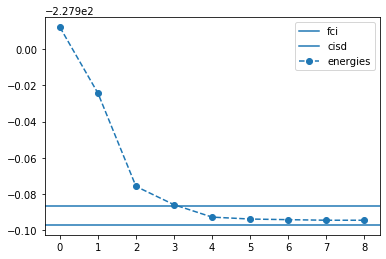

In [2]:
result.history.plot("energies", baselines={"fci":fci, "cisd": cisd})